# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [ ]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/root/co2-flux-hourly-gpp-modeling"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install azure.storage.blob 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [ ]:
import os
os.chdir(MY_HOME_ABS_PATH)
# !pip install -r ./code/requirements.txt

In [ ]:
!pip install pytorch_lightning 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch_forecasting


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

# from CloudIO.AzStorageClient import AzStorageClient
import AzStorageClient as AzStorageClient
# from data_pipeline_lib import *
# from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

### (Reading data_pipeline_lib/ model_pipeline_lib manually because of the issue in colab)

In [ ]:
import os
import sys
import random
import pandas as pd
import numpy as np

from datetime import datetime 
from io import BytesIO
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# if ("UseSpark" in os.environ) or (os.environ.get('UseSpark') == "true"):
#   from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
#   from pyspark.sql.functions import col

from IPython.display import display
# from CloudIO.AzStorageClient import AzStorageClient
import AzStorageClient

def get_min_max(df):
  return (df.min(), df.max())

def get_min_max_datetime(df):
  return (pd.to_datetime(df).min(), pd.to_datetime(df).max())

def is_leap_year(year):
  return year%4 == 0 ;

def data_cleanup(data_dir, site_id_file_df, target, target_qc, features):
  data_df = None
  # qc_flag_dtype = CategoricalDtype([0, 1, 2, 3], ordered=True)
  qc_flags_features = [s for s in features if "_QC" in s]

  # Iterate through each site:
  for i, r in site_id_file_df.iterrows():        
    if not r.filename or type(r.filename) != type(""):
      print(f'\nERROR: {r.site_id} is mssing hourly data.')
      continue

    # Get only `features` from file
    local_filename = data_dir + os.sep + r.filename
    site_df = pd.read_csv(local_filename, usecols = [target, target_qc] + features)
    site_df['datetime'] = pd.to_datetime(site_df['datetime'])
    site_df['date'] = pd.to_datetime(site_df['date'])
    site_df['minute'] = site_df['datetime'].dt.minute
    if len(qc_flags_features) != 0:
      site_df[qc_flags_features] = site_df[qc_flags_features].astype('int')
    site_df['site_id'] = r.site_id

    # Add time index columns
    site_df = add_time_index(site_df, 'datetime', '30T')

    # Remove zero or negative SW
    site_df.drop(site_df[site_df['SW_IN_ERA'] <= 0].index, inplace = True)

    # Drop rows with NAs for Target Variable
    site_df.dropna(subset=[target], axis=0, inplace=True)

    # Drop rows with bad NEE_VUT_REF_QC (aka bad GPP records)
    site_df.drop(site_df[site_df[target_qc] == 3].index, inplace = True)
    site_df.drop([target_qc], axis=1, inplace=True)

    # Drop rows with any NA
    site_df.dropna(axis=0, inplace=True)

    print(f"{r.site_id}: {site_df.shape}")
    if type(data_df) == type(None):
      data_df = site_df
    else:
      data_df = pd.concat([data_df, site_df])
          
  return data_df

def merge_site_metadata(data_df, site_metadata_df):
  data_df = data_df.merge(site_metadata_df, how='left', left_on='site_id', right_on='site_id')
  return data_df

def check_and_drop_na(data_df):
  if data_df.isna().sum().sum() > 0:
    print("Data has NA.")
    display(pd.DataFrame(data_df.isna().sum()).T)
    data_df.dropna(axis=0, inplace=True)
  else:
    print("Datas has no NA.")

def add_time_index(data_df, time_col, duration):
  resampled_df = data_df.sort_values(by=[time_col])
  resampled_df.set_index(time_col, inplace=True)
  resampled_df = resampled_df.resample(duration).mean()
  resampled_df = resampled_df.reset_index()
  resampled_df.index.name='timestep_idx'
  resampled_df = resampled_df.reset_index()
  data_df = data_df.merge(resampled_df[[time_col, 'timestep_idx']], how='left', on='datetime')
  return data_df


class PrepareMonthlyData:
    def __init__(self, included_features, monthly_data_input_fname, data_dir):
        self.included_features =included_features
        self.data_dir = data_dir
        self.monthly_data_input_fname = monthly_data_input_fname
        self.month_df = pd.read_csv(self.monthly_data_input_fname, usecols=self.included_features)
        self.month_df['date'] = pd.to_datetime(self.month_df['TIMESTAMP'],  format="%Y%m")


    def to_datetime(self, row):
        return pd.to_datetime(f'{row.year}{row.month:02}', format='%Y%m')


    def knn_impute(self, df, knn_imp_cols, k, weights):
        # Fit and transform the data using KNNImputer, format as DF
        inds = df.index.copy()
        df_subcols = df[knn_imp_cols].copy()
        df_subcols = df_subcols.dropna(axis=1, how='all')

        # Execute imputation
        imputer = KNNImputer(n_neighbors=k, weights=weights)
        imputed_group = imputer.fit_transform(df_subcols)
        imputed_group = pd.DataFrame(imputed_group, columns=df_subcols.columns, index=inds)

        # Fill NA in initial site/group df
        df.fillna(imputed_group, inplace=True)

        return df


    def impute(self, impute_method, resample_monthly, knn_imp_cols=None, k=None, weights=None, c=-1):
        # Resample to fill in missing month gaps, and interpolate values at site-level
        monthly_df = None

        # Subset month_df to only sites with hourly records available
        available_sites = [x[-10:-4] for x in os.listdir(self.data_dir)]
        init_sites = len(self.month_df['SITE_ID'].unique())
        self.month_df = self.month_df.loc[self.month_df['SITE_ID'].isin(available_sites)]
        print(f"# sites dropped bc not available in data_dir: {init_sites - len(self.month_df['SITE_ID'].unique())}")
        
        # Loop through hourly site data to determine which months are present
        for i, s in tqdm(enumerate(self.month_df['SITE_ID'].unique())):
            # Get monthly data for site
            site_month = self.month_df[self.month_df['SITE_ID'] == s].copy()
            site_month.reset_index(drop = True, inplace=True)
            site_month['gap_flag_month'] = int(0)

            if resample_monthly:
                # Get start and end range for given site <------------------------- CREATE DF NEXT TIME TO SAVE TIME (30 seconds per run)
                site_file = f'data_full_half_hourly_raw_v0_1_{s}.csv'
                site_hr_df = pd.read_csv(f"{self.data_dir}/{site_file}", usecols=['SITE_ID', 'datetime', 'year', 'month'])
                dates = [d for d in pd.date_range(start=site_hr_df['datetime'].min(), end=site_hr_df['datetime'].max(), freq='M')]

                # Create range of monthly dates from beginning of minimum month to beginning of next month after maximum month
                site_hr_df['datetime'] = pd.to_datetime(site_hr_df['datetime'])
                min_datetime = site_hr_df['datetime'].min()
                max_datetime = site_hr_df['datetime'].max()
                dates = pd.date_range(start=min_datetime.replace(day=1), end=max_datetime.replace(day=1) + pd.offsets.MonthBegin(1), freq='MS')

                # Create dataframe
                site_hr_df = pd.DataFrame({'datetime': dates})
                site_hr_df['year'] = site_hr_df['datetime'].dt.year
                site_hr_df['month'] = site_hr_df['datetime'].dt.month
                site_hr_df['SITE_ID'] = s

                # Resample montlhly data to get the months required in hourly data
                pft = site_month['MODIS_PFT'][0] # retain PFT to fill new rows
                igbp = site_month['MODIS_IGBP'][0] # retain PFT to fill new rows
                site_month = pd.merge(site_hr_df, site_month, how='left', on =['SITE_ID', 'year', 'month'])
                site_month['MODIS_PFT'] = pft
                site_month['MODIS_IGBP'] = igbp
                site_month['SITE_ID'] = s
                site_month['gap_flag_month'].fillna(int(1), inplace=True)

            # Fill in known values for new/resampled month-level rows
            site_month['datetime'] = site_month.apply(self.to_datetime, axis=1)
            site_month.set_index('datetime', inplace=True)
            site_month.drop(columns='TIMESTAMP', inplace=True)
            site_month.drop(columns='date', inplace=True)

            # If any new months added by resample, interpolate gap values at site-level
            if site_month.isna().sum().sum() != 0: 
                if impute_method == 'interpolate':
                    site_month.interpolate(method='linear', limit_direction='both', inplace=True)

                elif impute_method == 'knn':
                    nan_cols = site_month.columns[site_month.isna().all()].tolist()
                    site_month = self.knn_impute(site_month, knn_imp_cols, k, weights)
                    if len(nan_cols) > 0:
                        print(f'{s} has column(s) with only NAN: {nan_cols}')
                        for c in nan_cols:
                            site_month[c] = np.nan
                            
                elif impute_method == 'constant':
                    monthly_df = self.month_df.fillna(c)

            # Concat site_month to monthly_df
            if type(monthly_df) == type(None):
                monthly_df = site_month
            else:
                monthly_df = pd.concat([monthly_df, site_month])

        # if any site had 100% missing for a feature, impute these using global data
        if monthly_df.isna().sum().sum() != 0:
            print("Imputing values where site has 100 percent of feature missing")
            print(f"# of NA features before global impute: {monthly_df.isna().sum().sum()}")
            if impute_method == 'interpolate':
                monthly_df.interpolate(method='linear', limit_direction='both', inplace=True)

            elif impute_method == 'knn':
                monthly_df = self.knn_impute(monthly_df, knn_imp_cols, k, weights)

            elif impute_method == 'constant':
                monthly_df = self.monthly_df.fillna(c)

            print(f"# of NA features after global impute: {monthly_df.isna().sum().sum()}")

        return monthly_df


    def run(self, impute=False, impute_method=None, resample_monthly=False, knn_imp_cols=None, k=None, weights=None, c=-1):
        # Hanlde missing values
        if impute:
            print(f"Impute method: {impute_method}")
            print(f"Resampling and gap filling missing months: {resample_monthly}")
            monthly_df = self.impute(impute_method, resample_monthly, knn_imp_cols, k, weights, c)
        else:
            print("Not gap filling or filling NAs, leave be")
            available_sites = [x[-10:-4] for x in os.listdir(self.data_dir)]
            self.month_df = self.month_df.loc[self.month_df['SITE_ID'].isin(available_sites)]
            monthly_df = self.month_df.copy()
            
        # Confirm No NAS
        if monthly_df.isna().sum().sum() == 0:
            print("Confirmed: No NA values remain")
        elif type(impute_method) != type(None):
            print("ISSUE: SOME NA VALUES REMAIN - INVESTIGATE")
            monthly_df.isna().sum()

        return monthly_df
        

class PrepareAllSitesHourly:
    def __init__(self, site_metadata_filename, monthly_data_filename, train_sites, val_sites, test_sites, 
                hourly_features, metadata_features, target_variable_qc, target_variable, data_dir):
        self.site_metadata_filename = site_metadata_filename
        self.monthly_data_filename = monthly_data_filename
        self.train_sites = train_sites
        self.val_sites = val_sites
        self.test_sites = test_sites
        if train_sites is not None and val_sites is not None and test_sites is not None:
          self.all_sites = train_sites + val_sites + test_sites
        else:
          self.all_sites = None
        self.hourly_features = hourly_features
        self.metadata_features = metadata_features
        self.target_variable_qc = target_variable_qc
        self.target_variable = target_variable
        self.data_dir = data_dir

    def add_time_index(self, df, time_col, duration, site_id):
        df['gap_flag_hour'] = int(0)
        df.sort_values(time_col, inplace=True)
        df.set_index(time_col, inplace=True)
        df = df.resample(duration).first()
        df = df.reset_index()
        df['gap_flag_hour'].fillna(int(1), inplace=True)

        # Fix time records that are NA for new rows
        df['year'] = df['datetime'].dt.year.astype(int)
        df['month'] = df['datetime'].dt.month.astype(int)
        df['day'] = df['datetime'].dt.day.astype(int)
        df['hour'] = df['datetime'].dt.hour.astype(int)
        df['date'] = df['datetime'].dt.date
        df['site_id'] = site_id

        return df


    def knn_impute(self, df, imp_cols, k, weights, n_fit=20000):
        # Init Imputer
        imputer = KNNImputer(n_neighbors=k, weights=weights)

        # Get subset of rows to speed up impute time (instead of fitting on every single record)
        df_subcols = df[imp_cols].copy()
        na_mask = df_subcols.isna().any(axis=1)
        na_rows = df_subcols[na_mask]
        nan_cols = []
        imputed_group_columns = df_subcols.columns

        # If there are at least 10k rows that don't have NA, use them to fit imputer (saves time)
        if (len(df) - len(na_rows)) > 10000:
            not_na_rows = df_subcols.dropna()
            not_na_rows = not_na_rows[na_rows.columns]
            not_na_rows = not_na_rows.sample(n=np.min([n_fit, len(not_na_rows)]))
            imputer.fit(not_na_rows)
            imputed_group = imputer.transform(na_rows)
        else:
            nan_cols = na_rows.columns[na_rows.isna().all()].tolist()
            na_rows = na_rows.dropna(axis=1, how='all')
            imputed_group_columns = na_rows.columns
            imputed_group = imputer.fit_transform(na_rows)

        imputed_group = pd.DataFrame(imputed_group, columns=imputed_group_columns, index=na_rows.index)
        if len(nan_cols) > 0:
            print(f'  Column(s) with only NAN: {nan_cols}')
            for c in nan_cols:
                imputed_group[c] = np.nan

        # Reinsert NA rows
        df_subcols.loc[na_mask] = imputed_group

        # Fill NA in initial site/group df
        df.fillna(df_subcols, inplace=True)

        return df

    
    def check_imputation(self, df_init,  df_imputed):
        # Drop NA rows from both (using indices) confirm they are same df now
        drop_na = df_init.dropna(how='any')
        drop_imp = df_imputed.loc[drop_na.index, ]
        drop_na.reset_index(inplace=True, drop=True)
        drop_imp.reset_index(inplace=True, drop=True)
        if not drop_na.equals(drop_imp):
            print("IMPUTATION ERROR: Non-NA values were affected in imputation")

        # Check that 50 rows that initial had NA are the same in non-NA cols
        na_inds = df_init.loc[df_init.isna().any(axis=1), ].index
        errors = 0
        for ind in na_inds[:50]:
            check_ind = pd.concat([df_init.iloc[ind], df_imputed.iloc[ind]], axis=1).dropna()
            check_ind.columns = ['initial', 'post_imp']
            if not check_ind['initial'].equals(check_ind['post_imp']):
                errors += 1
                print(ind)

        if errors != 0:
            print("IMPUTATION ERROR: Non-NA values in rows with NA were affected by imputation")

        # DF length is the same 
        if len(df_init) != len(df_imputed):
            print("IMPUTATION ERROR: Post imputation df has different row count than initial df")


    def filter_date_range(self, df, start_date, end_date, time_col, missing_thresh=0.2):
        df.set_index(time_col, inplace=True)
        filtered_df = df.loc[start_date:end_date].copy()

        # Remove sites without at least one year of records
        if len(filtered_df) < 365*24:
            return None
        else:
            # Remove sites that have > 20% gaps in sequence
            first_date = filtered_df.index.min()
            last_date = filtered_df.index.max()
            total_expected_count = len(pd.date_range(start=first_date, end=last_date, freq='H'))
            missing_percentage = (total_expected_count - len(filtered_df)) / total_expected_count

            if missing_percentage > missing_thresh:
                return None
            else:
                filtered_df.reset_index(inplace=True)
                return filtered_df
            

    def prep_metadata(self):
        site_metadata_df = pd.read_csv(self.site_metadata_filename, usecols = self.metadata_features)
        
        if self.all_sites is not None:
          site_metadata_df = site_metadata_df.loc[site_metadata_df['site_id'].isin(self.all_sites), ]
        
        site_metadata_df = site_metadata_df.loc[site_metadata_df['monthly_data_available']=='Yes', ] # <---- not including sites that have zero monthly data (ask team)
        site_metadata_df.reset_index(inplace=True, drop=True)
        return site_metadata_df


    def merge_site_metadata(self, data_df, site_metadata_df):
        site_metadata_df = site_metadata_df.drop(['filename', 'monthly_data_available'], axis=1)
        data_df = data_df.merge(site_metadata_df, how='left', left_on='site_id', right_on='site_id')
        print(f"Data size after after merged with site metadata: {data_df.shape}")

        if data_df.isna().sum().sum() != 0:
            print(f"Missing values after metadata merge {data_df.isna().sum().sum()} ")

        return data_df


    def merge_monthly_data(self, data_df):
        # Prep monthly
        monthly_df = pd.read_csv(self.monthly_data_filename)
        monthly_df.reset_index(inplace=True, drop=True)
        monthly_df[['year','month', 'MODIS_LC']] = monthly_df[['year','month', 'MODIS_LC']].astype('int')

        if monthly_df.isna().sum().sum() != 0:
            print(f"{monthly_df.isna().sum().sum()} missing values in monthly data")

        # Merge
        data_df = data_df.merge(monthly_df, how='left',
                        left_on =['site_id', 'year', 'month'],
                        right_on=['SITE_ID', 'year', 'month'])
        data_df.drop('SITE_ID', axis=1, inplace=True)
        print(f"Data size after after merged with monthly data: {data_df.shape}")

        if data_df.isna().sum().sum() != 0:
            print(f"{data_df.isna().sum().sum()} missing values introduced after monthly merge")

        return data_df
    

    def site_data_cleanup(self, site_metadata_df, imp_cols, resample, impute, impute_method,
                         impute_global, k, weights, n_fit, time_col, duration, start_date, end_date, missing_thresh=0.2, c=None):
        data_df = None
        num_records = 0
        available_site_count = 0
        retained_site_count = 0
        qc_flags_features = [s for s in self.hourly_features if "_QC" in s]

        # Global time index base
        global_time_index_base = datetime(1970, 1, 1, 0, 0, 0)

        ## SITE-LEVEL CLEANING -> LOOP & CONCATENATE
        for i, r in tqdm(site_metadata_df[['site_id','filename']].iterrows()):
          if not r.filename or type(r.filename) != type(""):
            print(f'SKIP: {r.site_id} is missing hourly data.')
            continue

          available_site_count += 1  

          # Prepare hourly site df
          local_filename = self.data_dir + os.sep + r.filename
          site_df = pd.read_csv(local_filename, usecols = [self.target_variable] + self.hourly_features)

          # Format columns
          site_df['datetime'] = pd.to_datetime(site_df['datetime'])
          site_df['date'] = pd.to_datetime(site_df['date'])
          site_df['minute'] = site_df['datetime'].dt.minute
          if len(qc_flags_features) != 0:
              site_df[qc_flags_features] = site_df[qc_flags_features].astype('int')
          site_df['site_id'] = r.site_id

          # Move from HH to H level
          site_df = site_df.loc[site_df['datetime'].dt.minute == 0, ].copy()
          site_df.drop('minute', axis=1, inplace=True)
            
          # Filter site date-range and drop sites without > 1 year and <20% gaps after trim
          if start_date is not None and end_date is not None:
            site_df = self.filter_date_range(site_df, start_date, end_date, time_col, missing_thresh)
          
          if site_df is None:
              print(f'SKIP: {r.site_id} does not have sufficient data in desired time period')
              continue
          else:
              retained_site_count += 1
              num_records += len(site_df)

          # Resample to add rows for missing timesteps, assign timestep_idx and "gap_flag"
          if resample:
              site_df = self.add_time_index(site_df, time_col, duration, site_id=r.site_id)
          else:
              site_df['gap_flag_hour'] = 0
              site_df.sort_values(time_col, inplace=True)
              site_df = site_df.reset_index()

          # Save site_df pre-imputation to check post-imputation (once per run, random site each time)
          if self.all_sites is not None:
            random_check = random.randint(0, len(self.all_sites))
          else:
            random_check = random.randint(0, site_metadata_df['site_id'].unique().shape[0])
          
          if i == random_check:   
              site_df_pre_imp = site_df.copy()
          
          # Impute missing values at site-level, otherwise fillna w/ -1 at very end
          if (impute) & (site_df.isna().sum().sum() != 0):
              if impute_method=='ffill': # select most recent record
                  site_df.sort_values(time_col, ascending=True, inplace=True)
                  site_df.fillna(method="ffill", inplace=True)
              elif impute_method=='knn': # use KNNImputer
                  nan_cols = site_df.columns[site_df.isna().all()].tolist()
                  site_df = self.knn_impute(site_df, imp_cols, k, weights, n_fit)
                  if len(nan_cols) > 0:
                      print(f'{r.site_id} has column(s) with only NAN: {nan_cols}')
                      for c in nan_cols:
                          site_df[c] = pd.NA
              elif impute_method=='constant':
                  site_df[imp_cols] = site_df[imp_cols].fillna(c)

          if i == random_check:
              self.check_imputation(site_df_pre_imp, site_df)
          
          # Create local timestep_idx
          site_df.sort_values(time_col, ascending=True, inplace=True)
          site_df['timestep_idx_local'] = range(len(site_df))

          # Create global timestamp inds
          site_df['timestep_idx_global'] = (site_df[time_col]- global_time_index_base).\
                                            apply(lambda x: int(x.total_seconds() / 3600))

          # Concatenate site_dfs together into global data_df
          print(f'{i+1}. {r.site_id}: {site_df.shape}')
          if type(data_df) == type(None):
              data_df = site_df
          else:
              data_df = pd.concat([data_df, site_df])
        # End all-site loop

        ## Global Data-DF Cleanup
        # Order cols + sort
        data_df.sort_values(['site_id', time_col], ascending=True, inplace=True)

        # Print stats
        print(f"Initial records: {num_records}, Final records after resampling + gap-filling: {len(data_df)}")
        print(f"Total retained sites: {retained_site_count}/{available_site_count} = {retained_site_count/available_site_count:.2f}")

        # Handle remaining missing data (if 100% of feature missing for one site)
        print(f"Missing values after site-level imputation: {data_df.isna().sum().sum()}")
        if (impute_global) & (data_df.isna().sum().sum() != 0):
            if impute_method=='ffill': # select most recent record
                data_df.sort_values(time_col, ascending=True, inplace=True)
                data_df.fillna(method="ffill", inplace=True)
                data_df.fillna(method="bfill", inplace=True) # in rare case of missing first record
                
            elif impute_method=='knn': # use KNNImputer
                data_df = self.knn_impute(data_df, imp_cols, k, weights, n_fit)

            elif impute_method=='constant':
                data_df[imp_cols] = data_df[imp_cols].fillna(c)
        else:
            print("Not imputing missing values at global level")
        print(f"Missing values after global-level imputation: {data_df.isna().sum().sum()}")

        return data_df
    

    def all_sites_all_sources(self, imp_cols, resample, impute, impute_method, impute_global, k,
                            weights, n_fit, time_col, duration, start_date, end_date, missing_thresh, c):
        
        site_metadata_df = self.prep_metadata()
        
        if self.all_sites is not None:
          sites_missing_monthly = [s for s in self.all_sites if s not in site_metadata_df['site_id'].values]
          if len(sites_missing_monthly):
            print(f'Sites with missing monthly data: {sites_missing_monthly}')

        data_df = self.site_data_cleanup(site_metadata_df, imp_cols, resample, impute, impute_method, 
                                        impute_global, k, weights, n_fit, time_col, duration, start_date, end_date, missing_thresh, c)

        # Merge with site metadata and monthly data
        data_df = self.merge_site_metadata(data_df, site_metadata_df)
        data_df = self.merge_monthly_data(data_df)

        # Reorder columns
        features = data_df.columns.to_list()
        remove_cols = [self.target_variable, 'site_id', 'timestep_idx_local', 'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day', 'hour', 'gap_flag_hour', 'gap_flag_month']
        features = list(filter(lambda x: x not in remove_cols, features))
        data_df = data_df[([self.target_variable, 'site_id', 'timestep_idx_local', 'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day', 'hour'] + features + ['gap_flag_hour', 'gap_flag_month'])]

        return data_df

if ("UseSpark" in os.environ) or (os.environ.get('UseSpark') == "true"):
    class PySparkMLDataTransformer:
      def __init__(self, spark_session, train_sites, test_sites, \
                  data_file_path = None, data_df = None, ):
        
        self.spark_session = spark_session
        self.data_df = data_df 
        self.train_df = None 
        self.test_df = None 
        self.train_sites = train_sites
        self.test_sites = test_sites
        self.scaler = None

        if type(data_df) == type(None):
          if os.path.exists(data_file_path):
            self.data_df = self.spark_session.read.parquet(data_file_path)
            if '__index_level_0__' in self.data_df.columns:
              self.data_df = self.data_df.drop(*['__index_level_0__'])
          else:
            print(f"ERROR: {data_file_path} not found.")
        
        if 'date' in self.data_df.columns:
          self.data_df = self.data_df.drop(*['date'])
        print(f"Data loaded: {self.data_df.count()} rows x {len(self.data_df.columns)} columns.")
      
      def data_transform(self, categorical_cols, timestamp_cols, target_col):
        self.categorical_cols = categorical_cols
        self.timestamp_cols =  timestamp_cols
        self.target_col =  target_col

        # One-Hot Encoding
        string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=[x + "_Index" for x in categorical_cols]) 
        self.data_df = string_indexer.fit(self.data_df).transform(self.data_df)
        one_hot_encoder  = OneHotEncoder(inputCols=string_indexer.getOutputCols(), outputCols=[x + "_OHE" for x in categorical_cols])
        self.data_df = one_hot_encoder.fit(self.data_df).transform(self.data_df)
        self.data_df = self.data_df.drop(*string_indexer.getOutputCols())

        print(f"Data size after encoding: {self.data_df.count()} rows x {len(self.data_df.columns)} columns.")
        self.data_df.show(5, False)

        # Get Features
        features = self.data_df.columns
        features.remove(target_col)
        features.remove('site_id')
        for f in categorical_cols + timestamp_cols:
          features.remove(f)
        print(f"Features({len(features)}): {features}")

        # Assemable Data
        assembler = VectorAssembler(inputCols=features, outputCol="vectorized_features")
        self.data_df = assembler.transform(self.data_df)
        print(f"Data size after assembling: {self.data_df.count()} rows x {len(self.data_df.columns)} columns.")
        self.data_df.show(5, False)

        # Split into train and test sets
        train_df = self.data_df.filter(col('site_id').isin(self.train_sites))
        test_df = self.data_df.filter(col('site_id').isin(self.test_sites))
        print(f"Train data size: {train_df.count()} rows x {len(train_df.columns)} columns.")
        print(f"Test data size: {test_df.count()} rows x {len(test_df.columns)} columns.")

        print("Train data peak:")
        train_df.show(5, False)
        print("Test data peak:")
        test_df.show(5, False)

        # Normalize data
        self.scaler = MinMaxScaler(inputCol='vectorized_features', outputCol='features').fit(train_df)
        train_df = self.scaler.transform(train_df)
        test_df = self.scaler.transform(test_df)

        train_df = train_df.drop(*['vectorized_features'])
        test_df = test_df.drop(*['vectorized_features'])
        print(f"Train data size: {train_df.count()} rows x {len(train_df.columns)} columns.")
        print(f"Test data size: {test_df.count()} rows x {len(test_df.columns)} columns.")

        self.train_df = train_df
        self.test_df = test_df
        return (train_df, test_df)
      
      def upload_train_test_to_azure(self, az_cred_file, container, train_blob_name, val_blob_name, test_blob_name):
        # Initialize AzStorageClient 
        azStorageClient = AzStorageClient(az_cred_file)
        sessionkeys = azStorageClient.getSparkSessionKeys()
        self.spark_session.conf.set(sessionkeys[0],sessionkeys[1])

        # Upload train dataset
        train_blob_path = f"wasbs://{container}@{sessionkeys[2]}.blob.core.windows.net/{train_blob_name}"
        print(f"Uploading train dataset to {train_blob_path}...")
        self.train_df.write.format("parquet").mode("overwrite").save(train_blob_path)

        # Upload val dataset
        val_blob_name = f"wasbs://{container}@{sessionkeys[2]}.blob.core.windows.net/{val_blob_name}"
        print(f"Uploading train dataset to {val_blob_name}...")
        self.val_df.write.format("parquet").mode("overwrite").save(val_blob_name)

        # Upload test dataset
        test_blob_path = f"wasbs://{container}@{sessionkeys[2]}.blob.core.windows.net/{test_blob_name}"
        print(f"Uploading test dataset to {test_blob_path}...")
        self.test_df.write.format("parquet").mode("overwrite").save(test_blob_path)

class TFTDataTransformer:
  def __init__(self, train_sites, val_sites, test_sites, \
              data_file_path = None, data_df = None):
    
    self.data_df = data_df 
    self.train_sites = train_sites
    self.val_sites = val_sites
    self.test_sites = test_sites
    self.scaler = None

    # Load data df
    if type(data_df) == type(None):
      if os.path.exists(data_file_path):
        self.data_df = pd.read_parquet(data_file_path, engine='pyarrow')
      else:
        print(f"ERROR: {data_file_path} not found.")
    
    if 'date' in self.data_df.columns:
      self.data_df = self.data_df.drop(['date'], axis = 1)
    print(f"Data size: {self.data_df.shape}.")

  def get_test_train_raw(self):
    train_df = self.data_df[self.data_df['site_id'].isin(self.train_sites)]
    test_df  = self.data_df[self.data_df['site_id'].isin(self.test_sites)]
    print(f"Train data size: {train_df.shape}.")
    print(f"Test data size: {test_df.shape}.")

    self.train_df = train_df
    self.test_df = test_df
    return (train_df, test_df)

  def data_transform(self, categorical_cols, realNum_cols, cat_encode_type='label'):
    data_df = self.data_df
    print(f"Data size: {self.data_df.shape}.")

    # Encode the categorical columns
    if cat_encode_type == 'label':
      data_df[categorical_cols] = data_df[categorical_cols].apply(LabelEncoder().fit_transform)
    elif cat_encode_type == 'dummy':
      dummy_df = pd.get_dummies(data_df[categorical_cols])
      data_df = data_df.drop(columns=categorical_cols)
      data_df = pd.concat([data_df, dummy_df], axis=1)
    print(f"Data size after encoding: {data_df.shape}")
      
    # Split into train, val, and test sets
    train_df = data_df.loc[data_df['site_id'].isin(self.train_sites), ].copy()
    val_df = data_df.loc[data_df['site_id'].isin(self.val_sites), ].copy()
    test_df  = data_df.loc[data_df['site_id'].isin(self.test_sites), ].copy()
    print(f"Number of sites in df: {len(data_df['site_id'].unique())}")
    print(f"Train Sites: {train_df['site_id'].unique()}")
    print(f"Val Sites: {val_df['site_id'].unique()}")
    print(f"Test Sites: {test_df['site_id'].unique()}")

    # Normalize data
    print(f"Normalizing real features ({len(realNum_cols)})")
    scaler = StandardScaler().fit(train_df[realNum_cols])
    train_df.loc[:,realNum_cols] = scaler.transform(train_df[realNum_cols])
    val_df.loc[:,realNum_cols] = scaler.transform(val_df[realNum_cols])
    test_df.loc[:,realNum_cols] = scaler.transform(test_df[realNum_cols])

    # Save scaler object <--- later
    
    print(f"Train data size: {train_df.shape}.")
    print(f"Val data size: {val_df.shape}.")
    print(f"Test data size: {test_df.shape}.")  
    train_df.reset_index(inplace=True, drop=True)
    val_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    return (train_df, val_df, test_df)

  def upload_train_test_to_azure(self, az_cred_file, container, train_blob_name, test_blob_name):
    # Initialize AzStorageClient 
    azStorageClient = AzStorageClient(az_cred_file)

    # Upload train dataset
    train_file = BytesIO()
    self.train_df.to_parquet(train_file, engine='pyarrow')
    train_file.seek(0)
    print(f"Uploading train dataset to {train_blob_name}...")
    azStorageClient.uploadBlob(container, train_blob_name, train_file, overwrite=True)

    # Upload test dataset
    test_file = BytesIO()
    self.test_df.to_parquet(test_file, engine='pyarrow')
    test_file.seek(0)
    print(f"Uploading test dataset to {test_blob_name}...")
    azStorageClient.uploadBlob(container, test_blob_name, test_file, overwrite=True)


In [ ]:
# MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"

# Inmport Libraries
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import logging
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple, Union
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import statsmodels.api as sm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback
import optuna.logging

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append('./.cred')
sys.path.append('./code/src/tools')
sys.path.append(os.path.abspath("./code/src/tools"))
  
# from CloudIO.AzStorageClient import AzStorageClient
import AzStorageClient
# from data_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
data_dir = root_dir + os.sep + 'data'
model_dir = data_dir + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Data loading functions

def get_raw_datasets(container, blob_name):
    local_file = tmp_dir + os.sep + blob_name
    data_df = None
    if not (os.path.exists(local_file)):
        azStorageClient = AzStorageClient(az_cred_file)
        file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
        data_df = pd.read_parquet(file_stream, engine='pyarrow')
        data_df.to_parquet(local_file)
    else:
        data_df = pd.read_parquet(local_file)
    
    print(f"Data size: {data_df.shape}")
    
    # Convert Dtypes
    cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
                "gap_flag_month", "gap_flag_hour"]
    for col in cat_cols:
        data_df[col] = data_df[col].astype(str).astype("category")
    
    print(f"Data Columns: {data_df.columns}")
    print(f"NA count: {data_df.isna().sum().sum()}")
    return data_df

def get_splited_datasets(data_df, val_index, test_index):
          
    SITE_SPLITS =[
      ['AR-SLu', 'AU-ASM', 'AU-Cpr', 'AU-Cum', 'AU-RDF', 'CA-TP3', 'CA-TPD', 'CN-Sw2',
        'DE-SfN', 'NL-Hor', 'US-Me6', 'US-Syv', 'US-WCr', 'US-AR2', 'US-Tw4', 'US-UMB', 
        'US-Vcp', 'CH-Cha', 'CZ-BK1', 'CZ-KrP', 'DE-Obe', 'ES-LJu', 'FI-Let', 'FR-Lam', 
        'IT-Lav', 'SE-Lnn'], 
      ['CZ-BK2', 'DE-Spw', 'FR-Pue', 'IT-CA3', 'IT-Noe', 'IT-Ro2', 'US-IB2', 'US-Myb',
        'US-SRM', 'CA-Ca3', 'US-CRT', 'US-Fmf', 'US-KFS', 'US-Prr', 'US-UMd', 'US-Wjs',
        'BE-Bra', 'BE-Lon', 'CH-Lae', 'CZ-RAJ', 'DE-HoH', 'DE-Kli', 'DE-RuR', 'IL-Yat', 
        'IT-Tor', 'SE-Htm'], 
      ['AR-Vir', 'AT-Neu', 'AU-DaS', 'AU-TTE', 'AU-Wom', 'CA-TP1', 'IT-CA1', 'IT-SRo',
        'US-WPT', 'US-Wkg', 'CA-Ca2', 'CA-Cbo', 'CA-TP4', 'US-ARM', 'US-Ro1', 'US-Rws',
        'US-SRG', 'US-Vcm', 'BE-Dor', 'BE-Vie', 'CZ-Stn', 'DE-Geb', 'ES-LM2', 'FR-Fon', 
        'SE-Ros', 'DE-Hte'],
      ['AU-DaP', 'AU-Emr', 'AU-Gin', 'AU-How', 'AU-Rig', 'US-GLE', 'US-NR1', 'US-Twt',
        'CA-Ca1', 'CA-Gro', 'US-AR1', 'US-Bar', 'US-Mpj', 'US-Ses', 'CH-Fru', 'CH-Oe2',
        'DE-Hai', 'DK-Sor', 'FI-Hyy', 'FR-Aur', 'FR-Hes', 'GF-Guy', 'IT-SR2', 'SE-Deg',
        'SE-Nor', 'NL-Loo'],
      ['AU-Stp', 'AU-Whr', 'CA-Oas', 'DE-Lnf', 'ES-Amo', 'FI-Sod', 'IT-CA2', 'US-Ton',
        'US-Var', 'US-Whs', 'US-Ho1', 'US-Oho', 'US-Seg', 'CH-Dav', 'CZ-Lnz', 'CZ-wet',
        'DE-Gri', 'DE-Tha', 'ES-LM1', 'FR-Bil', 'FR-FBn', 'IT-BCi', 'IT-MBo', 'IT-Ren',
        'RU-Fyo']
    ]

    train_sites, val_sites, test_sites = [], [], []
    for i, subset in enumerate(SITE_SPLITS):
        if i == val_index:
            val_sites = SITE_SPLITS[i]
        elif i == test_index:
            test_sites = SITE_SPLITS[i]
        else:
            train_sites += SITE_SPLITS[i]

    train_df = data_df.loc[data_df['site_id'].isin(train_sites), ].copy()
    val_df   = data_df.loc[data_df['site_id'].isin(val_sites), ].copy()

    if len(train_df['site_id'].unique()) != len(train_sites):
        print(f"Expected Train({len(train_sites)}), Actual Train({len(train_df['site_id'].unique())})")
        sites_missing = [s for s in train_sites if s not in train_df['site_id'].unique()]
        print(f'  missing: {sites_missing}')

    if len(val_df['site_id'].unique()) != len(val_sites):
        print(f"Expected Train({len(val_sites)}), Actual Train({len(val_df['site_id'].unique())})")
        sites_missing = [s for s in val_sites if s not in val_df['site_id'].unique()]
        print(f'  missing: {sites_missing}')

    if test_index is not None:
        test_df = data_df.loc[data_df['site_id'].isin(test_sites), ].copy()
        if len(test_df['site_id'].unique()) != len(test_sites):
            print(f"Expected Train({len(test_sites)}), Actual Train({len(test_df['site_id'].unique())})")
            sites_missing = [s for s in test_sites if s not in test_df['site_id'].unique()]
            print(f'  missing: {sites_missing}')
    else:
        test_df = None

    return (train_df, val_df, test_df)

def subset_data(train_df, val_df, test_df, subset_len):
    print(f'Subest length: {subset_len} timesteps for each sites')
    
    train_df = train_df.loc[train_df['timestep_idx_local'] < subset_len, ].copy()
    print(f"Subset num train timesteps: {len(train_df)}")
    val_df = val_df.loc[val_df['timestep_idx_local'] < subset_len, ].copy()
    print(f"Subset num val timesteps: {len(val_df)}")
    if test_df is not None:
        test_df = test_df.loc[test_df['timestep_idx_local'] < subset_len, ].copy()
        print(f"Subset num test timesteps: {len(test_df)}")

    return (train_df, val_df, test_df)

# Don't use this one
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub", "gap_flag_month", "gap_flag_hour"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=[], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True), # temp for subset
                            'month': NaNLabelEncoder(add_nan=True), # temp for subset
                            'day': NaNLabelEncoder(add_nan=True), # temp for subset
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

# Use this instead!!
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)
          
# Eval Functions
def nash_sutcliffe(observed_values, predicted_values):
    numerator = torch.sum((observed_values - predicted_values)**2)
    denominator = torch.sum((observed_values - torch.mean(observed_values))**2)
    nse_val = 1 - (numerator / denominator)
    return nse_val

def numpy_normalised_quantile_loss(y, y_pred, quantile):
    """Computes normalised quantile loss for numpy arrays.
    ref: https://github.com/google-research/google-research/blob/master/tft/script_train_fixed_params.py
    Uses the q-Risk metric as defined in the "Training Procedure" section of the main TFT paper.
    Args:
    y: Targets
    y_pred: Predictions
    quantile: Quantile to use for loss calculations (between 0 & 1)
    Returns:
    Float for normalised quantile loss.
    """
    prediction_underflow = y - y_pred
    weighted_errors = quantile * np.maximum(prediction_underflow, 0.) \
      + (1. - quantile) * np.maximum(-prediction_underflow, 0.)

    return 2 * (weighted_errors.mean()) / (y.abs().mean())


def get_eval_mask(dataloader):
    return torch.logical_not(torch.cat([x['decoder_cont'][:, :, -1].reshape(-1) for x, y in iter(dataloader)]))

def get_eval_metrics(y_true, y_pred, mask=None, p90_pred=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]
        if p90_pred is not None:
            p90_pred = p90_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
    mae = torch.mean((y_true - y_pred).abs())
    nse = nash_sutcliffe(y_true, y_pred)
    r2 = r2_score(y_true.numpy(), y_pred.numpy())
    p50_loss = numpy_normalised_quantile_loss(y_true, y_pred, 0.5)
    evals = {"rmse": rmse.item(), "mae": mae.item(), "nse": nse.item(), "r2": r2, "p50_loss": p50_loss.item()}

    if p90_pred is not None:
        p90_loss = numpy_normalised_quantile_loss(y_true, p90_pred, 0.9)
        evals["p90_loss"] = p90_loss.item()
    
    return evals

# Mask metrics for validation set
def masked_eval_metrics(dataloader, model):
    # Get y_true, y_pred, mask
    y_true = torch.cat([y[0] for x, y in iter(dataloader)]).reshape(-1)
    y_pred = model.predict(dataloader).reshape(-1)
    mask = torch.logical_not(torch.cat([x['decoder_cont'][:, :, -1].reshape(-1) for x, y in iter(dataloader)]))

    # Apply mask
    masked_y_true = y_true[mask.bool()]
    masked_y_pred = y_pred[mask.bool()]

    # Get masked RMSE, MAE, NSE
    masked_rmse = torch.sqrt(torch.mean((masked_y_true - masked_y_pred) ** 2))
    masked_mae = torch.mean((masked_y_true - masked_y_pred).abs())
    masked_nse = nash_sutcliffe(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())
    masked_r2 = r2_score(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())

    return masked_rmse, masked_mae, masked_nse, masked_r2

# Custom Hyperparameter Optimizer
# ref: https://pytorch-forecasting.readthedocs.io/en/stable/_modules/pytorch_forecasting/models/temporal_fusion_transformer/tuning.html#optimize_hyperparameters

optuna_logger = logging.getLogger("optuna")

class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)
        
def custom_optimize_hyperparameters(
    train_dataloaders: DataLoader,
    val_dataloaders: DataLoader,
    model_path: str,
    max_epochs: int = 20,
    n_trials: int = 100,
    timeout: float = 3600 * 8.0,  # 8 hours
    gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
    hidden_size_range: Tuple[int, int] = (16, 265),
    hidden_continuous_size_range: Tuple[int, int] = (8, 64),
    attention_head_size_range: Tuple[int, int] = (1, 4),
    dropout_range: Tuple[float, float] = (0.1, 0.3),
    learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
    use_learning_rate_finder: bool = True,
    trainer_kwargs: Dict[str, Any] = {},
    trainer_callbacks: List[Callback] = None,
    log_dir: str = "lightning_logs",
    study: optuna.Study = None,
    verbose: Union[int, bool] = None,
    pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
    **kwargs,
) -> optuna.Study:
    """
    Optimize Temporal Fusion Transformer hyperparameters.

    Run hyperparameter optimization. Learning rate for is determined with
    the PyTorch Lightning learning rate finder.

    Args:
        train_dataloaders (DataLoader): dataloader for training model
        val_dataloaders (DataLoader): dataloader for validating model
        model_path (str): folder to which model checkpoints are saved
        max_epochs (int, optional): Maximum number of epochs to run training. Defaults to 20.
        n_trials (int, optional): Number of hyperparameter trials to run. Defaults to 100.
        timeout (float, optional): Time in seconds after which training is stopped regardless of number of epochs
            or validation metric. Defaults to 3600*8.0.
        hidden_size_range (Tuple[int, int], optional): Minimum and maximum of ``hidden_size`` hyperparameter. Defaults
            to (16, 265).
        hidden_continuous_size_range (Tuple[int, int], optional):  Minimum and maximum of ``hidden_continuous_size``
            hyperparameter. Defaults to (8, 64).
        attention_head_size_range (Tuple[int, int], optional):  Minimum and maximum of ``attention_head_size``
            hyperparameter. Defaults to (1, 4).
        dropout_range (Tuple[float, float], optional):  Minimum and maximum of ``dropout`` hyperparameter. Defaults to
            (0.1, 0.3).
        learning_rate_range (Tuple[float, float], optional): Learning rate range. Defaults to (1e-5, 1.0).
        use_learning_rate_finder (bool): If to use learning rate finder or optimize as part of hyperparameters.
            Defaults to True.
        trainer_kwargs (Dict[str, Any], optional): Additional arguments to the
            `PyTorch Lightning trainer <https://pytorch-lightning.readthedocs.io/en/latest/trainer.html>`_ such
            as ``limit_train_batches``. Defaults to {}.
        trainer_callbacks ( List[Callback], optiona) Early stoppping option for trainer.
        log_dir (str, optional): Folder into which to log results for tensorboard. Defaults to "lightning_logs".
        study (optuna.Study, optional): study to resume. Will create new study by default.
        verbose (Union[int, bool]): level of verbosity.
            * None: no change in verbosity level (equivalent to verbose=1 by optuna-set default).
            * 0 or False: log only warnings.
            * 1 or True: log pruning events.
            * 2: optuna logging level at debug level.
            Defaults to None.
        pruner (optuna.pruners.BasePruner, optional): The optuna pruner to use.
            Defaults to optuna.pruners.SuccessiveHalvingPruner().

        **kwargs: Additional arguments for the :py:class:`~TemporalFusionTransformer`.

    Returns:
        optuna.Study: optuna study results
    """
    assert isinstance(train_dataloaders.dataset, TimeSeriesDataSet) and isinstance(
        val_dataloaders.dataset, TimeSeriesDataSet
    ), "dataloaders must be built from timeseriesdataset"

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    loss = kwargs.get(
        "loss", QuantileLoss()
    )  # need a deepcopy of loss as it will otherwise propagate from one trial to the next

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint.
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), filename="{epoch}", monitor="val_loss"
        )

        # The default logger in PyTorch Lightning writes to event files to be consumed by
        # TensorBoard. We don't use any logger here as it requires us to implement several abstract
        # methods. Instead we setup a simple callback, that saves metrics from each validation step.
        metrics_callback = MetricsCallback()
        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        default_trainer_kwargs = dict(
            gpus=[0] if torch.cuda.is_available() else None,
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                metrics_callback,
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
            ],
            logger=logger,
            enable_progress_bar=optuna_verbose < optuna.logging.INFO,
            enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO],
        )
        if trainer_callbacks is not None:
            default_trainer_kwargs['callbacks'] += trainer_callbacks
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(
            **default_trainer_kwargs,
        )

        # create model
        hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
        kwargs["loss"] = copy.deepcopy(loss)
        model = TemporalFusionTransformer.from_dataset(
            train_dataloaders.dataset,
            dropout=trial.suggest_uniform("dropout", *dropout_range),
            hidden_size=hidden_size,
            hidden_continuous_size=trial.suggest_int(
                "hidden_continuous_size",
                hidden_continuous_size_range[0],
                min(hidden_continuous_size_range[1], hidden_size),
                log=True,
            ),
            attention_head_size=trial.suggest_int("attention_head_size", *attention_head_size_range),
            log_interval=-1,
            **kwargs,
        )
        # find good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                gpus=[0] if torch.cuda.is_available() else None,
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
            )
            res = lr_trainer.tuner.lr_find(
                model,
                train_dataloaders=train_dataloaders,
                val_dataloaders=val_dataloaders,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )

            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            # add learning rate artificially
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        # fit
        trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)

        # report result
        return metrics_callback.metrics[-1]["val_loss"].item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [ ]:
from azure.storage.blob import BlobServiceClient
from collections import defaultdict
from io import BytesIO
import os.path
import json

class AzStorageClient:
    def __init__(self, cred_file):
        self.blob_svc_client = None
        self.container_client_list = defaultdict(str)
        if os.path.exists(cred_file):
            connect_str = ""
            with open(cred_file, "rb") as f:
                data = json.load(f)
                connect_str = data['connectionstr']
                self.blob_svc_client = BlobServiceClient.from_connection_string(connect_str)
                tokens = connect_str.split(';')
                for t in tokens:
                  if "AccountName=" in t:
                    self.AccountName = t[len("AccountName="):]
                  elif "AccountKey=" in t:
                    self.AccountKey = t[len("AccountKey="):]
        else:
            print("ERROR: {cred_file} not found")
    
    def getSparkSessionKeys(self):
      return [f'fs.azure.account.key.{self.AccountName}.blob.core.windows.net',  self.AccountKey, self.AccountName]

    def createContainer(self, container_name):
        if self.blob_svc_client:
            self.blob_svc_client.create_container(container_name)
            print(f"Container '{container_name}' created.")
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")

    def listBlobs(self, container_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            blob_list = self.container_client_list[container_name].list_blobs()
            return blob_list
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")

    def uploadBlob(self, container_name, blob_name, data, overwrite=False, verbose=True):
        if self.blob_svc_client:
            blob_cleint = self.blob_svc_client.get_blob_client(container=container_name, blob=blob_name)
            blob_cleint.upload_blob(data, overwrite=overwrite)
            if verbose:
                print(f'File uploaded to {container_name}/{blob_name}')
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def downloadBlob(self, container_name, blob_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            
            return self.container_client_list[container_name].download_blob(blob_name).readall()
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def downloadBlob2Stream(self, container_name, blob_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            
            stream = BytesIO()
            self.container_client_list[container_name].download_blob(blob_name).readinto(stream)
            return stream
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def deleteBlob(self, container_name, blob_name, verbose=True):
        if self.blob_svc_client:
            blob_client = self.blob_svc_client.get_blob_client(container=container_name, blob=blob_name)
            blob_client.delete_blob()
            if verbose:
                print(f'{container_name}/{blob_name} deleted')
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    

# Load data from Azure blob

In [ ]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + 'tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + 'cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

local_file = tmp_dir + os.sep + blob_name

In [ ]:
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

# def get_raw_datasets(container, blob_name):
local_file = tmp_dir + os.sep + blob_name
data_df = None
if not (os.path.exists(local_file)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
    data_df = pd.read_parquet(file_stream, engine='pyarrow')
    data_df.to_parquet(local_file)
else:
    data_df = pd.read_parquet(local_file)

print(f"Data size: {data_df.shape}")

# Convert Dtypes
cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
            "gap_flag_month", "gap_flag_hour"]
for col in cat_cols:
    data_df[col] = data_df[col].astype(str).astype("category")

print(f"Data Columns: {data_df.columns}")
print(f"NA count: {data_df.isna().sum().sum()}")
# return data_df

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


In [ ]:
# Download full data
root_dir  = MY_HOME_ABS_PATH
tmp_dir   = root_dir + os.sep + 'tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'

container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
# blob_name = "rfr-full_2010_2015_v_mvp-v2-knn_raw.parquet"

local_file = tmp_dir + os.sep + blob_name

# data_df = get_raw_datasets(container, blob_name)

# Obtain predicted values from `'rfr_mvp_v2.pkl'`
https://github.com/jcalz23/co2-flux-hourly-gpp-modeling/blob/john/code/src/modeling/baseline-RFR-mvp-v2.ipynb


Load Train and Test dataset from Azure Storage Blob

In [ ]:
# Define dataset
container = "all-sites-data"
ext = "parquet"
ver = "mvp-v2-knn"
model = "rfr"
train_blob_name = f"{model}-full_2010_2015-train-v-{ver}.{ext}"
val_blob_name = f"{model}-full_2010_2015-val-v-{ver}.{ext}"
test_blob_name = f"{model}-full_2010_2015-test-v-{ver}.{ext}"

In [ ]:
val_blob_name

'rfr-full_2010_2015-val-v-mvp-v2-knn.parquet'

In [ ]:
# Load splits from Azure
azStorageClient = AzStorageClient(az_cred_file)

train_fs = azStorageClient.downloadBlob2Stream(container, train_blob_name)
rfr_train_df = pd.read_parquet(train_fs, engine='pyarrow')

val_fs = azStorageClient.downloadBlob2Stream(container, val_blob_name)
rfr_val_df = pd.read_parquet(val_fs, engine='pyarrow')

test_fs = azStorageClient.downloadBlob2Stream(container, test_blob_name)
rfr_test_df = pd.read_parquet(test_fs, engine='pyarrow')

In [ ]:
rfr_features = rfr_train_df.columns
rfr_features

Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'index', 'TA_ERA', 'SW_IN_ERA',
       'LW_IN_ERA', 'VPD_ERA',
       ...
       'MODIS_IGBP_URB', 'MODIS_IGBP_WAT', 'MODIS_IGBP_WET', 'MODIS_IGBP_WSA',
       'hemisphere_NS_North', 'hemisphere_NS_South', 'lat_band_lat_band_2',
       'lat_band_lat_band_3', 'lat_band_lat_band_4', 'lat_band_lat_band_5'],
      dtype='object', length=102)

In [ ]:
# Prep x, y dataset for train
target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['site_id', 'timestep_idx_local', 'timestep_idx_global', 'index', 'datetime','gap_flag_hour', 'gap_flag_month']

X_train = rfr_train_df.drop([target_variable] + drop_cols, axis=1)
y_train = rfr_train_df[target_variable]
X_val = rfr_val_df.drop([target_variable] + drop_cols, axis=1)
y_val = rfr_val_df[target_variable]
X_test = rfr_test_df.drop([target_variable] + drop_cols, axis=1)
y_test = rfr_test_df[target_variable]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [ ]:
best_params = {}
best_params['n_estimators'] = 50
best_params['max_depth'] = 10
best_params['max_features'] = 'sqrt'

model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.2s


building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.5s finished


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42, verbose=2)

In [ ]:
# Save model object
import joblib
model_objects_dir = root_dir + os.sep + './co2-flux-hourly-gpp-modeling/code/src/modeling/model_objects/'
model_save_path = os.path.join(model_objects_dir, 'rfr_mvp_v2.joblib')

if not os.path.exists(model_save_path):
    print("Saving model")
    joblib.dump(model, model_save_path)

In [ ]:
# save pickle file
model_save_path = os.path.join(model_objects_dir, 'rfr_mvp_v2_2.pkl')
pickle.dump(model, open(model_save_path, "wb"))

# Load RFR model

In [ ]:
import joblib
import pickle

model_objects_dir = root_dir + os.sep + './co2-flux-hourly-gpp-modeling/code/src/modeling/model_objects/'
# model = pickle.load(open(model_objects_dir + 'rfr_mvp_v2.pkl', "rb"))
model = joblib.load(model_objects_dir + 'rfr_mvp_v2.joblib')

In [ ]:
model

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42, verbose=2)

In [ ]:
# Predict on val/test sets
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Evaluate predictions - VAL
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Val RMSE: {rmse}")
print(f"Val MAE: {mae}")
print(f"Val R2/NSE: {r2}")

# Evaluate predictions - TEST
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"\nTest RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R2/NSE: {r2}")


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s


Val RMSE: 3.8783755838976104
Val MAE: 2.2928570390125502
Val R2/NSE: 0.7175069562621161

Test RMSE: 3.7524613346725846
Test MAE: 2.111115591468355
Test R2/NSE: 0.6641815873641279


[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


# Update TFT val df and feed into RFR model
## Import TFT_val_df

In [ ]:
#3D Emdocer model
exp_model_dir = "./co2-flux-hourly-gpp-modeling/data/models/tft_model_1YrTrain_3DEncode_230323_0503" # TODO: Replace to your model dir
best_model_path = "./co2-flux-hourly-gpp-modeling/data/models/tft_model_1YrTrain_3DEncode_230323_0503/lightning_logs/version_0/checkpoints/epoch=9-step=52940.ckpt"


best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 # 1 year
ENCODER_LEN =  24*3
print(f"training timestemp length= {SUBSET_LEN}")

# Setup dataset
tft_train_df, tft_val_df, tft_test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
tft_train_df, tft_val_df, tft_test_df = subset_data(tft_train_df, tft_val_df, tft_test_df, SUBSET_LEN)
(training, validation, testing) = setup_tsdataset(tft_train_df, tft_val_df, tft_test_df, ENCODER_LEN)

# Get small test data
subtest_df = tft_test_df.loc[tft_test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
_, _, subtesting = setup_tsdataset(tft_train_df, tft_val_df, subtest_df, ENCODER_LEN)
print(f"Subset num subtest timesteps: {len(subtest_df)}")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 64  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
training timestemp length= 8760
Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760
Subset num test timesteps: 219000
Subset num subtest timesteps: 1925


## Create hybrid_val_df

- `timestep_idx_global` aligns tft_val_df 
- rest of the all variables align rfr_val_df

In [ ]:
hybrid_rfr_val_df = tft_val_df[['timestep_idx_global','site_id']].merge(rfr_val_df, on=['timestep_idx_global','site_id'], how='inner')
print(hybrid_rfr_val_df.shape)
hybrid_rfr_val_df.head()


(219408, 102)


timestep_idx_global site_id  GPP_NT_VUT_REF  timestep_idx_local  \
0               350640  AU-DaP        -0.46940                   0   
1               350641  AU-DaP        -0.44756                   1   
2               350642  AU-DaP        -0.43325                   2   
3               350643  AU-DaP        -0.40639                   3   
4               350644  AU-DaP        -0.39665                   4   

             datetime  index  TA_ERA  SW_IN_ERA  LW_IN_ERA  VPD_ERA    P_ERA  \
0 2010-01-01 00:00:00      0 1.34248   -0.67229    2.00375 -0.51019 -0.22990   
1 2010-01-01 01:00:00      1 1.27521   -0.67229    1.87213 -0.67351 -0.22990   
2 2010-01-01 02:00:00      2 1.24202   -0.67229    1.87213 -0.70324 -0.22990   
3 2010-01-01 03:00:00      3 1.20892   -0.67229    1.87213 -0.73297 -0.22990   
4 2010-01-01 04:00:00      4 1.17642   -0.67229    1.70132 -0.75708 -0.22990   

   PA_ERA     EVI    NDVI    NIRv       b1      b2       b3       b4      b5  \
0 0.71028 0.82361 0.77791 1.46030 -0.32213 1.10471 -0.37078 -0.05648 2.05211   
1 0.70640 0.96074 0.85319 1.78189 -0.33308 1.38886 -0.37930 -0.04839 1.97638   
2 0.69894 0.96074 0.85319 1.78189 -0.33308 1.38886 -0.37930 -0.04839 1.97638   
3 0.69148 1.20992 0.93425 2.31060 -0.32937 1.88419 -0.37078 -0.00835 2.22270   
4 0.68933 1.36805 0.99356 2.58729 -0.32399 2.15574 -0.35745  0.01937 2.64932   

       b6      b7  TA_ERA_szn_mean  TA_ERA_amp_msc  TA_ERA_min_msc  \
0 1.29684 0.17812          1.83995        -2.15515         2.90073   
1 1.14318 0.08967          1.83995        -2.15515         2.90073   
2 1.14318 0.08967          1.83995        -2.15515         2.90073   
3 1.18518 0.05522          1.83995        -2.15515         2.90073   
4 1.21896 0.00901          1.83995        -2.15515         2.90073   

   SW_IN_ERA_szn_mean  SW_IN_ERA_amp_msc  SW_IN_ERA_min_msc  P_ERA_szn_mean  \
0             0.87617           -4.26028            3.25151         5.69346   
1             0.87617           -4.26028            3.25151         5.69346   
2             0.87617           -4.26028            3.25151         5.69346   
3             0.87617           -4.26028            3.25151         5.69346   
4             0.87617           -4.26028            3.25151         5.69346   

   P_ERA_amp_msc  P_ERA_min_msc  EVI_szn_mean  EVI_amp_msc  EVI_min_msc  \
0        5.00608       -1.61504       1.72186      0.79885      0.02046   
1        5.00608       -1.61504       1.72186      0.79885      0.02046   
2        5.00608       -1.61504       1.72186      0.79885      0.02046   
3        5.00608       -1.61504       1.72186      0.79885      0.02046   
4        5.00608       -1.61504       1.72186      0.79885      0.02046   

   NDVI_szn_mean  NDVI_amp_msc  NDVI_min_msc  NIRv_szn_mean  NIRv_amp_msc  \
0        0.80844       0.22229      -0.06253        2.30722       1.12569   
1        0.80844       0.22229      -0.06253        2.30722       1.12569   
2        0.80844       0.22229      -0.06253        2.30722       1.12569   
3        0.80844       0.22229      -0.06253        2.30722       1.12569   
4        0.80844       0.22229      -0.06253        2.30722       1.12569   

   NIRv_min_msc  b4_szn_mean  b4_amp_msc  b4_min_msc  prcp_week_sum  \
0       0.42463      0.08087    -0.66394     0.89253        0.00000   
1       0.42463      0.08087    -0.66394     0.89253        0.00000   
2       0.42463      0.08087    -0.66394     0.89253        0.00000   
3       0.42463      0.08087    -0.66394     0.89253        0.00000   
4       0.42463      0.08087    -0.66394     0.89253        0.00000   

   prcp_month_sum  c4_percent  BESS-PAR  BESS-PARdiff  BESS-RSDN  \
0         0.00000     3.66896   1.05041       2.23141    0.77396   
1         0.00000     3.66896   1.05041       2.23141    0.77396   
2         0.00000     3.66896   1.05041       2.23141    0.77396   
3         0.00000     3.66896   1.05041       2.23141    0.77396   
4         0.00000     3.66896   1.05041    

# Make prediction with hybrid_val_df

In [ ]:
# Prep x, y dataset for train
target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['site_id', 'timestep_idx_local', 'timestep_idx_global', 'index', 'datetime','gap_flag_hour', 'gap_flag_month']

X_val = hybrid_rfr_val_df.drop([target_variable] + drop_cols, axis=1)
y_val = hybrid_rfr_val_df[target_variable]
# X_test = rfr_test_df.drop([target_variable] + drop_cols, axis=1)
# y_test = rfr_test_df[target_variable]


In [ ]:
# Predict on val/test sets
y_pred_val = model.predict(X_val)
# y_pred_test = model.predict(X_test)

# Evaluate predictions - VAL
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Val RMSE: {rmse}")
print(f"Val MAE: {mae}")
print(f"Val R2/NSE: {r2}")

# Evaluate predictions - TEST
# rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
# mae = mean_absolute_error(y_test, y_pred_test)
# r2 = r2_score(y_test, y_pred_test)
# print(f"\nTest RMSE: {rmse}")
# print(f"Test MAE: {mae}")
# print(f"Test R2/NSE: {r2}")


Val RMSE: 3.990113257994895
Val MAE: 2.392398577842628
Val R2/NSE: 0.694396695543237


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.1s finished


# Update tft_val_df(align row num with hybrid_val_df)

Since row number of hybrid val df was 219408 and the original tft val df was 227760, align new tft val df with 219408

In [ ]:
len(y_pred_val)

219408

In [ ]:
# align row number to available observations in hybrid df 
new_tft_val_df = hybrid_rfr_val_df[['timestep_idx_global','site_id']].merge(tft_val_df, on=['timestep_idx_global','site_id'])

In [ ]:
hybrid_rfr_val_df.head()

timestep_idx_global site_id  GPP_NT_VUT_REF  timestep_idx_local  \
0               350640  AU-DaP        -0.46940                   0   
1               350641  AU-DaP        -0.44756                   1   
2               350642  AU-DaP        -0.43325                   2   
3               350643  AU-DaP        -0.40639                   3   
4               350644  AU-DaP        -0.39665                   4   

             datetime  index  TA_ERA  SW_IN_ERA  LW_IN_ERA  VPD_ERA    P_ERA  \
0 2010-01-01 00:00:00      0 1.34248   -0.67229    2.00375 -0.51019 -0.22990   
1 2010-01-01 01:00:00      1 1.27521   -0.67229    1.87213 -0.67351 -0.22990   
2 2010-01-01 02:00:00      2 1.24202   -0.67229    1.87213 -0.70324 -0.22990   
3 2010-01-01 03:00:00      3 1.20892   -0.67229    1.87213 -0.73297 -0.22990   
4 2010-01-01 04:00:00      4 1.17642   -0.67229    1.70132 -0.75708 -0.22990   

   PA_ERA     EVI    NDVI    NIRv       b1      b2       b3       b4      b5  \
0 0.71028 0.82361 0.77791 1.46030 -0.32213 1.10471 -0.37078 -0.05648 2.05211   
1 0.70640 0.96074 0.85319 1.78189 -0.33308 1.38886 -0.37930 -0.04839 1.97638   
2 0.69894 0.96074 0.85319 1.78189 -0.33308 1.38886 -0.37930 -0.04839 1.97638   
3 0.69148 1.20992 0.93425 2.31060 -0.32937 1.88419 -0.37078 -0.00835 2.22270   
4 0.68933 1.36805 0.99356 2.58729 -0.32399 2.15574 -0.35745  0.01937 2.64932   

       b6      b7  TA_ERA_szn_mean  TA_ERA_amp_msc  TA_ERA_min_msc  \
0 1.29684 0.17812          1.83995        -2.15515         2.90073   
1 1.14318 0.08967          1.83995        -2.15515         2.90073   
2 1.14318 0.08967          1.83995        -2.15515         2.90073   
3 1.18518 0.05522          1.83995        -2.15515         2.90073   
4 1.21896 0.00901          1.83995        -2.15515         2.90073   

   SW_IN_ERA_szn_mean  SW_IN_ERA_amp_msc  SW_IN_ERA_min_msc  P_ERA_szn_mean  \
0             0.87617           -4.26028            3.25151         5.69346   
1             0.87617           -4.26028            3.25151         5.69346   
2             0.87617           -4.26028            3.25151         5.69346   
3             0.87617           -4.26028            3.25151         5.69346   
4             0.87617           -4.26028            3.25151         5.69346   

   P_ERA_amp_msc  P_ERA_min_msc  EVI_szn_mean  EVI_amp_msc  EVI_min_msc  \
0        5.00608       -1.61504       1.72186      0.79885      0.02046   
1        5.00608       -1.61504       1.72186      0.79885      0.02046   
2        5.00608       -1.61504       1.72186      0.79885      0.02046   
3        5.00608       -1.61504       1.72186      0.79885      0.02046   
4        5.00608       -1.61504       1.72186      0.79885      0.02046   

   NDVI_szn_mean  NDVI_amp_msc  NDVI_min_msc  NIRv_szn_mean  NIRv_amp_msc  \
0        0.80844       0.22229      -0.06253        2.30722       1.12569   
1        0.80844       0.22229      -0.06253        2.30722       1.12569   
2        0.80844       0.22229      -0.06253        2.30722       1.12569   
3        0.80844       0.22229      -0.06253        2.30722       1.12569   
4        0.80844       0.22229      -0.06253        2.30722       1.12569   

   NIRv_min_msc  b4_szn_mean  b4_amp_msc  b4_min_msc  prcp_week_sum  \
0       0.42463      0.08087    -0.66394     0.89253        0.00000   
1       0.42463      0.08087    -0.66394     0.89253        0.00000   
2       0.42463      0.08087    -0.66394     0.89253        0.00000   
3       0.42463      0.08087    -0.66394     0.89253        0.00000   
4       0.42463      0.08087    -0.66394     0.89253        0.00000   

   prcp_month_sum  c4_percent  BESS-PAR  BESS-PARdiff  BESS-RSDN  \
0         0.00000     3.66896   1.05041       2.23141    0.77396   
1         0.00000     3.66896   1.05041       2.23141    0.77396   
2         0.00000     3.66896   1.05041       2.23141    0.77396   
3         0.00000     3.66896   1.05041       2.23141    0.77396   
4         0.00000     3.66896   1.05041    

In [ ]:
hybrid_rfr_val_df.columns

Index(['timestep_idx_global', 'site_id', 'GPP_NT_VUT_REF',
       'timestep_idx_local', 'datetime', 'index', 'TA_ERA', 'SW_IN_ERA',
       'LW_IN_ERA', 'VPD_ERA',
       ...
       'MODIS_IGBP_URB', 'MODIS_IGBP_WAT', 'MODIS_IGBP_WET', 'MODIS_IGBP_WSA',
       'hemisphere_NS_North', 'hemisphere_NS_South', 'lat_band_lat_band_2',
       'lat_band_lat_band_3', 'lat_band_lat_band_4', 'lat_band_lat_band_5'],
      dtype='object', length=102)

In [ ]:
new_tft_val_df_true_GPP = hybrid_rfr_val_df[['timestep_idx_global', 'site_id', 'GPP_NT_VUT_REF']]

In [ ]:
# replace GPP by predicted values in RFR
new_tft_val_df["GPP_NT_VUT_REF"] = y_pred_val
new_tft_val_df.head()

timestep_idx_global site_id  GPP_NT_VUT_REF  timestep_idx_local  \
0               350640  AU-DaP         1.14587                   0   
1               350641  AU-DaP         1.14843                   1   
2               350642  AU-DaP         1.16132                   2   
3               350643  AU-DaP         1.20875                   3   
4               350644  AU-DaP         1.14889                   4   

             datetime        date  year month day hour   TA_ERA  SW_IN_ERA  \
0 2010-01-01 00:00:00  2010-01-01  2010     1   1    0 24.47000    0.00000   
1 2010-01-01 01:00:00  2010-01-01  2010     1   1    1 23.79100    0.00000   
2 2010-01-01 02:00:00  2010-01-01  2010     1   1    2 23.45600    0.00000   
3 2010-01-01 03:00:00  2010-01-01  2010     1   1    3 23.12200    0.00000   
4 2010-01-01 04:00:00  2010-01-01  2010     1   1    4 22.79400    0.00000   

   LW_IN_ERA  VPD_ERA   P_ERA   PA_ERA     EVI    NDVI    NIRv      b1  \
0  416.09000  2.21000 0.00000 99.83900 0.56131 0.74435 0.31742 0.05892   
1  409.45000  1.01800 0.00000 99.81200 0.51946 0.71901 0.28217 0.06444   
2  409.45000  0.80100 0.00000 99.76000 0.58092 0.74910 0.33465 0.06188   
3  409.45000  0.58400 0.00000 99.70800 0.64758 0.77458 0.38791 0.06068   
4  400.83300  0.40800 0.00000 99.69300 0.67512 0.79451 0.40270 0.05670   

       b2      b3      b4      b5      b6      b7 IGBP       lat      long  \
0 0.41990 0.02462 0.09036 0.41006 0.28214 0.12812  GRA -14.06330 131.31810   
1 0.39286 0.02698 0.08792 0.41804 0.30312 0.13154  GRA -14.06330 131.31810   
2 0.44276 0.02548 0.09302 0.41848 0.29022 0.12242  GRA -14.06330 131.31810   
3 0.49500 0.02542 0.09588 0.43856 0.29074 0.11474  GRA -14.06330 131.31810   
4 0.50416 0.02536 0.09438 0.45466 0.27622 0.10274  GRA -14.06330 131.31810   

  koppen_sub koppen_main c3c4  c4_percent  BESS-PAR  BESS-PARdiff  BESS-RSDN  \
0          3           1   C3    97.83000 116.00000      63.00000  231.00000   
1          3           1   C3    97.83000 116.00000      63.00000  231.00000   
2          3           1   C3    97.83000 116.00000      63.00000  231.00000   
3          3           1   C3    97.83000 116.00000      63.00000  231.00000   
4          3           1   C3    97.83000 116.00000      63.00000  231.00000   

   CSIF-SIFdaily      PET        Ts  ESACCI-sm  MODIS_LC    NDWI  \
0        0.46453 -0.00719 301.48530    0.29788        10 0.08345   
1        0.46453 -0.00719 301.48530    0.29788        10 0.08345   
2        0.46453 -0.00719 301.48530    0.29788        10 0.08345   
3        0.46453 -0.00719 301.48530    0.29788        10 0.08345   
4        0.46453 -0.00719 301.48530    0.29788        10 0.08345   

   Percent_Snow    Fpar     Lai   LST_Day  LST_Night MODIS_IGBP MODIS_PFT  \
0       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   
1       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   
2       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   
3       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   
4       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   

  gap_flag_hour gap_flag_month  
0           0.0            0.0  
1           0.0            0.0  
2           0.0            0.0  
3           0.0            0.0  
4           0.0            0.0

In [ ]:
new_tft_val_df.to_pickle('new_tft_val_df_march27.pkl')
new_tft_val_df_true_GPP.to_pickle('new_tft_val_df_true_GPP_march27.pkl')

# Make prediction with new tft val df 

March 27 version

RFR - `full_2010_2015_v_mvp_raw` & `rfr_mvp_v2_2.pkl`

TFT - `tft_model_1YrTrain_3DEncode_230323_0503/lightning_logs/version_0/checkpoints/epoch=9-step=52940.ckpt`

### Update TS Dataset set allow_missing_timesteps=True

In [ ]:
# Use this instead!!
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=True, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [ ]:
#3D Emdocer model
exp_model_dir = "./co2-flux-hourly-gpp-modeling/data/models/tft_model_1YrTrain_3DEncode_230323_0503" # TODO: Replace to your model dir
best_model_path = "./co2-flux-hourly-gpp-modeling/data/models/tft_model_1YrTrain_3DEncode_230323_0503/lightning_logs/version_0/checkpoints/epoch=9-step=52940.ckpt"


best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 # 1 year
ENCODER_LEN =  24*3
print(f"training timestemp length= {SUBSET_LEN}")

# Setup dataset

tft_train_df, tft_val_df, tft_test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
# APPLY NEW TFT VAL DF
tft_train_df, new_tft_val_df, tft_test_df = subset_data(tft_train_df, new_tft_val_df, tft_test_df, SUBSET_LEN)
(training, validation, testing) = setup_tsdataset(tft_train_df, new_tft_val_df, tft_test_df, ENCODER_LEN)

# Get small test data
subtest_df = tft_test_df.loc[tft_test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
_, _, subtesting = setup_tsdataset(tft_train_df, new_tft_val_df, subtest_df, ENCODER_LEN)
print(f"Subset num subtest timesteps: {len(subtest_df)}")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 64  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
training timestemp length= 8760
Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 219408
Subset num test timesteps: 219000
Subset num subtest timesteps: 1925


In [ ]:
# True value of GPP
new_tft_val_df_true_GPP

timestep_idx_global site_id  GPP_NT_VUT_REF
0                    350640  AU-DaP        -0.46940
1                    350641  AU-DaP        -0.44756
2                    350642  AU-DaP        -0.43325
3                    350643  AU-DaP        -0.40639
4                    350644  AU-DaP        -0.39665
...                     ...     ...             ...
219403               360211  US-Twt         0.07485
219404               360212  US-Twt        -0.07615
219405               360213  US-Twt        -0.02521
219406               360214  US-Twt        -0.12567
219407               360215  US-Twt        -0.19913

[219408 rows x 3 columns]

# Prediction on hybrid val df with TFT model

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [ ]:
# save eval results - also we can resume eval at a later point in time

with open("val_actuals_hybrid_march27.pkl", "wb") as fout:
    pickle.dump(val_actuals, fout)

In [ ]:
print(f"Start eval on validation.")
start = default_timer()
val_raw_predictions, val_x = best_tft.predict(val_dataloader, mode="raw", show_progress_bar=True, return_x=True)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

Start eval on validation.


Predict:   0%|          | 0/3385 [00:00<?, ? batches/s]

Val eval time: 855.5668449930017


# Store val_raw_prediction & val_x in pickle format

In [ ]:
val_raw_predictions_store = {}
for i in val_raw_predictions.keys():
  val_raw_predictions_store[i] = val_raw_predictions[i]

import pickle

with open('val_raw_predictions_hybrid_march27.pkl', 'wb') as handle:
    pickle.dump(val_raw_predictions_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_raw_predictions_hybrid_march27.pkl', 'rb') as handle:
    raw_predictions_1yr_load = pickle.load(handle)

print(raw_predictions_1yr_load)
print(raw_predictions_1yr_load == val_raw_predictions)

{'prediction': tensor([[[-0.0107,  1.8916,  2.5317,  ...,  3.0738,  3.3624,  4.7355]],

        [[-0.5790,  1.2481,  1.8819,  ...,  2.3746,  2.7479,  4.1449]],

        [[-0.6259,  0.9221,  1.4906,  ...,  1.9331,  2.2943,  3.7283]],

        ...,

        [[-0.4045,  0.0658,  0.1772,  ...,  0.2583,  0.3249,  0.5306]],

        [[-0.3674,  0.0808,  0.1844,  ...,  0.2584,  0.3273,  0.5392]],

        [[-0.3633,  0.0918,  0.1886,  ...,  0.2484,  0.3137,  0.5198]]]), 'encoder_attention': tensor([[[[0.0070, 0.0016, 0.0004,  ..., 0.0367, 0.0569, 0.0621]]],


        [[[0.0072, 0.0009, 0.0002,  ..., 0.0427, 0.0549, 0.0422]]],


        [[[0.0056, 0.0007, 0.0002,  ..., 0.0574, 0.0395, 0.0506]]],


        ...,


        [[[0.0033, 0.0004, 0.0002,  ..., 0.0200, 0.0383, 0.0496]]],


        [[[0.0035, 0.0007, 0.0002,  ..., 0.0281, 0.0374, 0.0479]]],


        [[[0.0047, 0.0005, 0.0002,  ..., 0.0326, 0.0431, 0.0453]]]]), 'decoder_attention': tensor([[[[0.]]],


        [[[0.]]],


        [[[0.]]

In [ ]:
val_x_store = {}
for i in val_x.keys():
  val_x_store[i] = val_x[i]

import pickle

with open('val_x_correct_hybrid_march27.pkl', 'wb') as handle:
    pickle.dump(val_x_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_x_correct_hybrid_march27.pkl', 'rb') as handle:
    val_x_load = pickle.load(handle)

print(val_x_load )
# print(val_x_load == val_x_store)

{'encoder_cat': tensor([[[ 6,  1,  7,  ...,  0,  0,  0],
         [ 6,  1,  7,  ...,  1,  0,  0],
         [ 6,  1,  7,  ..., 12,  0,  0],
         ...,
         [ 6,  1,  7,  ..., 14,  0,  0],
         [ 6,  1,  7,  ..., 15,  0,  0],
         [ 6,  1,  7,  ..., 16,  0,  0]],

        [[ 6,  1,  7,  ...,  1,  0,  0],
         [ 6,  1,  7,  ..., 12,  0,  0],
         [ 6,  1,  7,  ..., 17,  0,  0],
         ...,
         [ 6,  1,  7,  ..., 15,  0,  0],
         [ 6,  1,  7,  ..., 16,  0,  0],
         [ 6,  1,  7,  ...,  0,  0,  0]],

        [[ 6,  1,  7,  ..., 12,  0,  0],
         [ 6,  1,  7,  ..., 17,  0,  0],
         [ 6,  1,  7,  ..., 18,  0,  0],
         ...,
         [ 6,  1,  7,  ..., 16,  0,  0],
         [ 6,  1,  7,  ...,  0,  0,  0],
         [ 6,  1,  7,  ...,  1,  0,  0]],

        ...,

        [[ 1,  3, 12,  ..., 14,  1,  0],
         [ 1,  3, 12,  ..., 15,  1,  0],
         [ 1,  3, 12,  ..., 16,  1,  0],
         ...,
         [ 1,  3, 12,  ..., 10,  0,  0],
      

# Load val_raw_predictions & val_x

# " VAL ACTUAL " IS RFR PREDICTED VALUE. NEED TO BE REPLACED WITH REAL ACTUAL VALUE

In [ ]:
# # load eval results - also we can resume eval at a later point in time
# with open("val_actuals_hybrid_march27.pkl", "rb") as fin:
#     val_acutals = pickle.load(fin)

In [ ]:
# val_acutals

In [ ]:
with open('val_raw_predictions_hybrid_march27.pkl', 'rb') as handle:
    val_raw_predictions = pickle.load(handle)


In [ ]:
with open('val_x_correct_hybrid_march27.pkl', 'rb') as handle:
    val_x = pickle.load(handle)


In [ ]:
val_raw_predictions.keys()

dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [ ]:
val_raw_predictions['prediction'] # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

tensor([[[-0.0107,  1.8916,  2.5317,  ...,  3.0738,  3.3624,  4.7355]],

        [[-0.5790,  1.2481,  1.8819,  ...,  2.3746,  2.7479,  4.1449]],

        [[-0.6259,  0.9221,  1.4906,  ...,  1.9331,  2.2943,  3.7283]],

        ...,

        [[-0.4045,  0.0658,  0.1772,  ...,  0.2583,  0.3249,  0.5306]],

        [[-0.3674,  0.0808,  0.1844,  ...,  0.2584,  0.3273,  0.5392]],

        [[-0.3633,  0.0918,  0.1886,  ...,  0.2484,  0.3137,  0.5198]]])

In [ ]:
val_raw_predictions['prediction'][0]

tensor([[-0.0107,  1.8916,  2.5317,  2.8455,  3.0738,  3.3624,  4.7355]])

In [ ]:
val_raw_predictions_q50 = torch.FloatTensor([float(i[0][3]) for i in val_raw_predictions['prediction']])
val_raw_predictions_q90 = torch.FloatTensor([float(i[0][5]) for i in val_raw_predictions['prediction']])
val_raw_predictions_q50[:5]

tensor([2.8455, 2.1141, 1.6695, 1.5529, 1.9544])

In [ ]:
val_raw_predictions_q90[:5]

tensor([3.3624, 2.7479, 2.2943, 2.1377, 2.5664])

In [ ]:
# val_predictions = val_raw_predictions_q50 # p50 == estimation
# val_p90 = val_raw_predictions_q90 # p90 == estimation
# # del val_raw_predictions

# # Unmasked evaltaion
# eval_metric = get_eval_metrics(val_acutals, val_predictions, None, val_p90)
# print(f"Unmasked Val eval evaluation: {eval_metric}")

# # Masked evlationa
# start = default_timer()
# mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, 4].reshape(-1) for x, y in iter(val_dataloader)]))
# masked_eval_metric = get_eval_metrics(val_acutals, val_predictions, mask, val_p90)
# eval_time = default_timer() - start
# print(f"Masked Val eval time: {eval_time}")
# print(f"Masked Val eval evaluation: {masked_eval_metric}")

# Feature Importance - All

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x828 with 1 Axes>,
 'decoder_variables': <Figure size 504x774 with 1 Axes>}

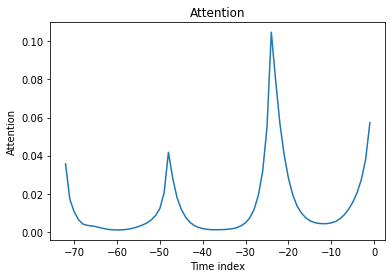

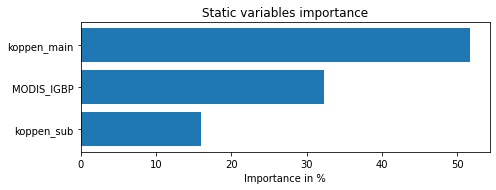

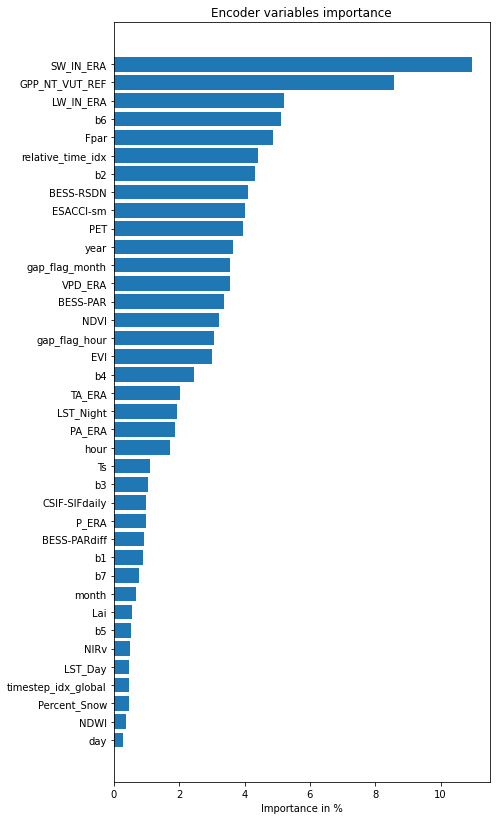

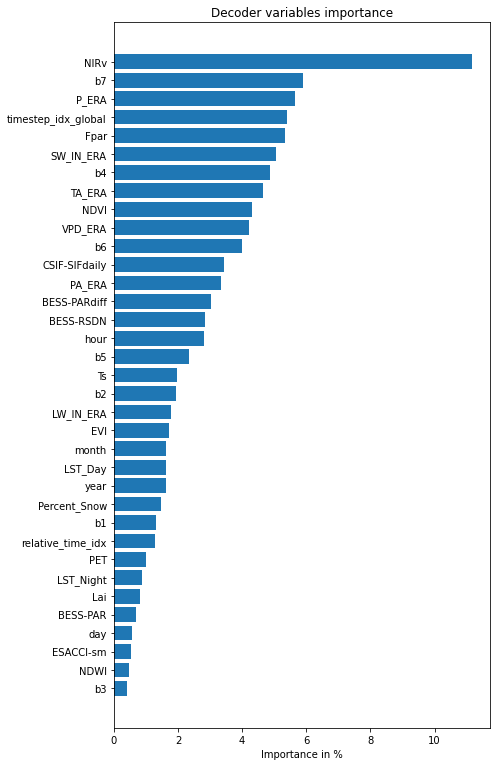

In [ ]:
interpretation = best_tft.interpret_output(val_raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

# Feature Importance - Single sample

In [ ]:
val_raw_predictions.keys()

dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [ ]:
new_tft_val_df.head(2)

timestep_idx_global site_id  GPP_NT_VUT_REF  timestep_idx_local  \
0               350640  AU-DaP         1.14587                   0   
1               350641  AU-DaP         1.14843                   1   

             datetime        date  year month day hour   TA_ERA  SW_IN_ERA  \
0 2010-01-01 00:00:00  2010-01-01  2010     1   1    0 24.47000    0.00000   
1 2010-01-01 01:00:00  2010-01-01  2010     1   1    1 23.79100    0.00000   

   LW_IN_ERA  VPD_ERA   P_ERA   PA_ERA     EVI    NDVI    NIRv      b1  \
0  416.09000  2.21000 0.00000 99.83900 0.56131 0.74435 0.31742 0.05892   
1  409.45000  1.01800 0.00000 99.81200 0.51946 0.71901 0.28217 0.06444   

       b2      b3      b4      b5      b6      b7 IGBP       lat      long  \
0 0.41990 0.02462 0.09036 0.41006 0.28214 0.12812  GRA -14.06330 131.31810   
1 0.39286 0.02698 0.08792 0.41804 0.30312 0.13154  GRA -14.06330 131.31810   

  koppen_sub koppen_main c3c4  c4_percent  BESS-PAR  BESS-PARdiff  BESS-RSDN  \
0          3           1   C3    97.83000 116.00000      63.00000  231.00000   
1          3           1   C3    97.83000 116.00000      63.00000  231.00000   

   CSIF-SIFdaily      PET        Ts  ESACCI-sm  MODIS_LC    NDWI  \
0        0.46453 -0.00719 301.48530    0.29788        10 0.08345   
1        0.46453 -0.00719 301.48530    0.29788        10 0.08345   

   Percent_Snow    Fpar     Lai   LST_Day  LST_Night MODIS_IGBP MODIS_PFT  \
0       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   
1       0.00000 0.59000 2.00000 309.50000  297.52000        GRA       GRA   

  gap_flag_hour gap_flag_month  
0           0.0            0.0  
1           0.0            0.0

In [ ]:
# First prediction
print(val_x['decoder_time_idx'][0]) # 350712
g_time_index = int(val_x['decoder_time_idx'][0])
print(f'datetime: {new_tft_val_df[new_tft_val_df["timestep_idx_global"]==350712]["datetime"].unique()[0]}')

tensor([350712])
datetime: 2010-01-04T00:00:00.000000000


torch.Size([216600, 1, 1, 72])

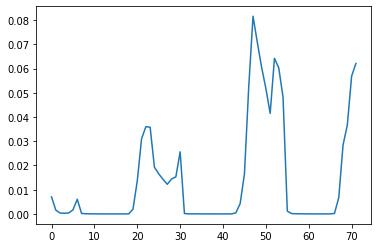

In [ ]:
plt.plot(val_raw_predictions['encoder_attention'][0].numpy()[0][0])
val_raw_predictions['encoder_attention'].shape

In [ ]:
start_time_index = g_time_index-72
encoder_attention_168 = val_raw_predictions['encoder_attention'][0].numpy()[0][0]
idx_time_attention_list = [["index", "time_index", "year", "month", "day","hour", "encoder_attention"]]

for index, attention in enumerate(encoder_attention_168):
  month = int(new_tft_val_df[new_tft_val_df['timestep_idx_global']==start_time_index]["month"].unique()[0])
  year = int(new_tft_val_df[new_tft_val_df['timestep_idx_global']==start_time_index]["year"].unique()[0])
  day = int(new_tft_val_df[new_tft_val_df['timestep_idx_global']==start_time_index]["day"].unique()[0])
  hour = int(new_tft_val_df[new_tft_val_df['timestep_idx_global']==start_time_index]["hour"].unique()[0])

  idx_time_attention_list += [[index, start_time_index, year, month, day, hour, attention]]
  start_time_index += 1

idx_time_attention = pd.DataFrame(idx_time_attention_list[1:], columns=idx_time_attention_list[0])
idx_time_attention
idx_time_attention.to_csv("sample_attention_datatime.csv")

In [ ]:
idx_time_attention

index  time_index  year  month  day  hour  encoder_attention
0       0      350640  2010      1    1     0            0.00703
1       1      350641  2010      1    1     1            0.00156
2       2      350642  2010      1    1     2            0.00038
3       3      350643  2010      1    1     3            0.00028
4       4      350644  2010      1    1     4            0.00038
..    ...         ...   ...    ...  ...   ...                ...
67     67      350707  2010      1    3    19            0.00670
68     68      350708  2010      1    3    20            0.02844
69     69      350709  2010      1    3    21            0.03671
70     70      350710  2010      1    3    22            0.05688
71     71      350711  2010      1    3    23            0.06211

[72 rows x 7 columns]

# Create Analysis Dataframe

In [ ]:
val_analysis_df = pd.DataFrame()

In [ ]:
val_df = new_tft_val_df

In [ ]:

val_raw_predictions.keys()

dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [ ]:
val_raw_predictions['prediction'] # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

tensor([[[-0.0107,  1.8916,  2.5317,  ...,  3.0738,  3.3624,  4.7355]],

        [[-0.5790,  1.2481,  1.8819,  ...,  2.3746,  2.7479,  4.1449]],

        [[-0.6259,  0.9221,  1.4906,  ...,  1.9331,  2.2943,  3.7283]],

        ...,

        [[-0.4045,  0.0658,  0.1772,  ...,  0.2583,  0.3249,  0.5306]],

        [[-0.3674,  0.0808,  0.1844,  ...,  0.2584,  0.3273,  0.5392]],

        [[-0.3633,  0.0918,  0.1886,  ...,  0.2484,  0.3137,  0.5198]]])

In [ ]:
group_site_id = {}
for idx, g in enumerate(val_x["groups"].unique()):
  group_site_id[int(g)] = val_df.site_id.unique()[idx]

group_site_id

{78: 'AU-DaP',
 79: 'AU-Emr',
 80: 'AU-Gin',
 81: 'AU-How',
 82: 'AU-Rig',
 83: 'CA-Ca1',
 84: 'CA-Gro',
 85: 'CH-Fru',
 86: 'CH-Oe2',
 87: 'DE-Hai',
 88: 'DK-Sor',
 89: 'FI-Hyy',
 90: 'FR-Aur',
 91: 'FR-Hes',
 92: 'GF-Guy',
 93: 'IT-SR2',
 94: 'NL-Loo',
 95: 'SE-Deg',
 96: 'SE-Nor',
 97: 'US-AR1',
 98: 'US-Bar',
 99: 'US-GLE',
 100: 'US-Mpj',
 101: 'US-NR1',
 102: 'US-Ses',
 103: 'US-Twt'}

In [ ]:
val_time_index_df = val_df[['timestep_idx_global','year','month','day','hour']]
val_time_index_df = val_time_index_df.drop_duplicates(keep='first')
val_time_index_df

timestep_idx_global  year month day hour
0                    350640  2010     1   1    0
1                    350641  2010     1   1    1
2                    350642  2010     1   1    2
3                    350643  2010     1   1    3
4                    350644  2010     1   1    4
...                     ...   ...   ...  ..  ...
134251               385699  2013    12  31   19
134252               385700  2013    12  31   20
134253               385701  2013    12  31   21
134254               385702  2013    12  31   22
134255               385703  2013    12  31   23

[40080 rows x 5 columns]

In [ ]:
val_site_IGBP = val_df[['site_id','MODIS_IGBP']].drop_duplicates().reset_index(drop=True)
val_site_IGBP
val_site_IGBP_dict = {}
for i in range(val_site_IGBP.shape[0]):
  val_site_IGBP_dict[val_site_IGBP['site_id'][i]] = val_site_IGBP['MODIS_IGBP'][i]
val_site_IGBP_dict

{'AU-DaP': 'GRA',
 'AU-Emr': 'GRA',
 'AU-Gin': 'SAV',
 'AU-How': 'SAV',
 'AU-Rig': 'GRA',
 'CA-Ca1': 'ENF',
 'CA-Gro': 'MF',
 'CH-Fru': 'MF',
 'CH-Oe2': 'CRO',
 'DE-Hai': 'DBF',
 'DK-Sor': 'CRO',
 'FI-Hyy': 'ENF',
 'FR-Aur': 'CRO',
 'FR-Hes': 'SAV',
 'GF-Guy': 'EBF',
 'IT-SR2': 'WAT',
 'NL-Loo': 'SAV',
 'SE-Deg': 'WSA',
 'SE-Nor': 'ENF',
 'US-AR1': 'GRA',
 'US-Bar': 'DBF',
 'US-GLE': 'GRA',
 'US-Mpj': 'GRA',
 'US-NR1': 'WSA',
 'US-Ses': 'OSH',
 'US-Twt': 'CRO'}

In [ ]:
val_df.columns

Index(['timestep_idx_global', 'site_id', 'GPP_NT_VUT_REF',
       'timestep_idx_local', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')

In [ ]:
val_site_koppen = val_df[['site_id','koppen_main','koppen_sub']].drop_duplicates().reset_index(drop=True)

val_site_koppen_main_dict = {}
val_site_koppen_sub_dict = {}

for i in range(val_site_koppen.shape[0]):
  val_site_koppen_main_dict[val_site_koppen['site_id'][i]] = val_site_koppen['koppen_main'][i]
  val_site_koppen_sub_dict[val_site_koppen['site_id'][i]] = val_site_koppen['koppen_sub'][i]
val_site_koppen_main_dict

{'AU-DaP': '1',
 'AU-Emr': '2',
 'AU-Gin': '3',
 'AU-How': '1',
 'AU-Rig': '3',
 'CA-Ca1': '3',
 'CA-Gro': '4',
 'CH-Fru': '4',
 'CH-Oe2': '4',
 'DE-Hai': '4',
 'DK-Sor': '4',
 'FI-Hyy': '4',
 'FR-Aur': '3',
 'FR-Hes': '3',
 'GF-Guy': '1',
 'IT-SR2': '3',
 'NL-Loo': '3',
 'SE-Deg': '4',
 'SE-Nor': '4',
 'US-AR1': '3',
 'US-Bar': '4',
 'US-GLE': '4',
 'US-Mpj': '2',
 'US-NR1': '4',
 'US-Ses': '2',
 'US-Twt': '3'}

In [ ]:
val_analysis_df["decoder_time_idx"] = [int(val_x['decoder_time_idx'][i]) for i in range(len(val_raw_predictions['prediction']))]
val_analysis_df["PRED_YEAR"] = [int([i for i in val_time_index_df[val_time_index_df['timestep_idx_global']==i]["year"]][0]) for i in val_analysis_df["decoder_time_idx"]]
val_analysis_df["PRED_MONTH"] = [int([i for i in val_time_index_df[val_time_index_df['timestep_idx_global']==i]["month"]][0]) for i in val_analysis_df["decoder_time_idx"]]
val_analysis_df["PRED_DAY"] = [int([i for i in val_time_index_df[val_time_index_df['timestep_idx_global']==i]["day"]][0]) for i in val_analysis_df["decoder_time_idx"]]
val_analysis_df["PRED_HOUR"] = [int([i for i in val_time_index_df[val_time_index_df['timestep_idx_global']==i]["hour"]][0]) for i in val_analysis_df["decoder_time_idx"]]
val_analysis_df["groups"] = [int(val_x['groups'][i]) for i in range(len(val_raw_predictions['prediction']))]
val_analysis_df["SITE_ID"] = [group_site_id[i] for i in val_analysis_df["groups"]]
val_analysis_df["MODIS_IGBP"] = [val_site_IGBP_dict[i] for i in val_analysis_df["SITE_ID"]]


In [261]:
val_analysis_df["KOPPEN"] = [val_site_koppen_main_dict[i] for i in val_analysis_df["SITE_ID"]]
val_analysis_df["KOPPEN_SUB"] = [val_site_koppen_sub_dict[i] for i in val_analysis_df["SITE_ID"]]

In [ ]:
val_analysis_df

decoder_time_idx  PRED_YEAR  PRED_MONTH  PRED_DAY  PRED_HOUR  groups  \
0                 350712       2010           1         4          0      78   
1                 350713       2010           1         4          1      78   
2                 350714       2010           1         4          2      78   
3                 350715       2010           1         4          3      78   
4                 350716       2010           1         4          4      78   
...                  ...        ...         ...       ...        ...     ...   
216595            360211       2011           2         3         19     103   
216596            360212       2011           2         3         20     103   
216597            360213       2011           2         3         21     103   
216598            360214       2011           2         3         22     103   
216599            360215       2011           2         3         23     103   

       SITE_ID MODIS_IGBP KOPPEN KOPPEN_SUB  
0       AU-DaP        GRA      3          1  
1       AU-DaP        GRA      3          1  
2       AU-DaP        GRA      3          1  
3       AU-DaP        GRA      3          1  
4       AU-DaP        GRA      3          1  
...        ...        ...    ...        ...  
216595  US-Twt        CRO      8          3  
216596  US-Twt        CRO      8          3  
216597  US-Twt        CRO      8          3  
216598  US-Twt        CRO      8          3  
216599  US-Twt        CRO      8          3  

[216600 rows x 10 columns]

# BRING BACK TRUE GPP TO DF

In [ ]:
val_analysis_df = val_analysis_df.drop(["decoder_target"], axis=1)

In [ ]:
# RFR predicted GPP
# val_analysis_df["decoder_target"] = [float(val_x["decoder_target"][i]) for i in range(len(val_raw_predictions['prediction']))] # When not replacing with predicted value, use this code
val_analysis_df["RFR_pred"] = [float(val_x["decoder_target"][i]) for i in range(len(val_raw_predictions['prediction']))]

In [ ]:
new_tft_val_df_true_GPP

true_GPP_dict = {}

for i in range(new_tft_val_df_true_GPP.shape[0]):
  true_GPP_dict[(new_tft_val_df_true_GPP['timestep_idx_global'][i],
                new_tft_val_df_true_GPP['site_id'][i])] = new_tft_val_df_true_GPP['GPP_NT_VUT_REF'][i]

In [ ]:
true_GPP_assign = []
for i in range(val_analysis_df.shape[0]):
  tuple_timestep_site = (val_analysis_df['decoder_time_idx'][i], val_analysis_df['SITE_ID'][i])
  if tuple_timestep_site in true_GPP_dict.keys():
    true_GPP_assign += [true_GPP_dict[tuple_timestep_site]]
  else:
    true_GPP_assign += ["NA"]
    print("NA")
true_GPP_assign

val_analysis_df["GPP_TRUE"] = true_GPP_assign

In [ ]:
len(val_raw_predictions["prediction"])

216600

In [ ]:
for idx, q in enumerate([0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]):
  val_analysis_df["PRED_Q_"+str(q)] = [float(i[0][idx]) for i in val_raw_predictions['prediction']]
  val_analysis_df["LOSS_Q_"+str(q)] = [(float(val_analysis_df["GPP_TRUE"][k]) - float(i[0][idx])) for k, i in enumerate(val_raw_predictions['prediction'])]
  val_analysis_df["LOSS_ABS_Q_"+str(q)] = [abs(float(val_analysis_df["GPP_TRUE"][k]) - float(i[0][idx])) for k, i in enumerate(val_raw_predictions['prediction'])]
  # val_analysis_df["LOSS_Q_"+str(q)] = [(float(val_x["decoder_target"][k]) - float(i[0][idx])) for k, i in enumerate(val_raw_predictions['prediction'])]
  # val_analysis_df["LOSS_ABS_Q_"+str(q)] = [abs(float(val_x["decoder_target"][k]) - float(i[0][idx])) for k, i in enumerate(val_raw_predictions['prediction'])]


In [ ]:
val_analysis_df

decoder_time_idx            datetime  PRED_YEAR  PRED_MONTH  PRED_DAY  \
0                 350712 2010-01-04 00:00:00       2010           1         4   
1                 350713 2010-01-04 01:00:00       2010           1         4   
2                 350714 2010-01-04 02:00:00       2010           1         4   
3                 350715 2010-01-04 03:00:00       2010           1         4   
4                 350716 2010-01-04 04:00:00       2010           1         4   
...                  ...                 ...        ...         ...       ...   
216595            360211 2011-02-03 19:00:00       2011           2         3   
216596            360212 2011-02-03 20:00:00       2011           2         3   
216597            360213 2011-02-03 21:00:00       2011           2         3   
216598            360214 2011-02-03 22:00:00       2011           2         3   
216599            360215 2011-02-03 23:00:00       2011           2         3   

        PRED_HOUR  groups SITE_ID MODIS_IGBP KOPPEN KOPPEN_SUB  PRED_Q_0.5  \
0               0      78  AU-DaP        GRA      3          1     2.84548   
1               1      78  AU-DaP        GRA      3          1     2.11414   
2               2      78  AU-DaP        GRA      3          1     1.66948   
3               3      78  AU-DaP        GRA      3          1     1.55289   
4               4      78  AU-DaP        GRA      3          1     1.95440   
...           ...     ...     ...        ...    ...        ...         ...   
216595         19     103  US-Twt        CRO      8          3     0.21516   
216596         20     103  US-Twt        CRO      8          3     0.20185   
216597         21     103  US-Twt        CRO      8          3     0.21412   
216598         22     103  US-Twt        CRO      8          3     0.21595   
216599         23     103  US-Twt        CRO      8          3     0.21230   

        LOSS_Q_0.5  LOSS_ABS_Q_0.5  PRED_Q_0.02  LOSS_Q_0.02  LOSS_ABS_Q_0.02  \
0         -3.43090         3.43090     -0.01068     -0.57474          0.57474   
1         -2.70643         2.70643     -0.57902     -0.01328          0.01328   
2         -2.18306         2.18306     -0.62588      0.11229          0.11229   
3         -2.07313         2.07313     -0.65254      0.13230          0.13230   
4         -2.46576         2.46576     -0.40255     -0.10881          0.10881   
...            ...             ...          ...          ...              ...   
216595    -0.14030         0.14030     -0.49496      0.56981          0.56981   
216596    -0.27801         0.27801     -0.45558      0.37942          0.37942   
216597    -0.23933         0.23933     -0.40455      0.37933          0.37933   
216598    -0.34162         0.34162     -0.36741      0.24174          0.24174   
216599    -0.41143         0.41143     -0.36335      0.16422          0.16422   

        PRED_Q_0.1  LOSS_Q_0.1  LOSS_ABS_Q_0.1  PRED_Q_0.25  LOSS_Q_0.25  \
0          1.89162    -2.47704         2.47704      2.53172     -3.11713   
1          1.24807    -1.84037         1.84037      1.88191     -2.47421   
2          0.92213    -1.43572         1.43572      1.49065     -2.00423   
3          0.88294    -1.40319         1.40319      1.34621     -1.86645   
4          1.16470    -1.67606         1.67606      1.74805     -2.25941   
...            ...         ...             ...          ...          ...   
216595    -0.00172     0.07658         0.07658      0.14370     -0.06884   
216596     0.02845    -0.10460         0.10460      0.15357     -0.22972   
216597     0.06583    -0.09105         0.09105      0.17724     -0.20246   
216598     0.08079    -0.20646         0.20646      0.18440     -0.31007   
216599     0.09176    -0.29089         0.29089      0.18856     -0.38769   

        LOSS_ABS_Q_0.25  PRED_Q_0.75  LOSS_Q_0.75  LOSS_ABS_Q_0.75  \
0               3.11713      3.07376     -3.65917          3.65917   
1               2.47421      2.37463     -2.96692          2.96692   
2 

In [ ]:
val_analysis_df.columns

Index(['decoder_time_idx', 'datetime', 'PRED_YEAR', 'PRED_MONTH', 'PRED_DAY',
       'PRED_HOUR', 'groups', 'SITE_ID', 'MODIS_IGBP', 'KOPPEN', 'KOPPEN_SUB',
       'PRED_Q_0.5', 'LOSS_Q_0.5', 'LOSS_ABS_Q_0.5', 'PRED_Q_0.02',
       'LOSS_Q_0.02', 'LOSS_ABS_Q_0.02', 'PRED_Q_0.1', 'LOSS_Q_0.1',
       'LOSS_ABS_Q_0.1', 'PRED_Q_0.25', 'LOSS_Q_0.25', 'LOSS_ABS_Q_0.25',
       'PRED_Q_0.75', 'LOSS_Q_0.75', 'LOSS_ABS_Q_0.75', 'PRED_Q_0.9',
       'LOSS_Q_0.9', 'LOSS_ABS_Q_0.9', 'PRED_Q_0.98', 'LOSS_Q_0.98',
       'LOSS_ABS_Q_0.98', 'GPP_TRUE'],
      dtype='object')

In [ ]:
val_analysis_df = val_analysis_df[['decoder_time_idx','datetime',
       'PRED_YEAR', 'PRED_MONTH', 'PRED_DAY', 'PRED_HOUR',
       'groups', 'SITE_ID', 'MODIS_IGBP', 'KOPPEN', 'KOPPEN_SUB', 'GPP_TRUE',
       'PRED_Q_0.5', 'LOSS_Q_0.5','LOSS_ABS_Q_0.5', #'decoder_target', 
       'PRED_Q_0.02', 'LOSS_Q_0.02', 'LOSS_ABS_Q_0.02',
       'PRED_Q_0.1', 'LOSS_Q_0.1', 'LOSS_ABS_Q_0.1', 'PRED_Q_0.25',
       'LOSS_Q_0.25', 'LOSS_ABS_Q_0.25',  'PRED_Q_0.75', 'LOSS_Q_0.75', 'LOSS_ABS_Q_0.75',
       'PRED_Q_0.9', 'LOSS_Q_0.9', 'LOSS_ABS_Q_0.9', 'PRED_Q_0.98',
       'LOSS_Q_0.98', 'LOSS_ABS_Q_0.98',]]

In [ ]:
val_analysis_df.head(5)

decoder_time_idx            datetime  PRED_YEAR  PRED_MONTH  PRED_DAY  \
0            350712 2010-01-04 00:00:00       2010           1         4   
1            350713 2010-01-04 01:00:00       2010           1         4   
2            350714 2010-01-04 02:00:00       2010           1         4   
3            350715 2010-01-04 03:00:00       2010           1         4   
4            350716 2010-01-04 04:00:00       2010           1         4   

   PRED_HOUR  groups SITE_ID MODIS_IGBP KOPPEN KOPPEN_SUB  GPP_TRUE  \
0          0      78  AU-DaP        GRA      3          1  -0.58542   
1          1      78  AU-DaP        GRA      3          1  -0.59230   
2          2      78  AU-DaP        GRA      3          1  -0.51358   
3          3      78  AU-DaP        GRA      3          1  -0.52024   
4          4      78  AU-DaP        GRA      3          1  -0.51136   

   PRED_Q_0.5  LOSS_Q_0.5  LOSS_ABS_Q_0.5  PRED_Q_0.02  LOSS_Q_0.02  \
0     2.84548    -3.43090         3.43090     -0.01068     -0.57474   
1     2.11414    -2.70643         2.70643     -0.57902     -0.01328   
2     1.66948    -2.18306         2.18306     -0.62588      0.11229   
3     1.55289    -2.07313         2.07313     -0.65254      0.13230   
4     1.95440    -2.46576         2.46576     -0.40255     -0.10881   

   LOSS_ABS_Q_0.02  PRED_Q_0.1  LOSS_Q_0.1  LOSS_ABS_Q_0.1  PRED_Q_0.25  \
0          0.57474     1.89162    -2.47704         2.47704      2.53172   
1          0.01328     1.24807    -1.84037         1.84037      1.88191   
2          0.11229     0.92213    -1.43572         1.43572      1.49065   
3          0.13230     0.88294    -1.40319         1.40319      1.34621   
4          0.10881     1.16470    -1.67606         1.67606      1.74805   

   LOSS_Q_0.25  LOSS_ABS_Q_0.25  PRED_Q_0.75  LOSS_Q_0.75  LOSS_ABS_Q_0.75  \
0     -3.11713          3.11713      3.07376     -3.65917          3.65917   
1     -2.47421          2.47421      2.37463     -2.96692          2.96692   
2     -2.00423          2.00423      1.93314     -2.44672          2.44672   
3     -1.86645          1.86645      1.77939     -2.29963          2.29963   
4     -2.25941          2.25941      2.22374     -2.73510          2.73510   

   PRED_Q_0.9  LOSS_Q_0.9  LOSS_ABS_Q_0.9  PRED_Q_0.98  LOSS_Q_0.98  \
0     3.36239    -3.94780         3.94780      4.73553     -5.32095   
1     2.74789    -3.34019         3.34019      4.14489     -4.73719   
2     2.29426    -2.80785         2.80785      3.72831     -4.24190   
3     2.13772    -2.65796         2.65796      3.57103     -4.09128   
4     2.56639    -3.07775         3.07775      3.94125     -4.45261   

   LOSS_ABS_Q_0.98  
0          5.32095  
1          4.73719  
2          4.24190  
3          4.09128  
4          4.45261

In [ ]:
val_analysis_df.to_csv("val_analysis_df_hybrid_march27.csv", index=False)
val_analysis_df.to_pickle("val_analysis_df_hybrid_march27.pkl")

In [ ]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
val_analysis_df = pd.read_pickle("val_analysis_df_hybrid_march27.pkl")

In [ ]:
val_analysis_df

decoder_time_idx            datetime  PRED_YEAR  PRED_MONTH  PRED_DAY  \
0                 350712 2010-01-04 00:00:00       2010           1         4   
1                 350713 2010-01-04 01:00:00       2010           1         4   
2                 350714 2010-01-04 02:00:00       2010           1         4   
3                 350715 2010-01-04 03:00:00       2010           1         4   
4                 350716 2010-01-04 04:00:00       2010           1         4   
...                  ...                 ...        ...         ...       ...   
216595            360211 2011-02-03 19:00:00       2011           2         3   
216596            360212 2011-02-03 20:00:00       2011           2         3   
216597            360213 2011-02-03 21:00:00       2011           2         3   
216598            360214 2011-02-03 22:00:00       2011           2         3   
216599            360215 2011-02-03 23:00:00       2011           2         3   

        PRED_HOUR  groups SITE_ID MODIS_IGBP KOPPEN KOPPEN_SUB  GPP_TRUE  \
0               0      78  AU-DaP        GRA      3          1  -0.58542   
1               1      78  AU-DaP        GRA      3          1  -0.59230   
2               2      78  AU-DaP        GRA      3          1  -0.51358   
3               3      78  AU-DaP        GRA      3          1  -0.52024   
4               4      78  AU-DaP        GRA      3          1  -0.51136   
...           ...     ...     ...        ...    ...        ...       ...   
216595         19     103  US-Twt        CRO      8          3   0.07485   
216596         20     103  US-Twt        CRO      8          3  -0.07615   
216597         21     103  US-Twt        CRO      8          3  -0.02521   
216598         22     103  US-Twt        CRO      8          3  -0.12567   
216599         23     103  US-Twt        CRO      8          3  -0.19913   

        PRED_Q_0.5  LOSS_Q_0.5  LOSS_ABS_Q_0.5  PRED_Q_0.02  LOSS_Q_0.02  \
0          2.84548    -3.43090         3.43090     -0.01068     -0.57474   
1          2.11414    -2.70643         2.70643     -0.57902     -0.01328   
2          1.66948    -2.18306         2.18306     -0.62588      0.11229   
3          1.55289    -2.07313         2.07313     -0.65254      0.13230   
4          1.95440    -2.46576         2.46576     -0.40255     -0.10881   
...            ...         ...             ...          ...          ...   
216595     0.21516    -0.14030         0.14030     -0.49496      0.56981   
216596     0.20185    -0.27801         0.27801     -0.45558      0.37942   
216597     0.21412    -0.23933         0.23933     -0.40455      0.37933   
216598     0.21595    -0.34162         0.34162     -0.36741      0.24174   
216599     0.21230    -0.41143         0.41143     -0.36335      0.16422   

        LOSS_ABS_Q_0.02  PRED_Q_0.1  LOSS_Q_0.1  LOSS_ABS_Q_0.1  PRED_Q_0.25  \
0               0.57474     1.89162    -2.47704         2.47704      2.53172   
1               0.01328     1.24807    -1.84037         1.84037      1.88191   
2               0.11229     0.92213    -1.43572         1.43572      1.49065   
3               0.13230     0.88294    -1.40319         1.40319      1.34621   
4               0.10881     1.16470    -1.67606         1.67606      1.74805   
...                 ...         ...         ...             ...          ...   
216595          0.56981    -0.00172     0.07658         0.07658      0.14370   
216596          0.37942     0.02845    -0.10460         0.10460      0.15357   
216597          0.37933     0.06583    -0.09105         0.09105      0.17724   
216598          0.24174     0.08079    -0.20646         0.20646      0.18440   
216599          0.16422     0.09176    -0.29089         0.29089      0.18856   

        LOSS_Q_0.25  LOSS_ABS_Q_0.25  PRED_Q_0.75  LOSS_Q_0.75  \
0          -3.11713          3.11713      3.07376     -3.65917   
1          -2.47421          2.47421      2.37463     -2.96692   
2          -2.00423          2.00423      1.93314 

In [209]:
val_analysis_summary_df= val_analysis_df.groupby(['SITE_ID','MODIS_IGBP','KOPPEN','KOPPEN_SUB']).mean()

In [210]:
val_analysis_summary_df.to_csv("val_analysis_summary_df_hybrid_march27.csv", index=False)
val_analysis_summary_df

decoder_time_idx  PRED_YEAR  PRED_MONTH  \
SITE_ID MODIS_IGBP KOPPEN KOPPEN_SUB                                            
AU-DaP  GRA        3      1               355055.50000 2010.00000     6.57182   
AU-Emr  GRA        6      2               367688.95338 2011.51447     5.69775   
AU-Gin  SAV        8      3               370235.50000 2011.79008     5.85878   
AU-How  SAV        3      1               355055.50000 2010.00000     6.57182   
AU-Rig  GRA        14     3               363815.50000 2011.00000     6.57182   
CA-Ca1  ENF        15     3               355055.50000 2010.00000     6.57182   
CA-Gro  MF         26     4               355055.50000 2010.00000     6.57182   
CH-Fru  MF         26     4               356639.50000 2010.18232     6.55525   
CH-Oe2  CRO        26     4               355055.50000 2010.00000     6.57143   
DE-Hai  DBF        26     4               355922.57317 2010.07317     6.88720   
DK-Sor  CRO        26     4               355055.50000 2010.00000     6.57182   
FI-Hyy  ENF        27     4               355327.30000 2010.00000     6.94688   
FR-Aur  CRO        14     3               355055.50000 2010.00000     6.57182   
FR-Hes  SAV        15     3               390119.50000 2014.00000     6.57182   
GF-Guy  EBF        2      1               355055.50000 2010.00000     6.57182   
IT-SR2  WAT        8      3               381359.50000 2013.00000     6.57182   
NL-Loo  SAV        15     3               355055.50000 2010.00000     6.57182   
SE-Deg  WSA        27     4               355055.50000 2010.00000     6.57182   
SE-Nor  ENF        26     4               390119.50000 2014.00000     6.57182   
US-AR1  GRA        14     3               355055.50000 2010.00000     6.57182   
US-Bar  DBF        26     4               355021.60658 2010.00000     6.52665   
US-GLE  GRA        27     4               354838.13557 2010.00000     6.27114   
US-Mpj  GRA        7      2               355055.50000 2010.00000     6.57182   
US-NR1  WSA        27     4               355106.55202 2010.00000     6.64451   
US-Ses  OSH        5      2               355055.50000 2010.00000     6.57182   
US-Twt  CRO        8      3               355413.17500 2010.05312     6.43125   

                                      PRED_DAY  PRED_HOUR    groups  GPP_TRUE  \
SITE_ID MODIS_IGBP KOPPEN KOPPEN_SUB                                            
AU-DaP  GRA        3      1           15.83425   11.50000  78.00000   3.45764   
AU-Emr  GRA        6      2           15.76527   11.50000  79.00000   1.19184   
AU-Gin  SAV        8      3           16.00000   11.50000  80.00000   3.20218   
AU-How  SAV        3      1           15.83425   11.50000  81.00000   6.50639   
AU-Rig  GRA        14     3           15.83425   11.50000  82.00000   2.85840   
CA-Ca1  ENF        15     3           15.83425   11.50000  83.00000   5.01351   
CA-Gro  MF         26     4           15.83425   11.50000  84.00000   2.71289   
CH-Fru  MF         26     4           15.77624   11.50000  85.00000   5.01533   
CH-Oe2  CRO        26     4           15.78261   11.50000  86.00000   1.27807   
DE-Hai  DBF        26     4           15.58841   11.50000  87.00000   4.11827   
DK-Sor  CRO        26     4           15.83425   11.50000  88.00000   5.08215   
FI-Hyy  ENF        27     4           15.77812   11.50000  89.00000   2.88333   
FR-Aur  CRO        14     3           15.83425   11.50000  90.00000   3.98016   
FR-Hes  SAV        15     3           15.83425   11.50000  91.00000   6.00563   
GF-Guy  EBF        2      1           15.83425   11.50000  92.00000   9.35691   
IT-SR2  WAT        8      3           15.83425   11.50000  93.00000   7.17188   
NL-Loo  SAV        15     3           15.83425   11.50000  94.00000   4.34272   
SE-Deg  WSA        27     4           15.83425   11.50000  95.00000   0.53363   
SE-Nor  ENF        26     4           15.83425   11.50000  96.00000   3.82049   
US-AR1  GRA        14     3           15.83425   11.50000  97.00000 

In [ ]:
val_analysis_df[val_analysis_df['SITE_ID']=="AU-DaP"]['MODIS_IGBP'].unique()[0]

'GRA'

# Model Evaluation(Val)

In [211]:
def get_eval_metrics(y_true, y_pred, mask=None, p90_pred=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]
        if p90_pred is not None:
            p90_pred = p90_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
    mae = torch.mean((y_true - y_pred).abs())
    nse = nash_sutcliffe(y_true, y_pred)
    r2 = r2_score(y_true.numpy(), y_pred.numpy())
    p50_loss = numpy_normalised_quantile_loss(y_true, y_pred, 0.5)
    evals = {"rmse": rmse.item(), "mae": mae.item(), "nse": nse.item(), "r2": r2, "p50_loss": p50_loss.item()}

    if p90_pred is not None:
        p90_loss = numpy_normalised_quantile_loss(y_true, p90_pred, 0.9)
        evals["p90_loss"] = p90_loss.item()
    
    return evals

# Mask metrics for validation set
def masked_eval_metrics(dataloader, model):
    # Get y_true, y_pred, mask
    y_true = torch.cat([y[0] for x, y in iter(dataloader)]).reshape(-1)
    y_pred = model.predict(dataloader).reshape(-1)
    mask = torch.logical_not(torch.cat([x['decoder_cont'][:, :, -1].reshape(-1) for x, y in iter(dataloader)]))

    # Apply mask
    masked_y_true = y_true[mask.bool()]
    masked_y_pred = y_pred[mask.bool()]

    # Get masked RMSE, MAE, NSE
    masked_rmse = torch.sqrt(torch.mean((masked_y_true - masked_y_pred) ** 2))
    masked_mae = torch.mean((masked_y_true - masked_y_pred).abs())
    masked_nse = nash_sutcliffe(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())
    masked_r2 = r2_score(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())

    return masked_rmse, masked_mae, masked_nse, masked_r2

In [218]:
# Eval on Test set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)


In [262]:
val_analysis_df.columns

Index(['decoder_time_idx', 'datetime', 'PRED_YEAR', 'PRED_MONTH', 'PRED_DAY',
       'PRED_HOUR', 'groups', 'SITE_ID', 'MODIS_IGBP', 'KOPPEN', 'KOPPEN_SUB',
       'GPP_TRUE', 'PRED_Q_0.5', 'LOSS_Q_0.5', 'LOSS_ABS_Q_0.5', 'PRED_Q_0.02',
       'LOSS_Q_0.02', 'LOSS_ABS_Q_0.02', 'PRED_Q_0.1', 'LOSS_Q_0.1',
       'LOSS_ABS_Q_0.1', 'PRED_Q_0.25', 'LOSS_Q_0.25', 'LOSS_ABS_Q_0.25',
       'PRED_Q_0.75', 'LOSS_Q_0.75', 'LOSS_ABS_Q_0.75', 'PRED_Q_0.9',
       'LOSS_Q_0.9', 'LOSS_ABS_Q_0.9', 'PRED_Q_0.98', 'LOSS_Q_0.98',
       'LOSS_ABS_Q_0.98'],
      dtype='object')

In [242]:

mask = torch.logical_not(torch.cat([val_x['decoder_cont'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))

In [236]:
import tensorflow as tf

y_true = torch.from_numpy(np.array(val_analysis_df['GPP_TRUE']))
y_pred = torch.from_numpy(np.array(val_analysis_df['PRED_Q_0.5']))

# y_true = tf.convert_to_tensor(np.array(val_analysis_df['GPP_TRUE']))
# y_pred = tf.convert_to_tensor(np.array(val_analysis_df['PRED_Q_0.5']))

In [237]:
rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
mae = torch.mean((y_true - y_pred).abs())
nse = nash_sutcliffe(y_true, y_pred)
r2 = r2_score(y_true.numpy(), y_pred.numpy())

In [244]:
# # Apply mask
# masked_y_true = y_true[mask.bool()]
# masked_y_pred = y_pred[mask.bool()]

# # Get masked RMSE, MAE, NSE
# masked_rmse = torch.sqrt(torch.mean((masked_y_true - masked_y_pred) ** 2))
# masked_mae = torch.mean((masked_y_true - masked_y_pred).abs())
# masked_nse = nash_sutcliffe(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())
# masked_r2 = r2_score(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())


In [245]:
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'nse: {nse}')
print(f'r2: {r2}')

print(f'masked rmse: {""}')
print(f'masked rmse: {""}')
print(f'masked nse: {""}')
print(f'masked r2: {""}')

rmse: 3.9480040016734343
mae: 2.3641020257740157
nse: 0.7027880175504979
r2: 0.7027880175504979
masked rmse: 
masked rmse: 
masked nse: 
masked r2: 


# Visualization

In [ ]:
val_analysis_df

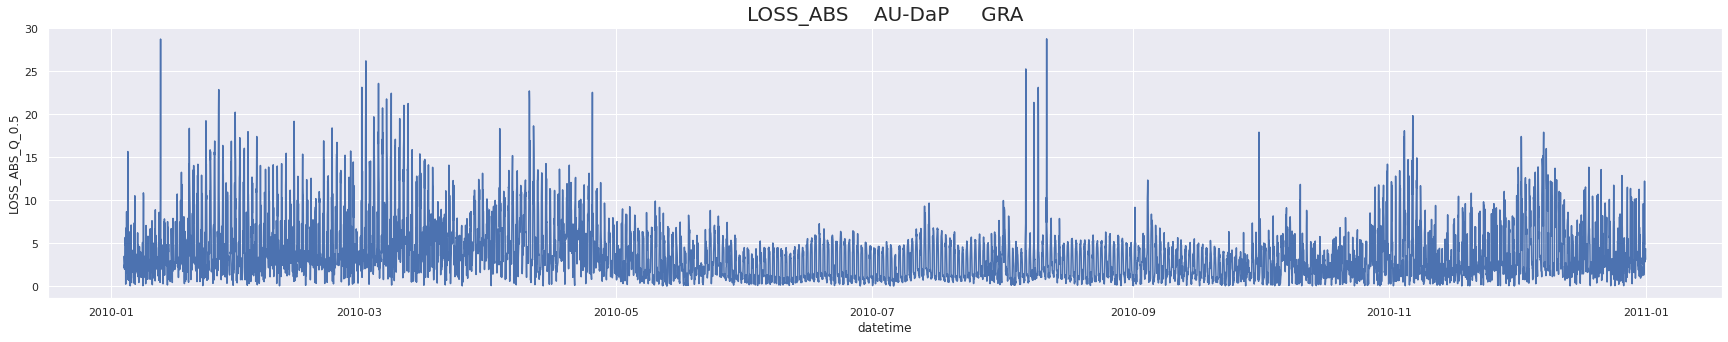

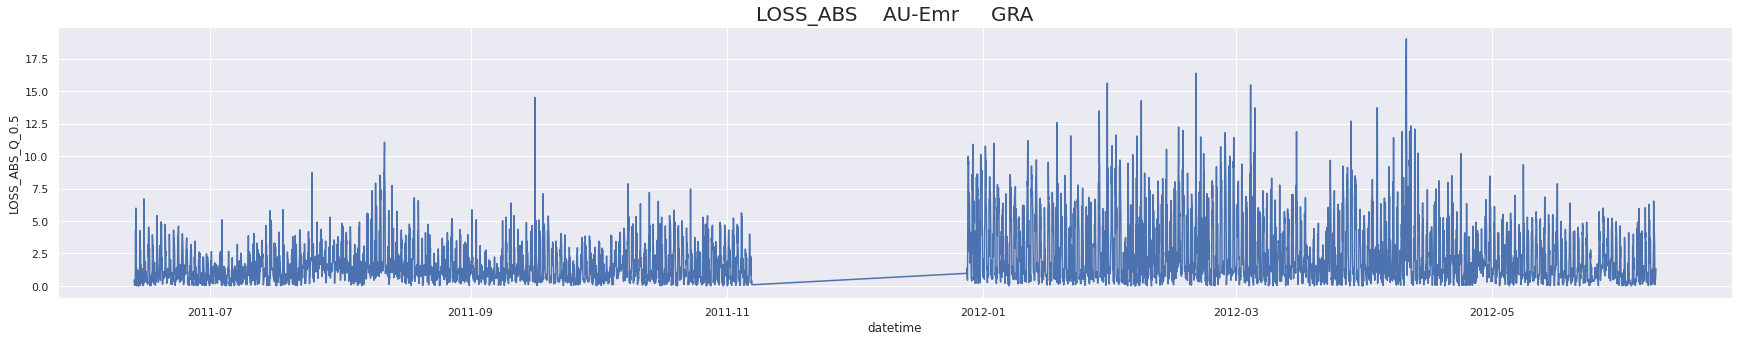

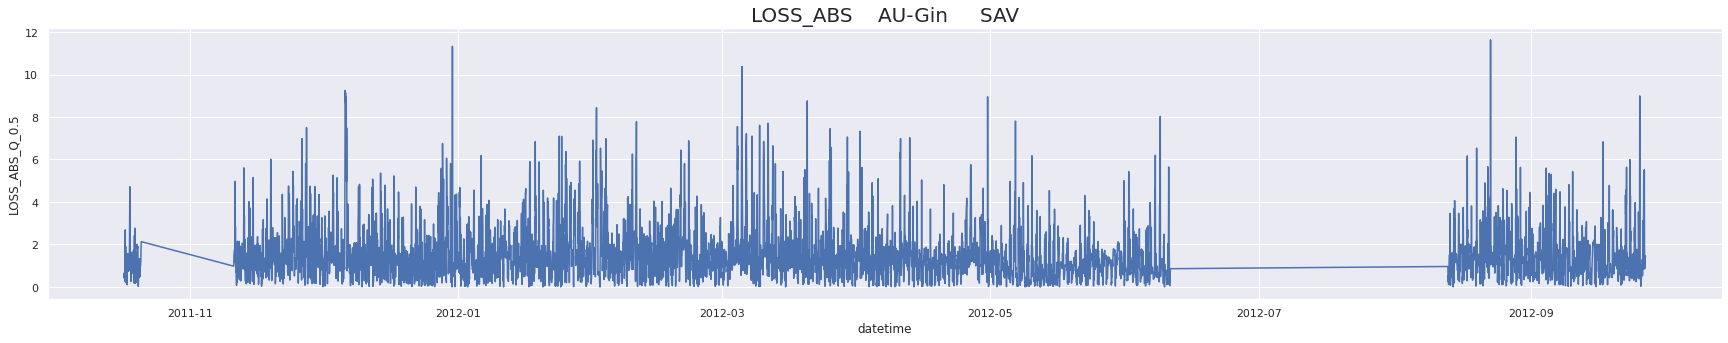

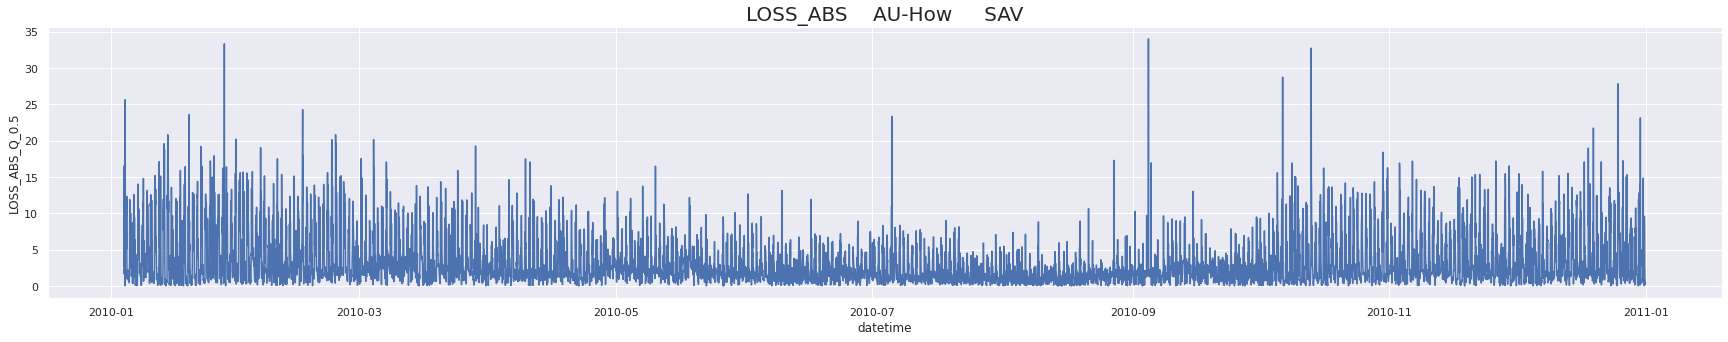

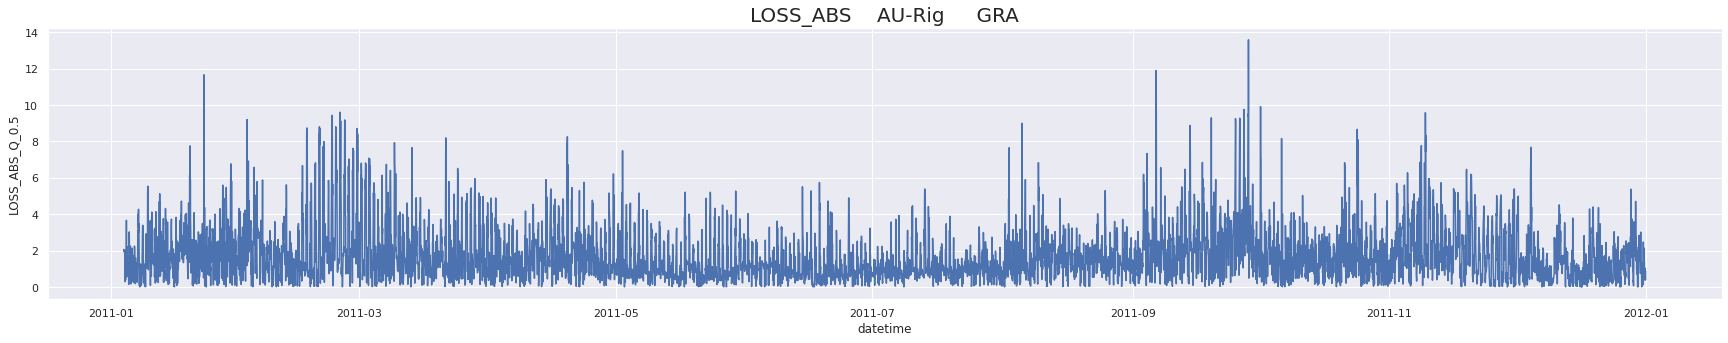

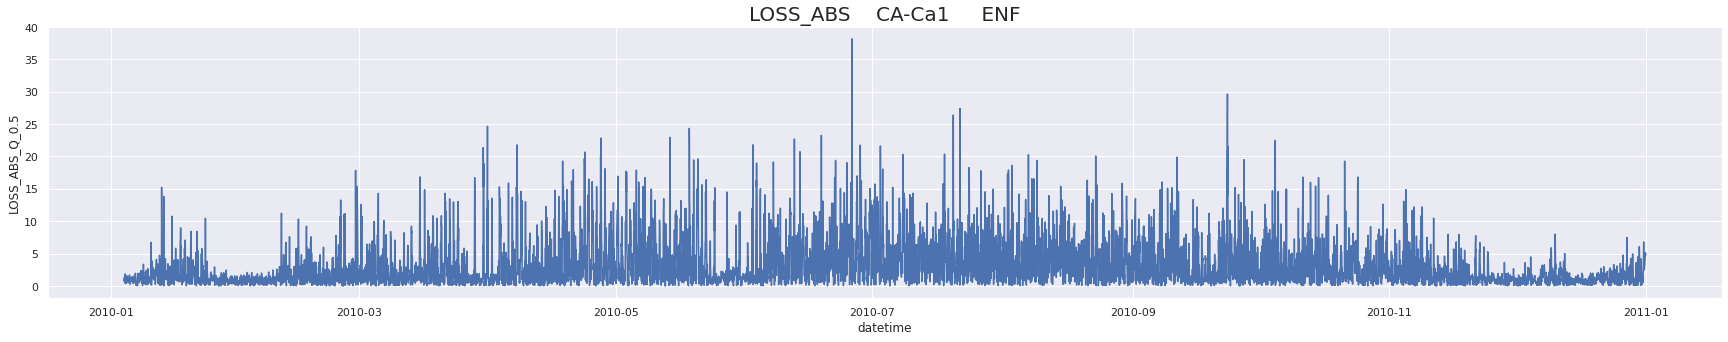

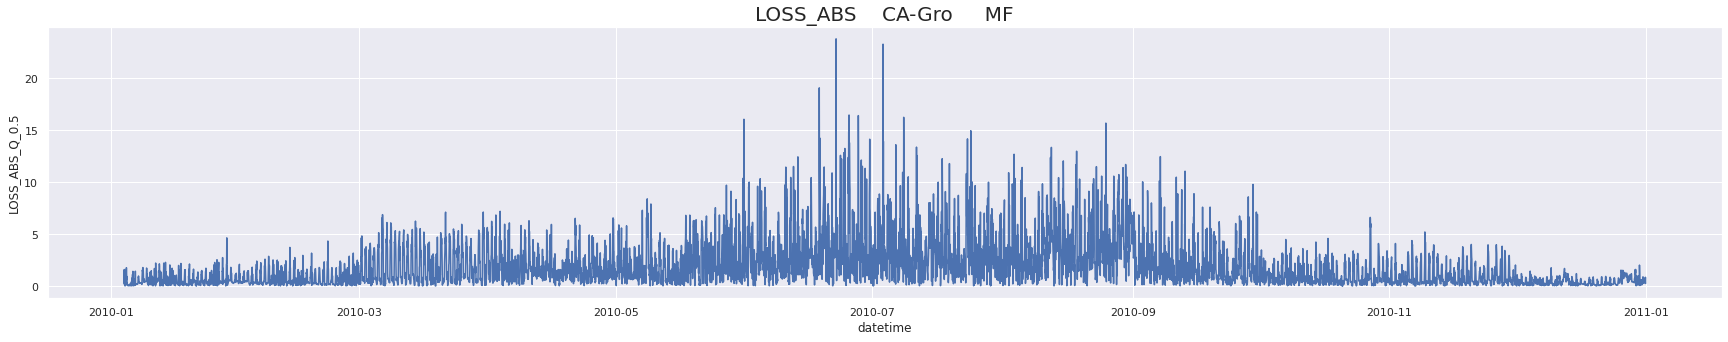

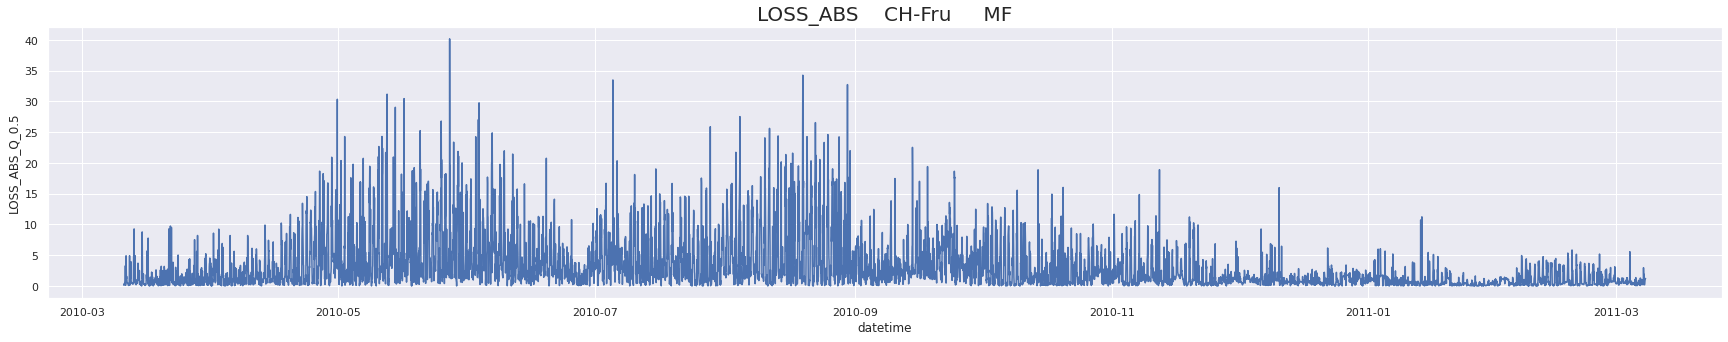

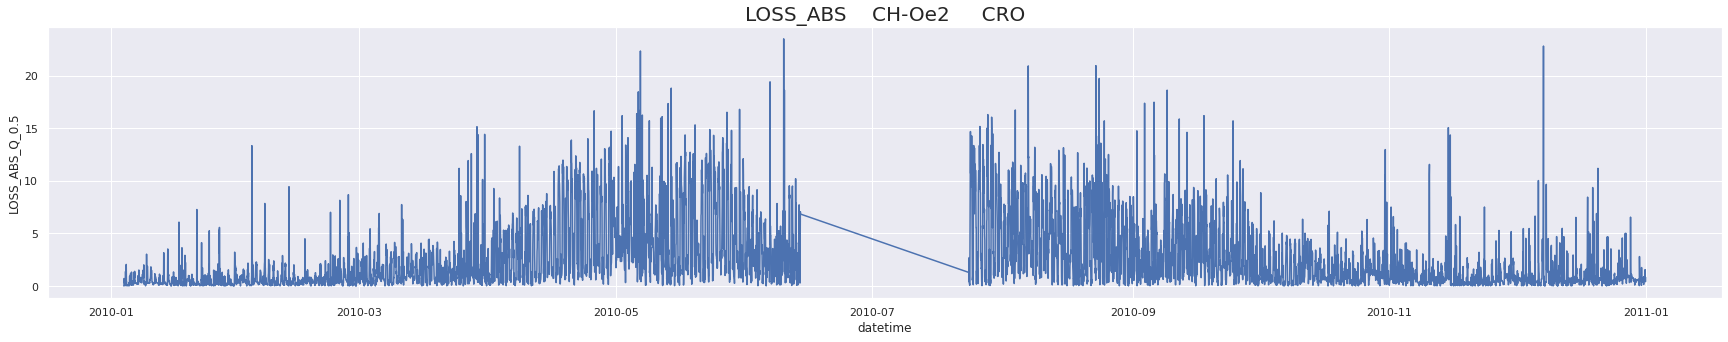

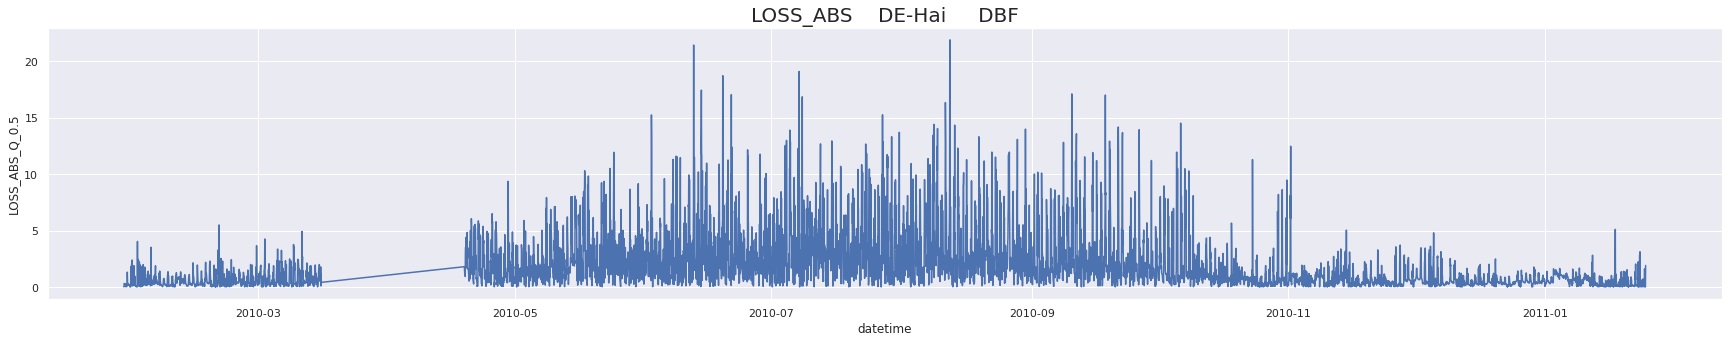

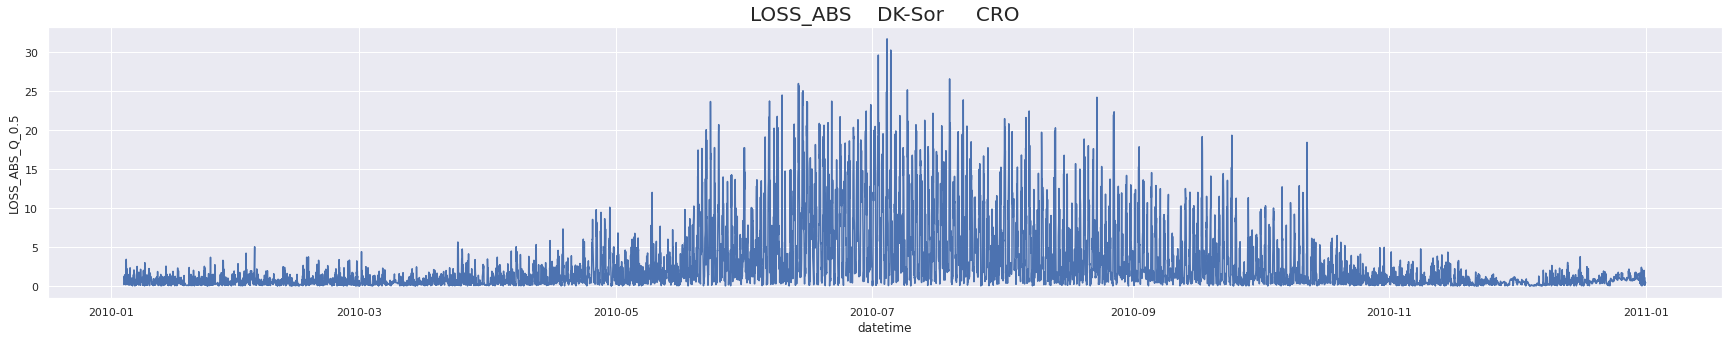

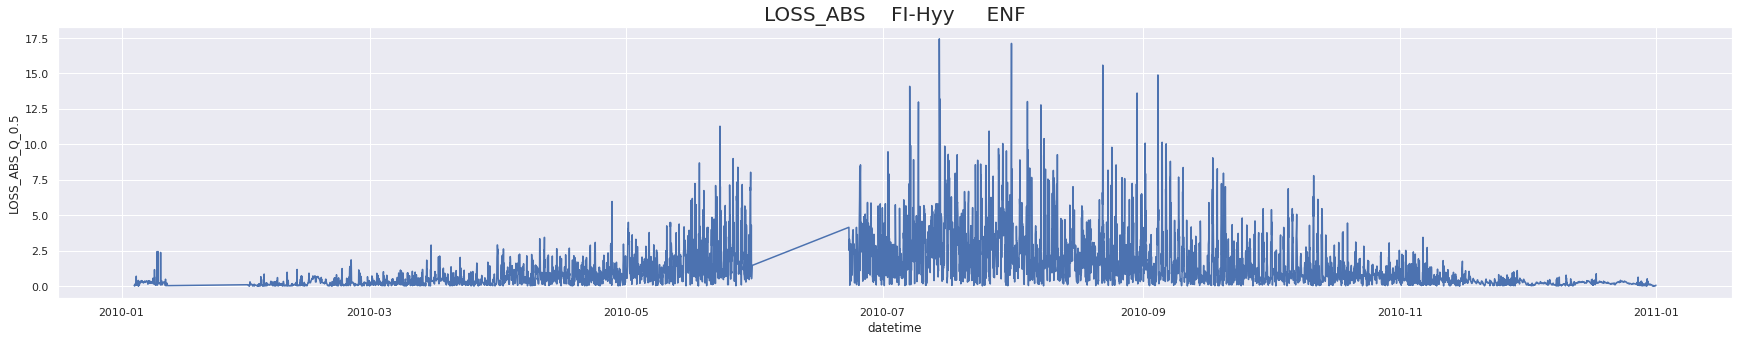

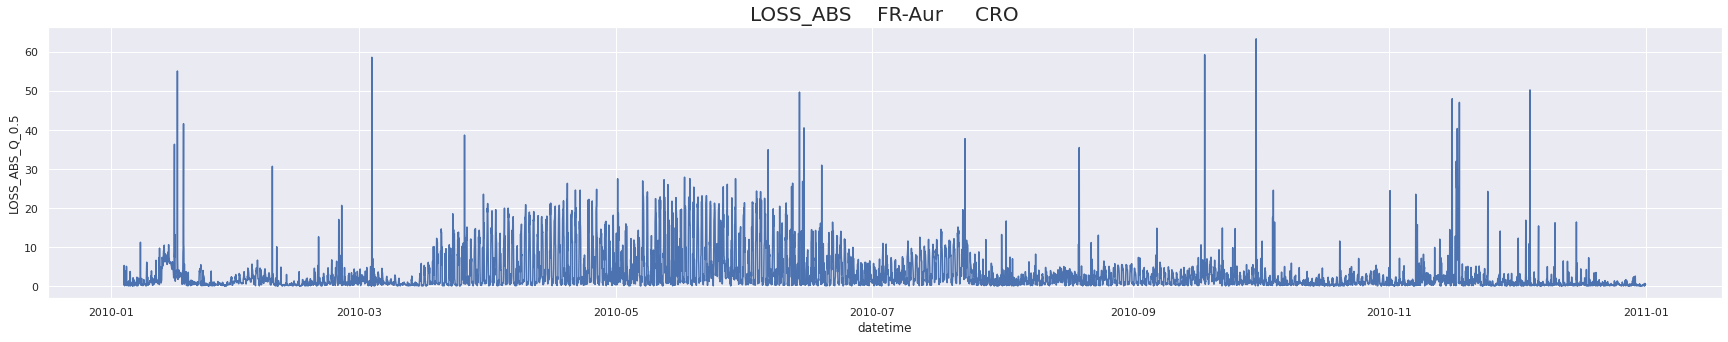

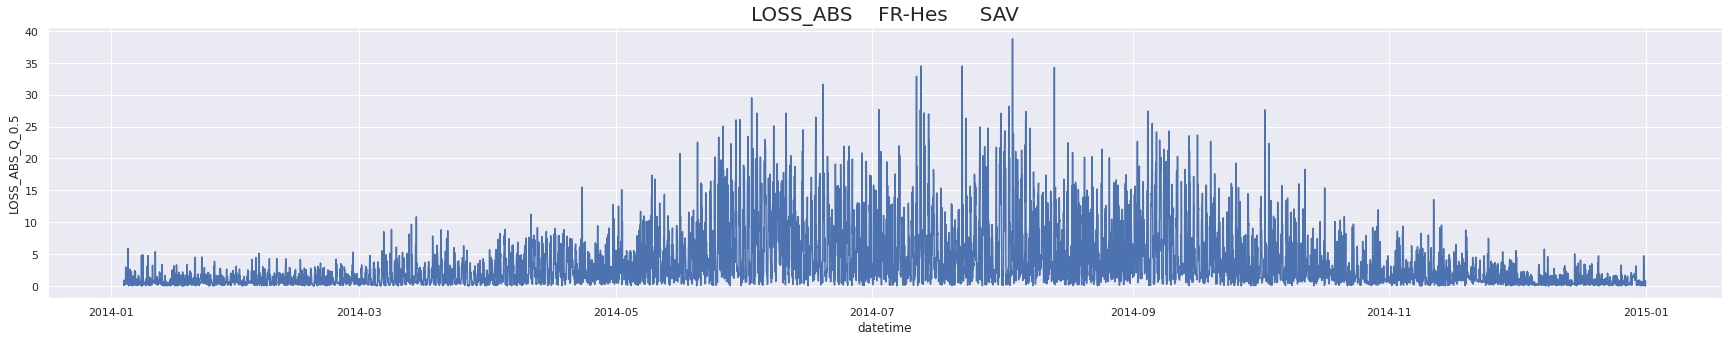

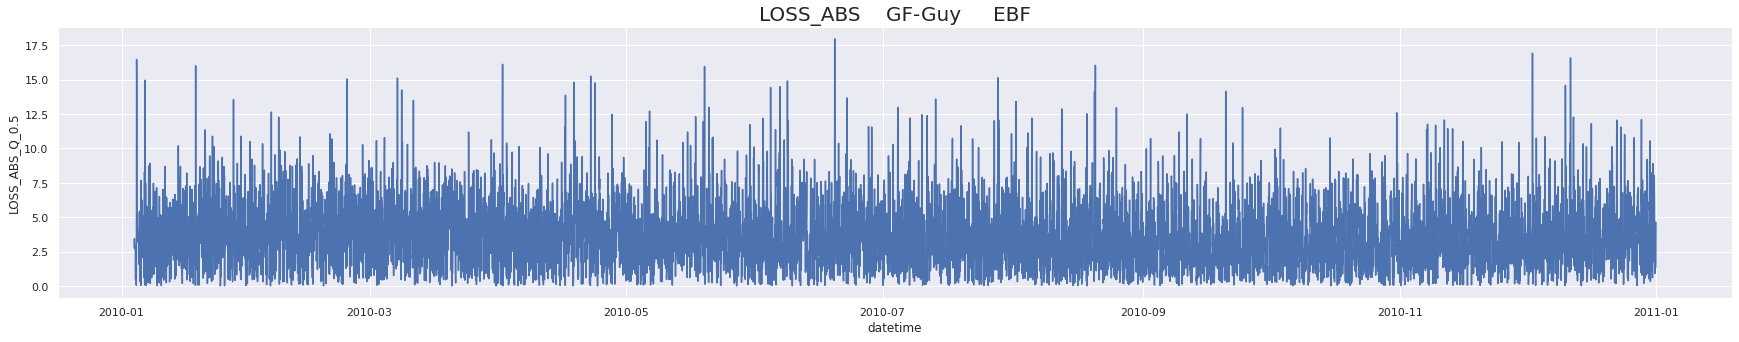

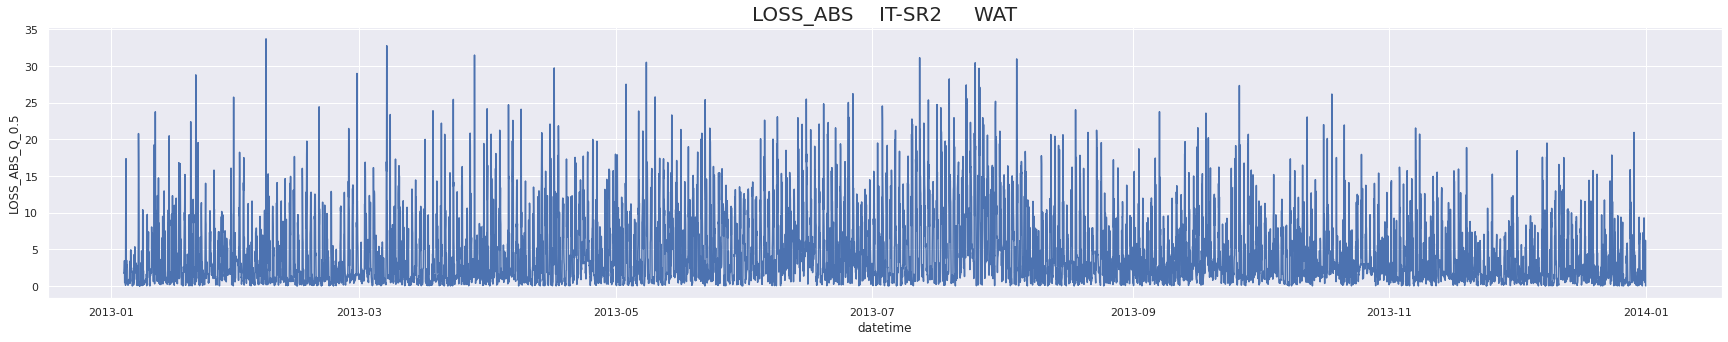

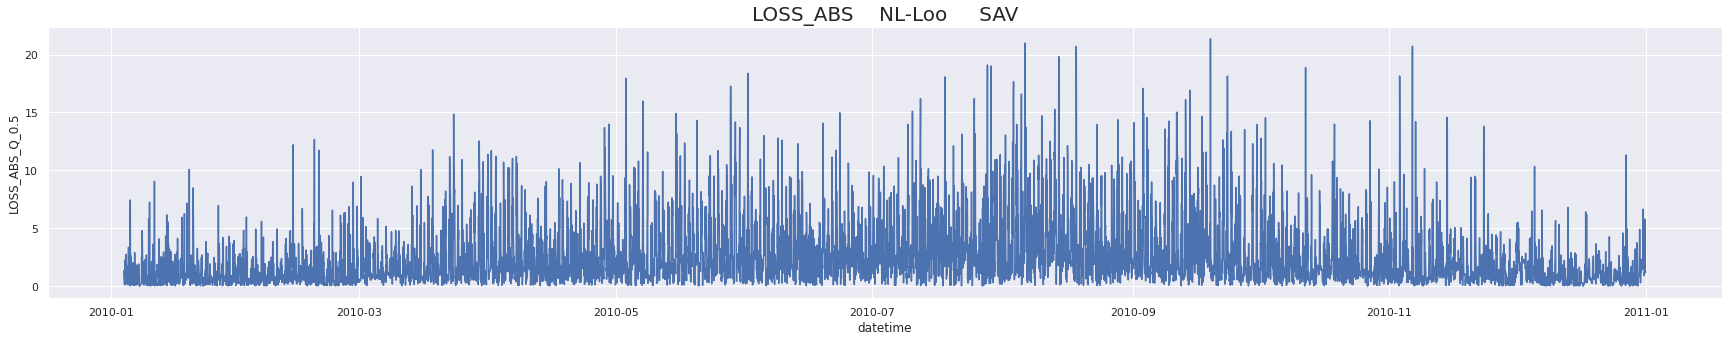

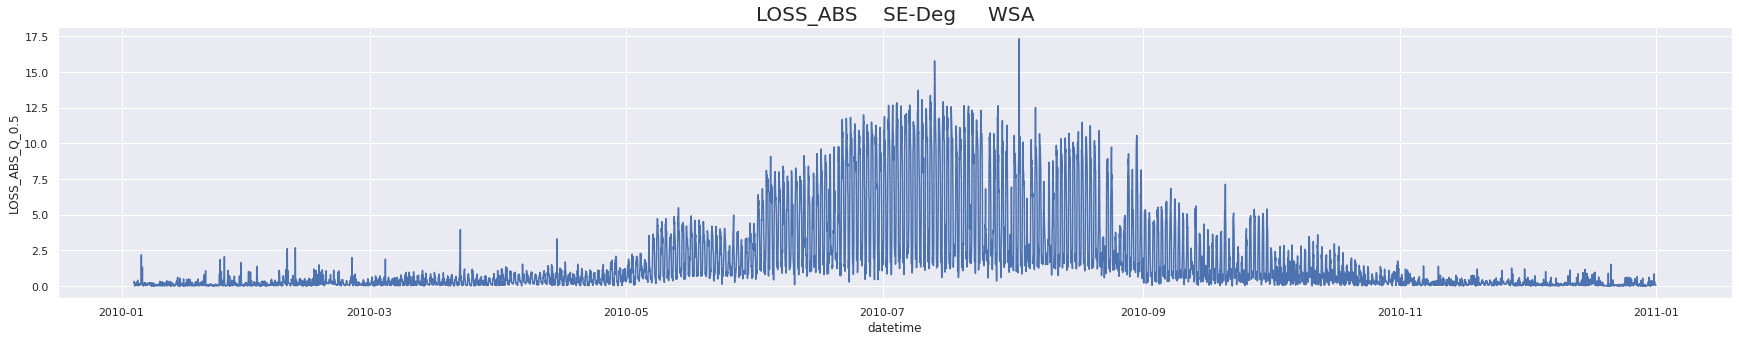

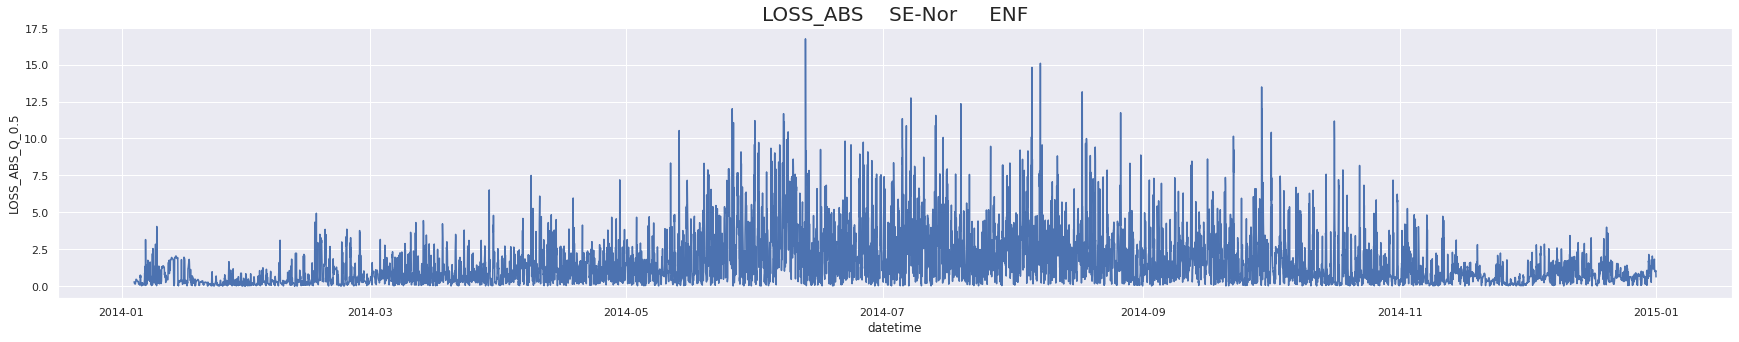

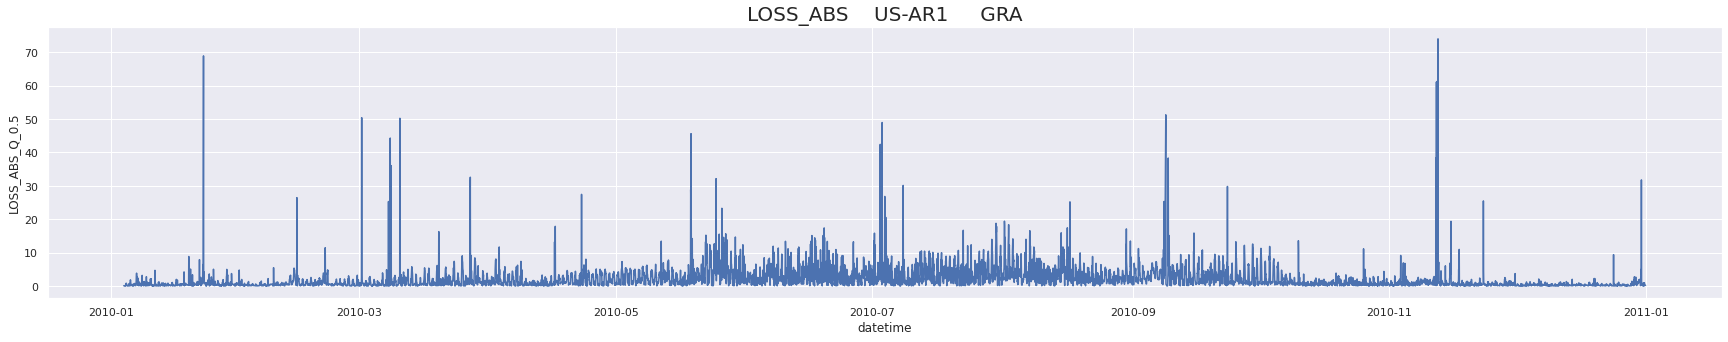

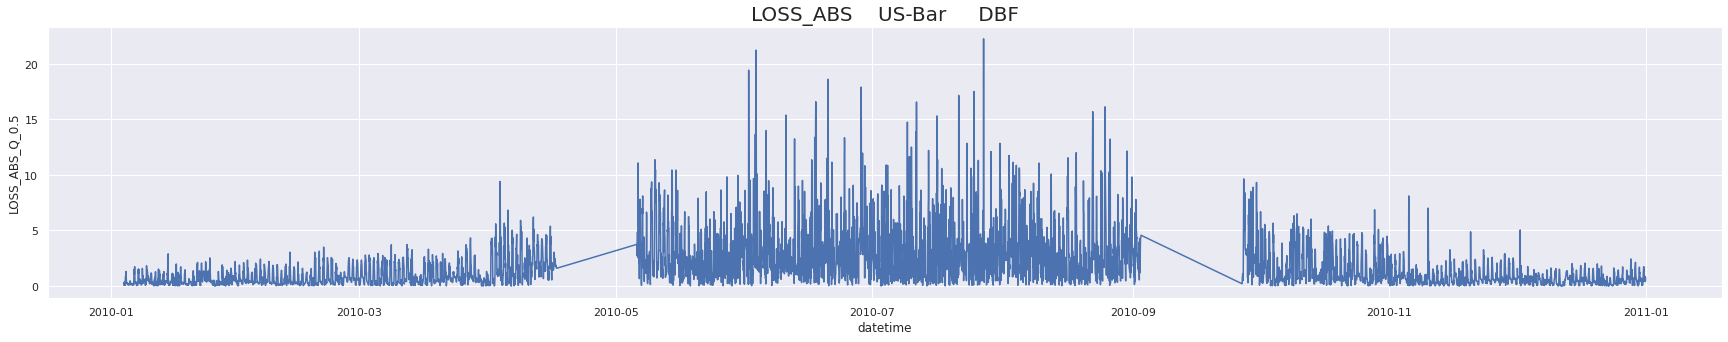

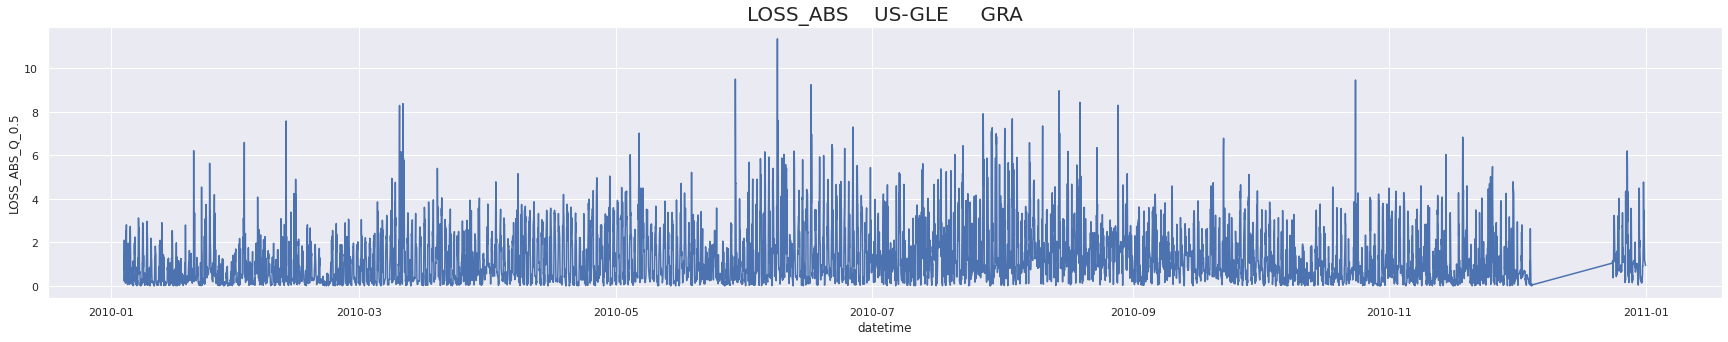

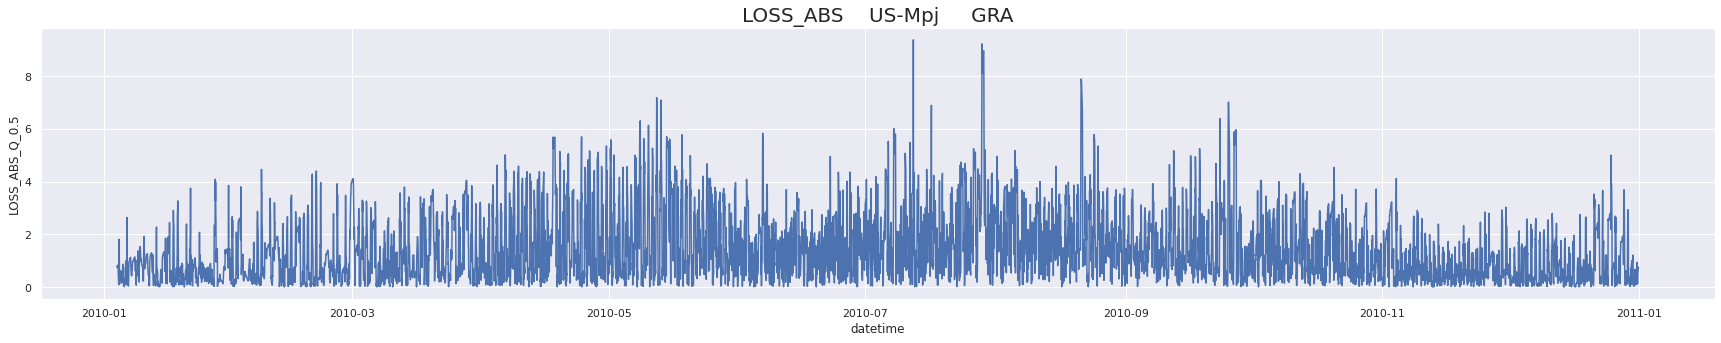

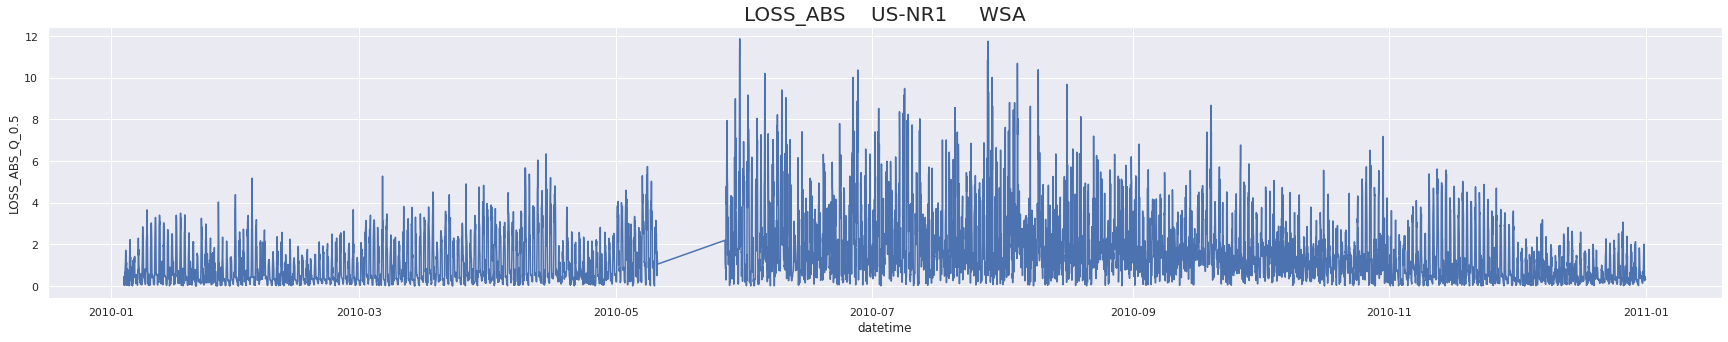

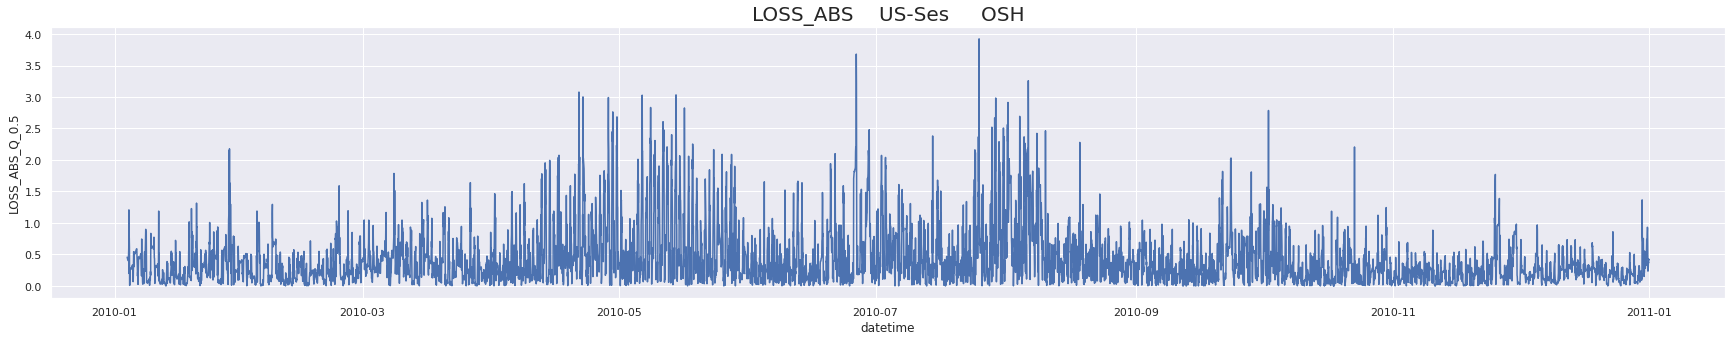

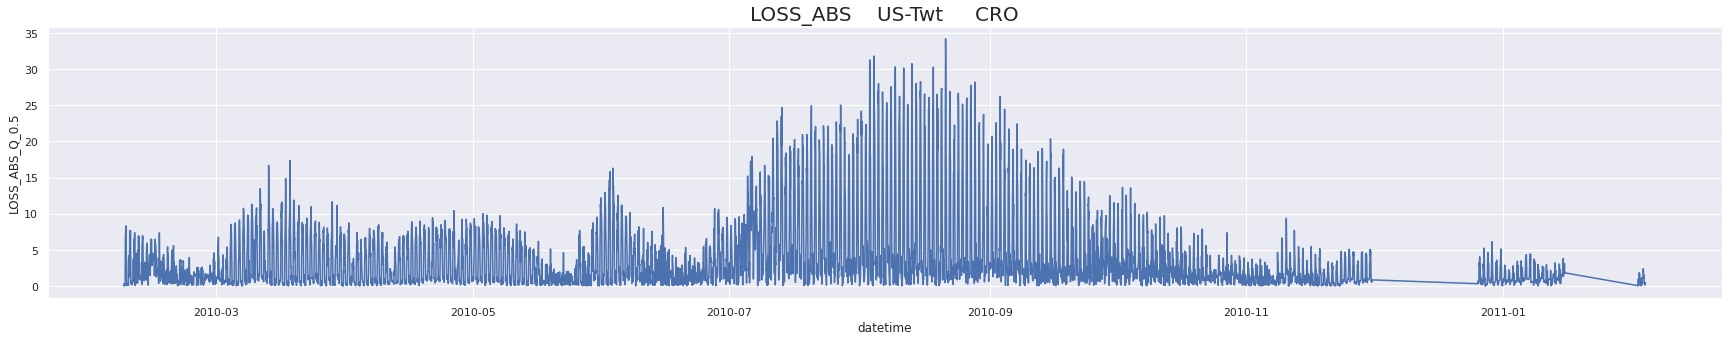

In [ ]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,5), })

for idx, i in enumerate(val_analysis_df['SITE_ID'].unique()):  
  plt.figure(idx)
  val_analysis_df_sub = val_analysis_df[val_analysis_df['SITE_ID'] == i]
  sns.lineplot(x="datetime", y="LOSS_ABS_Q_0.5",
             data=val_analysis_df_sub).set_title("LOSS_ABS    " + i + "     " + val_analysis_df[val_analysis_df['SITE_ID']==i]['MODIS_IGBP'].unique()[0], fontsize=20)         

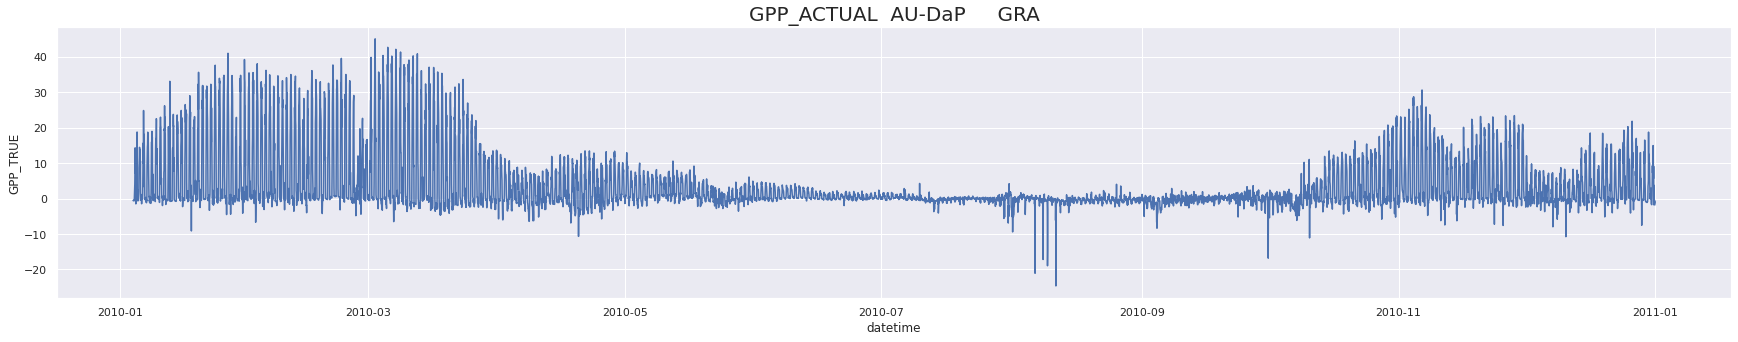

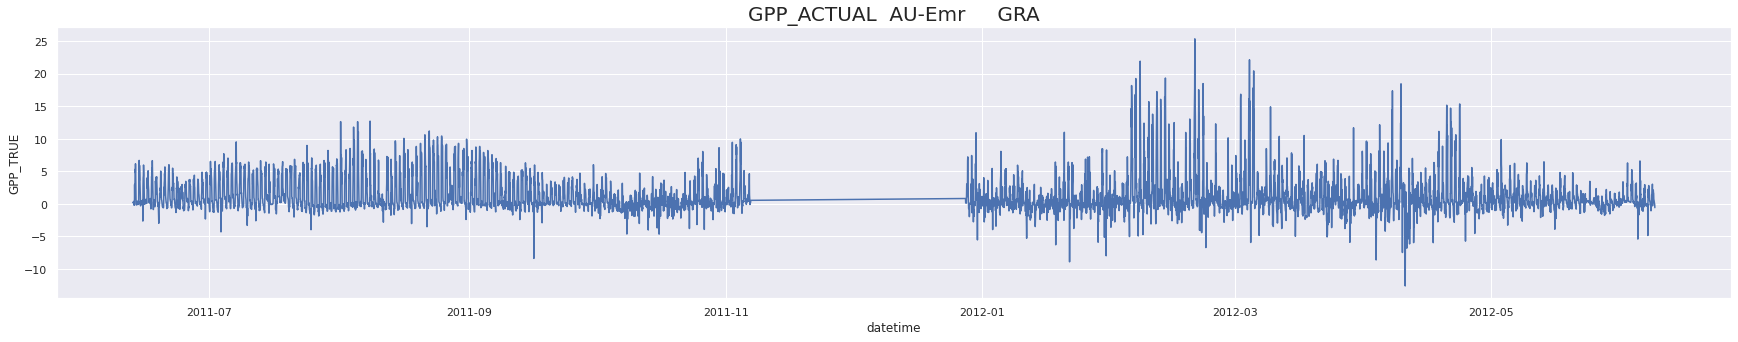

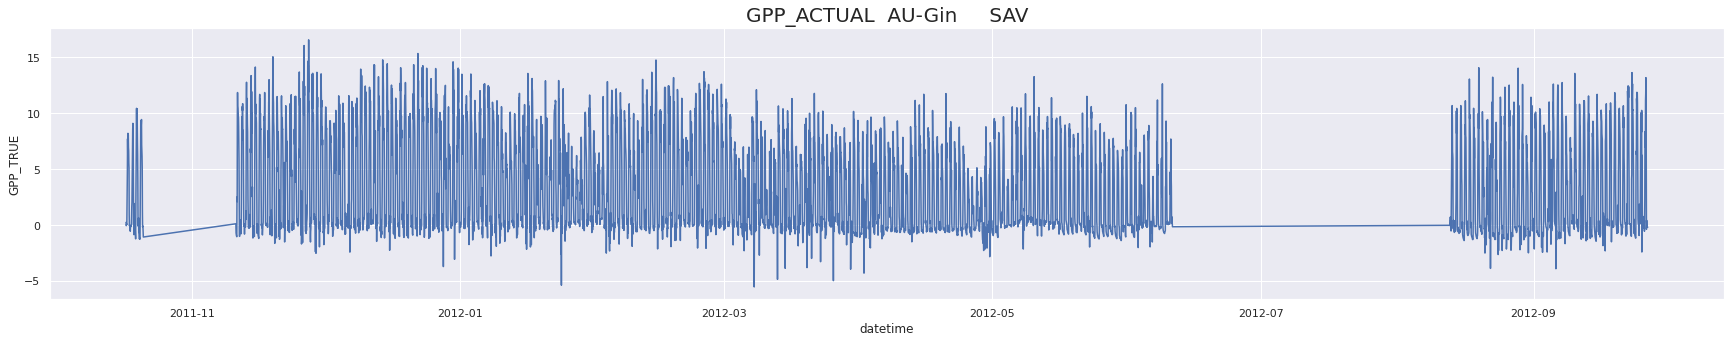

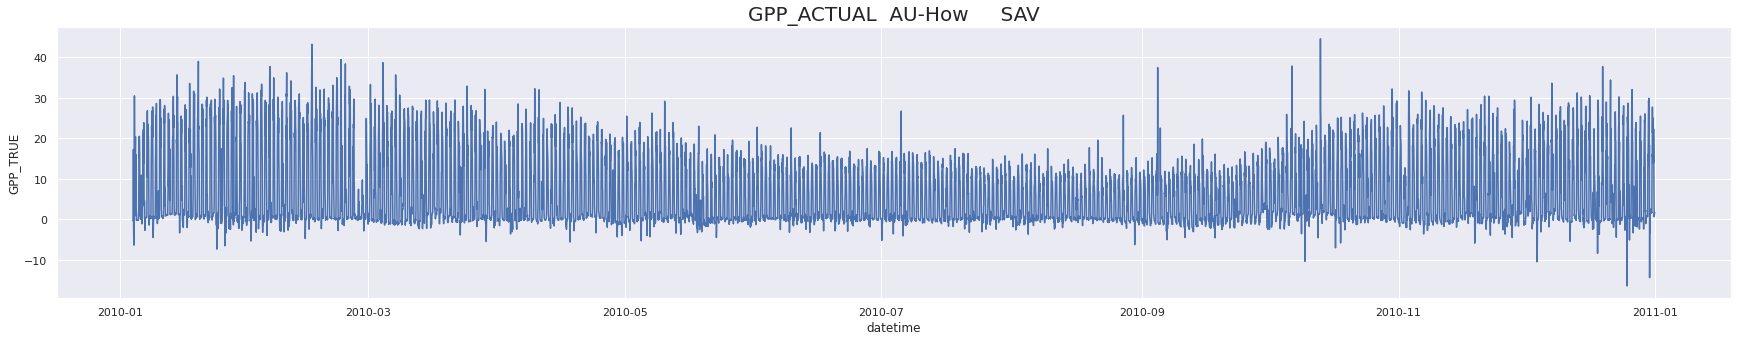

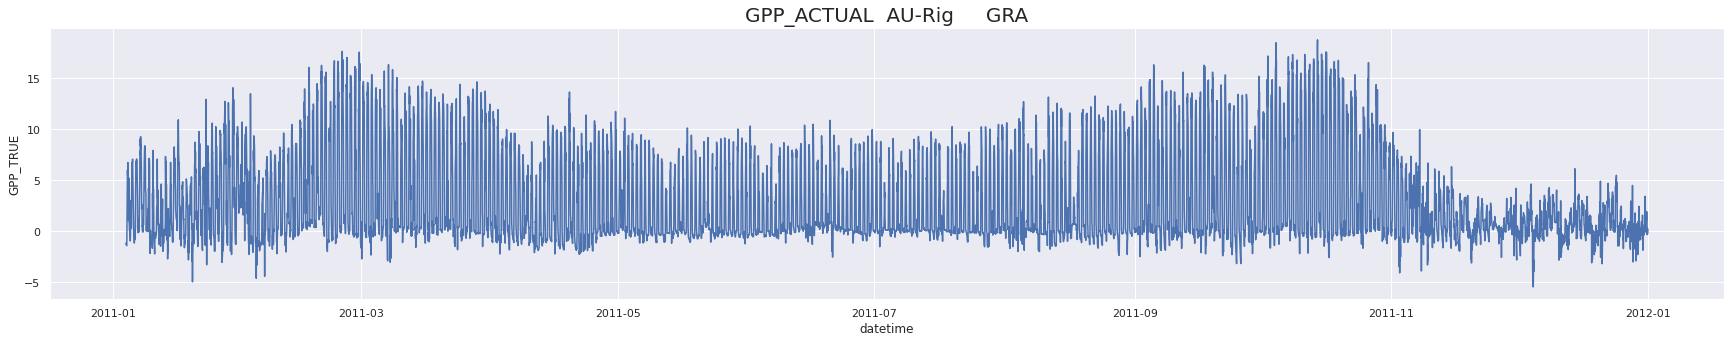

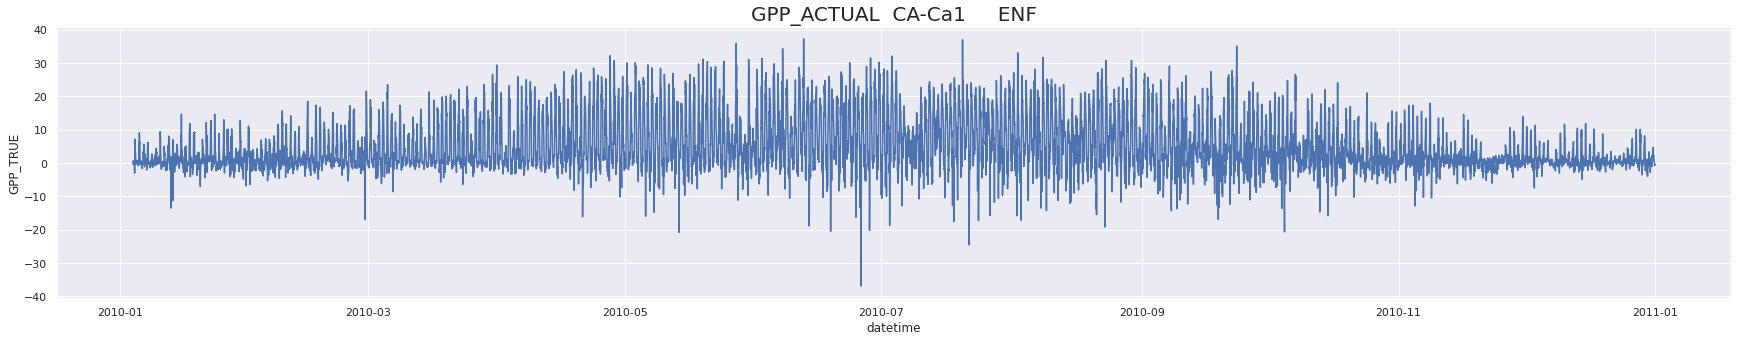

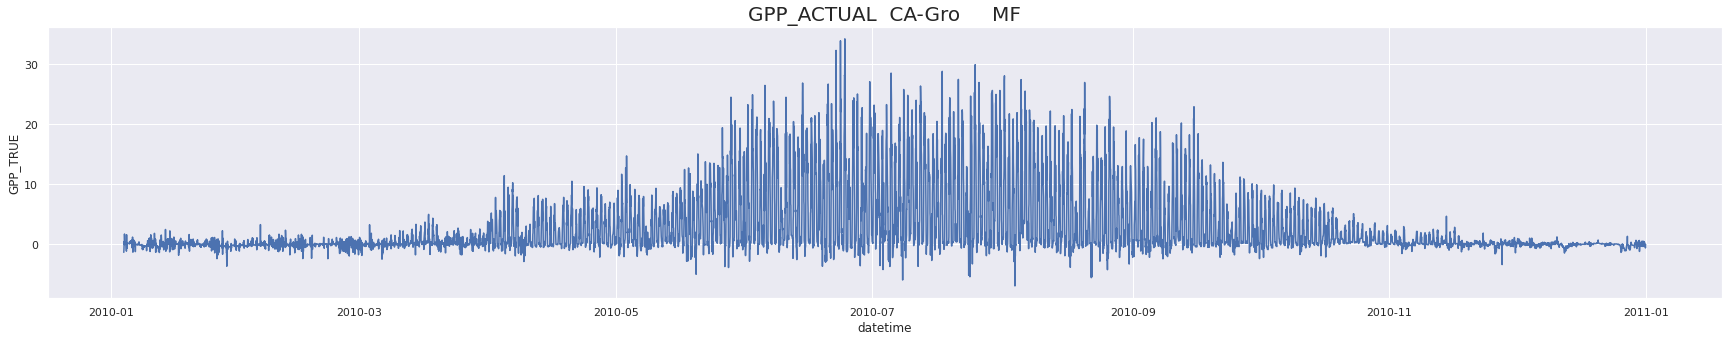

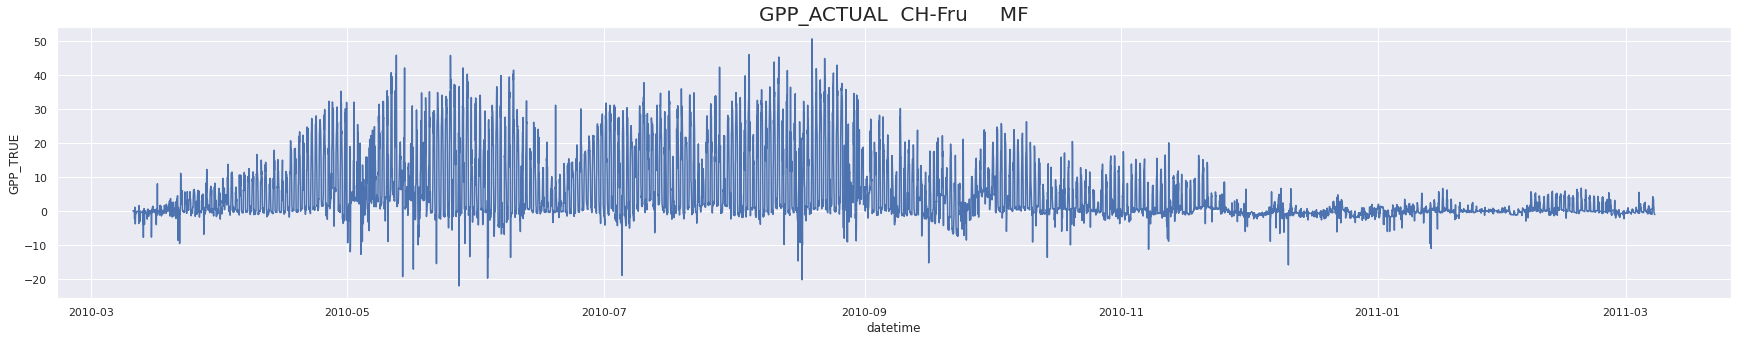

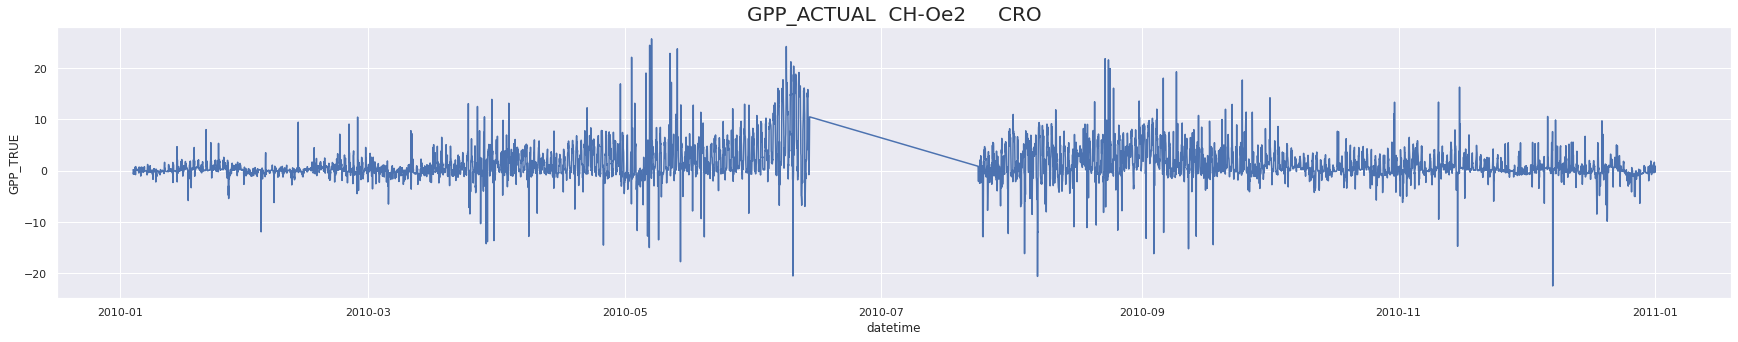

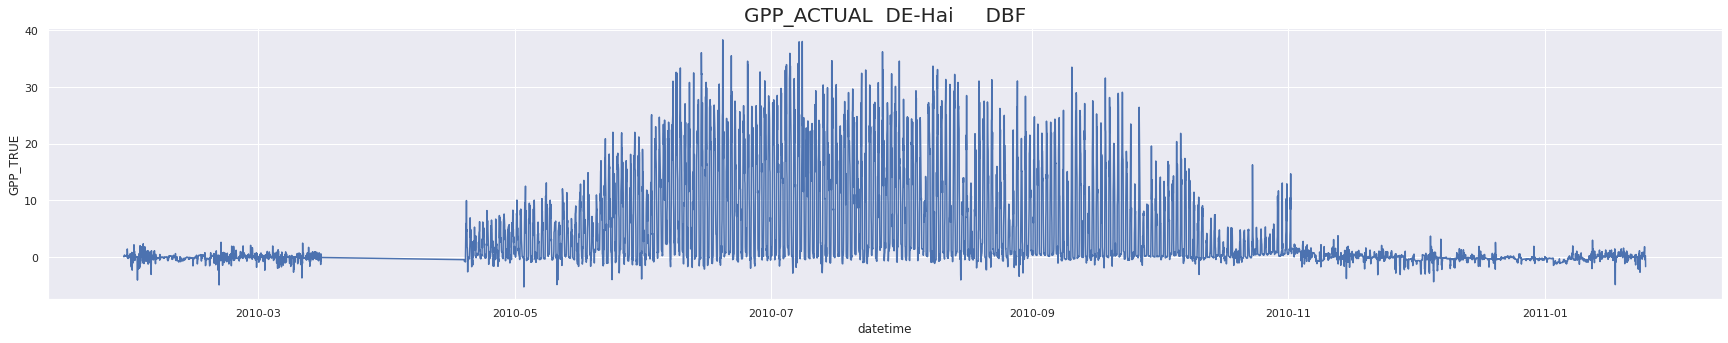

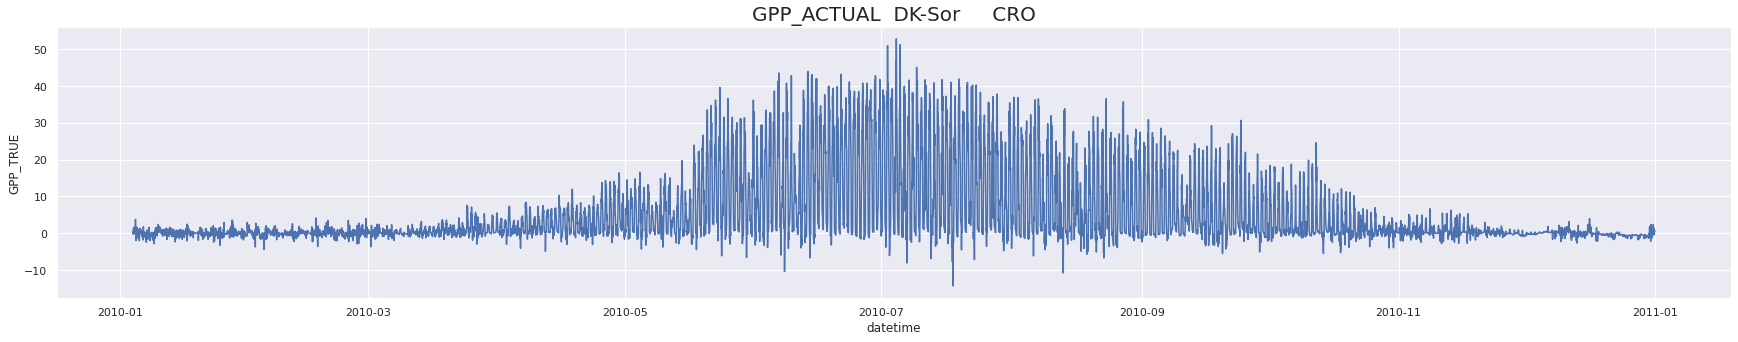

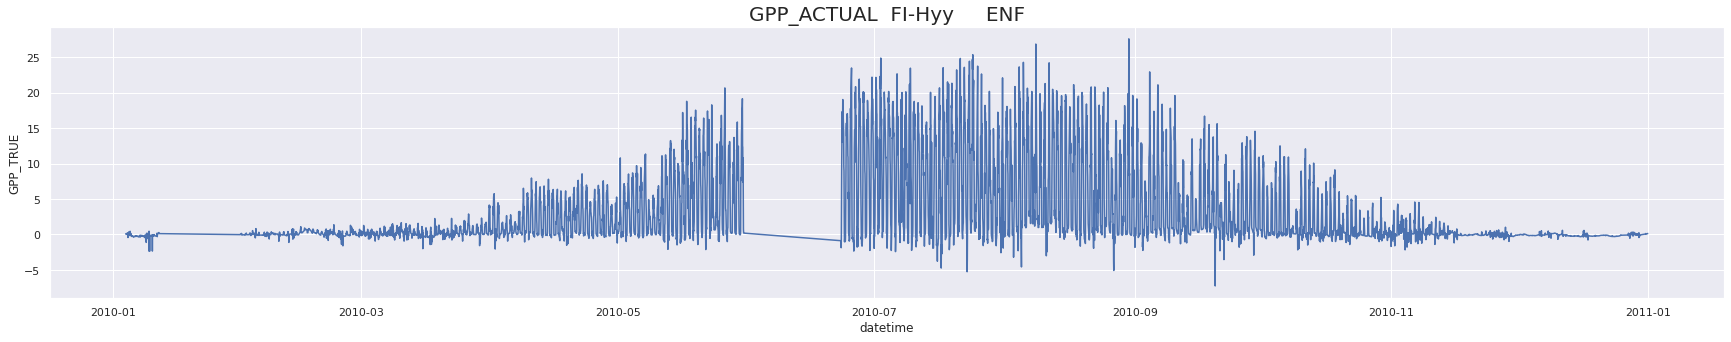

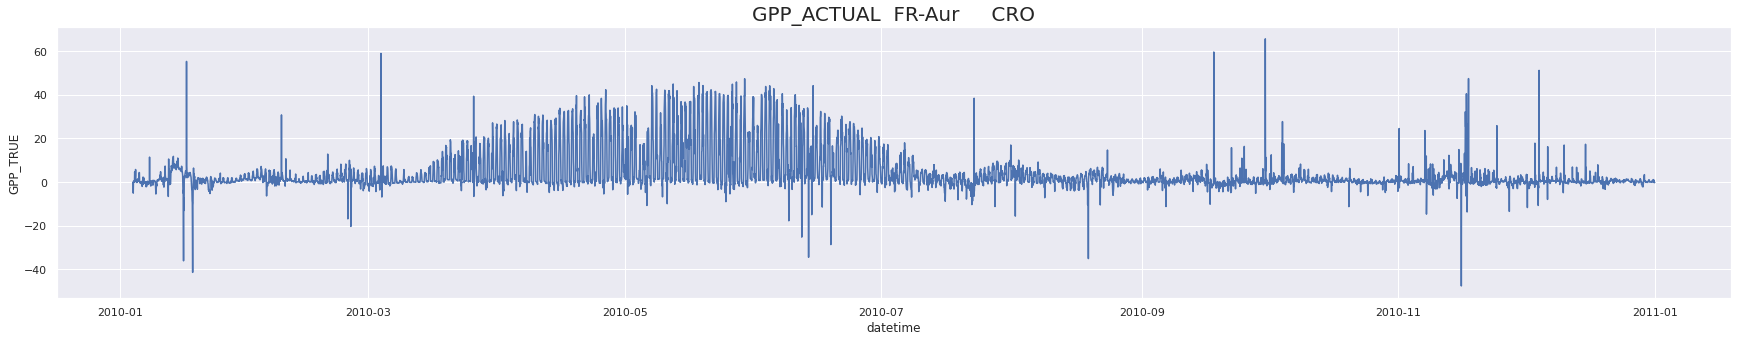

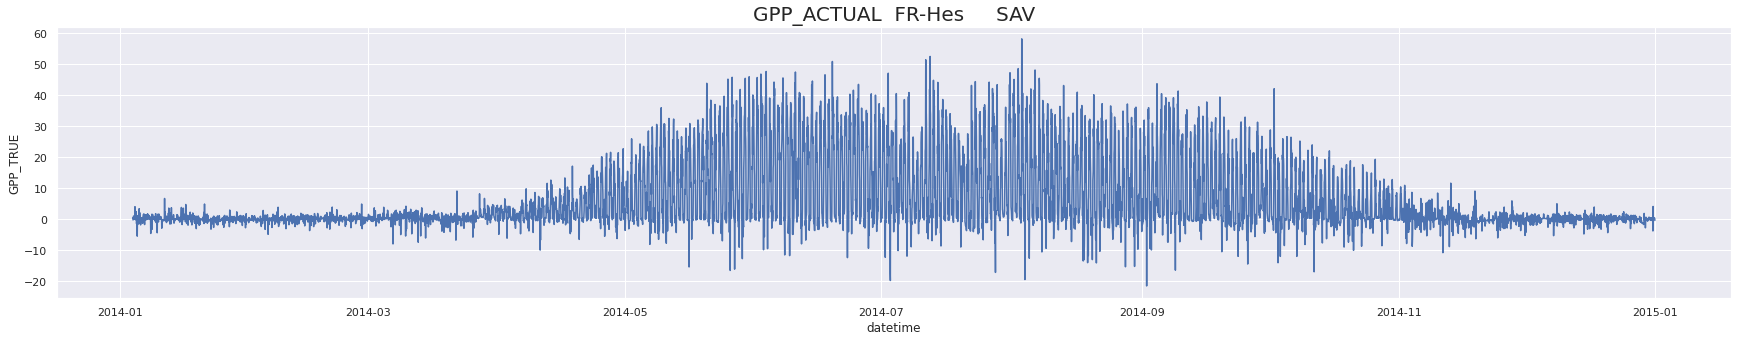

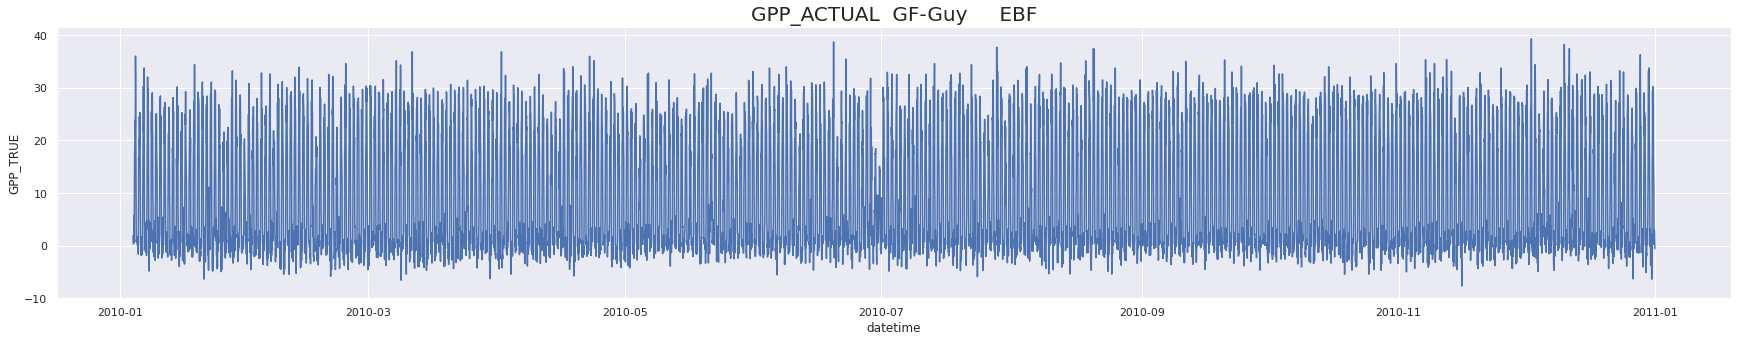

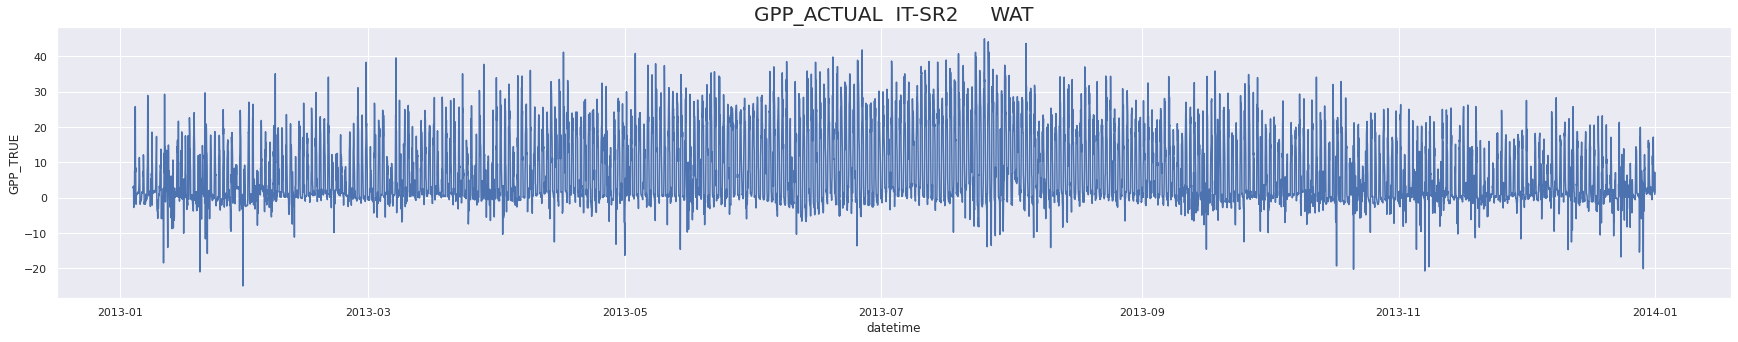

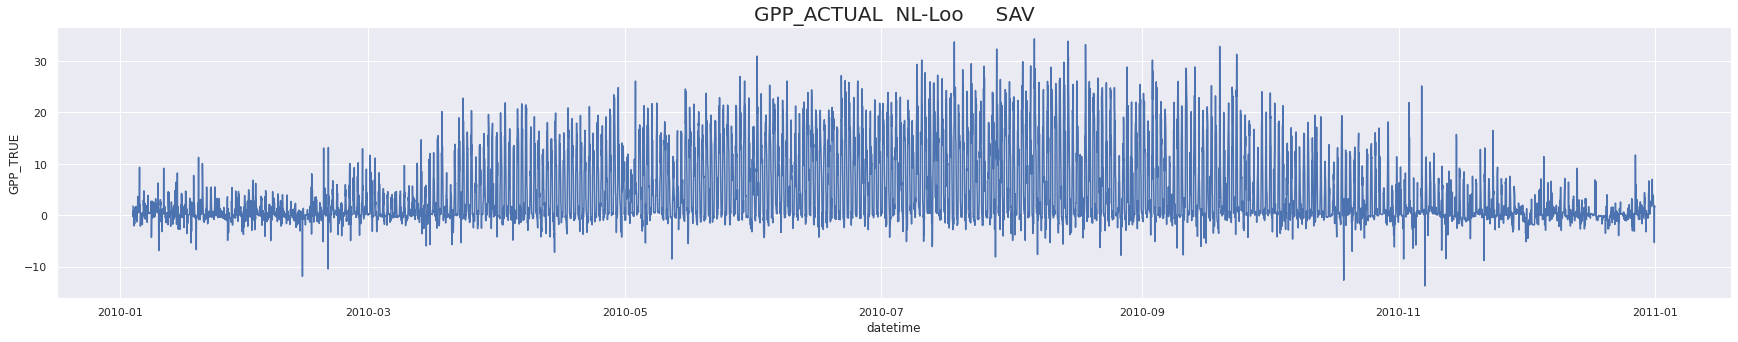

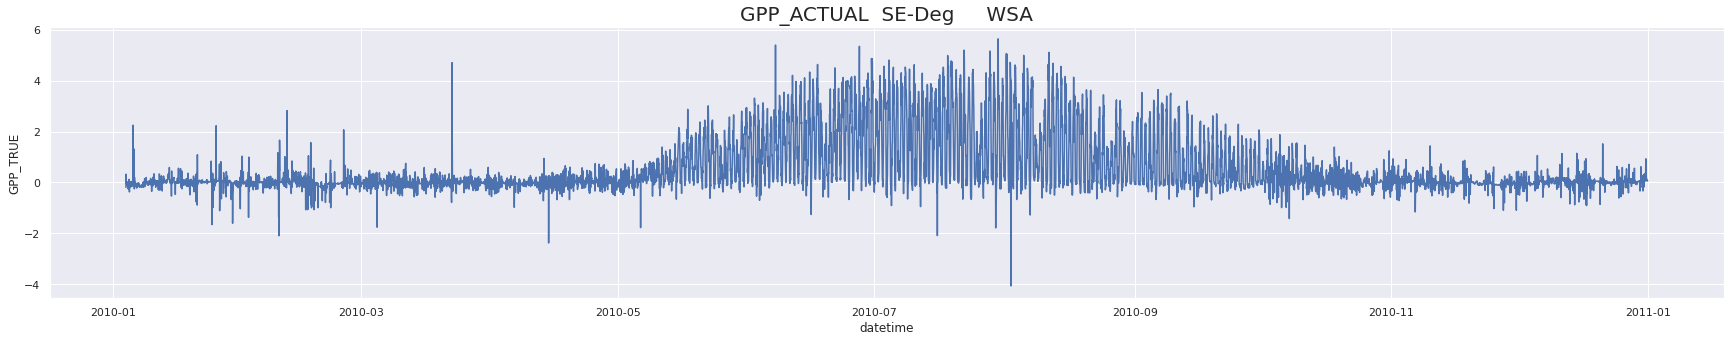

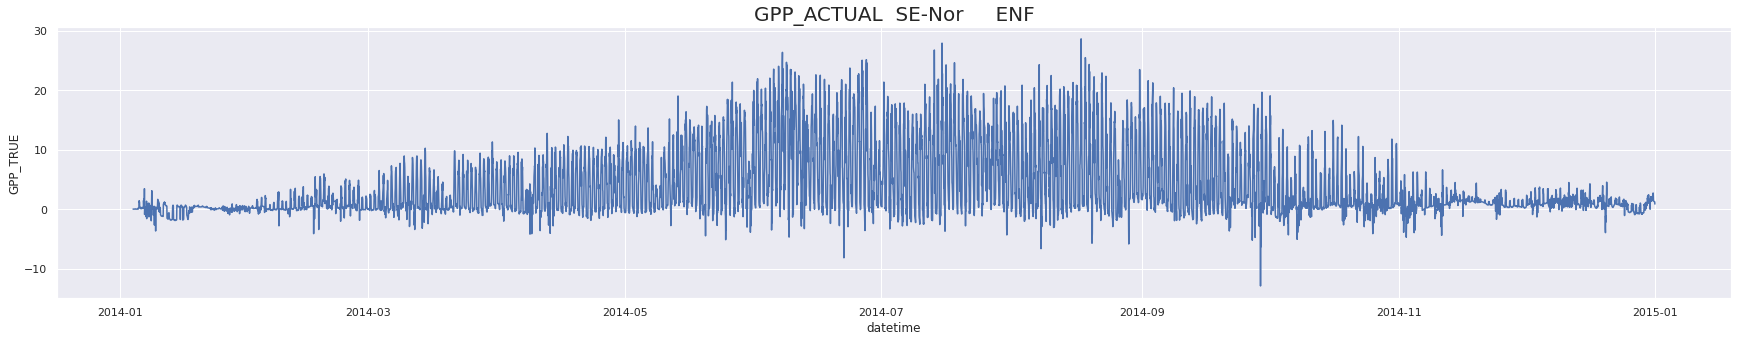

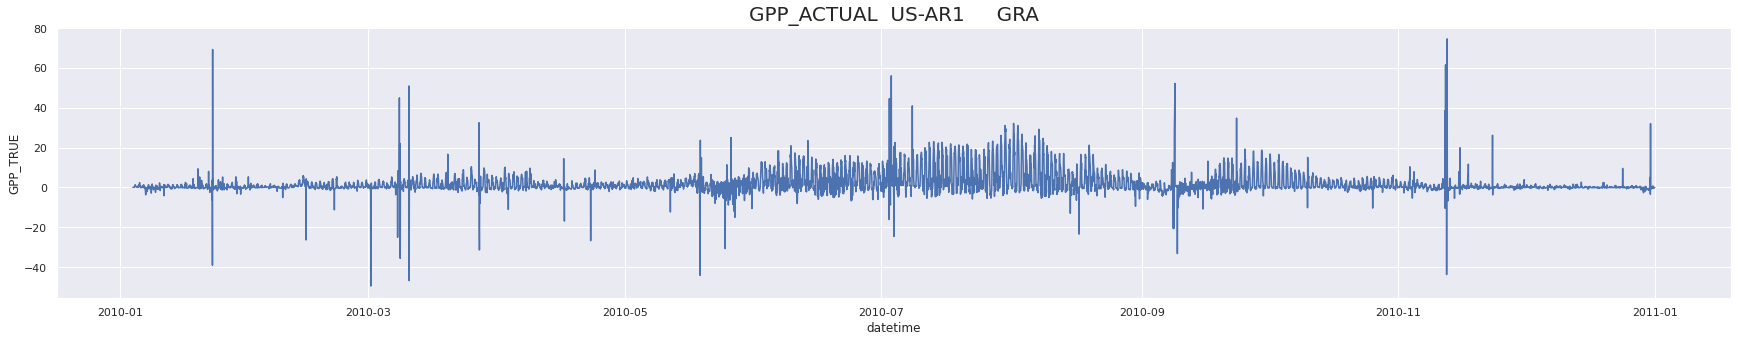

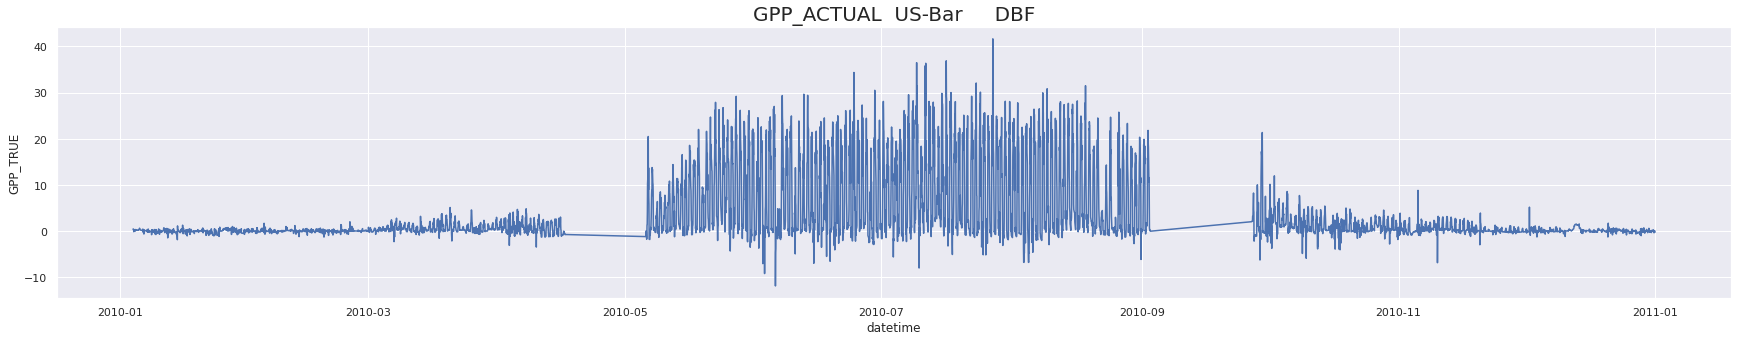

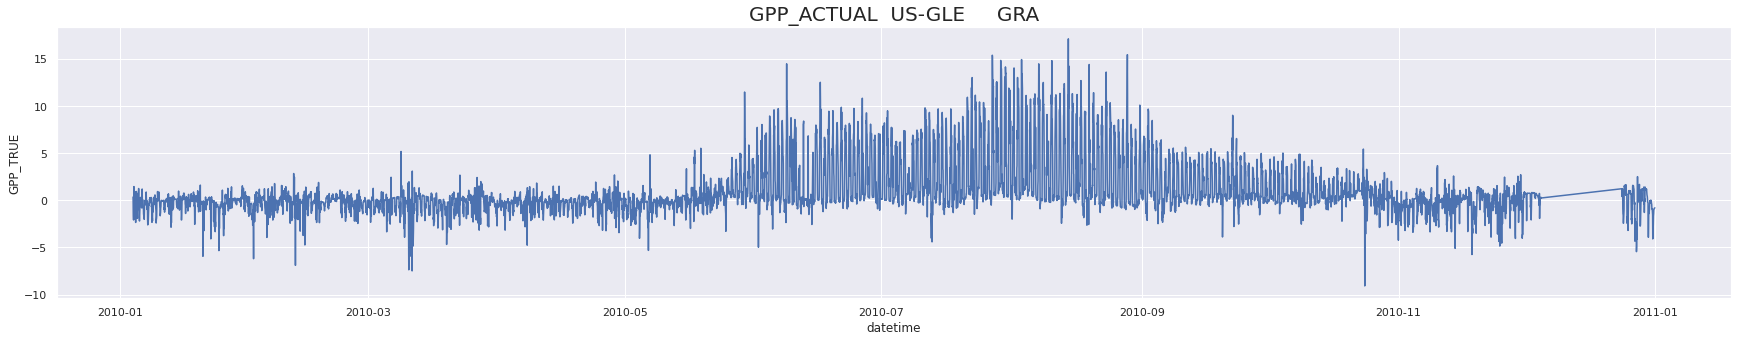

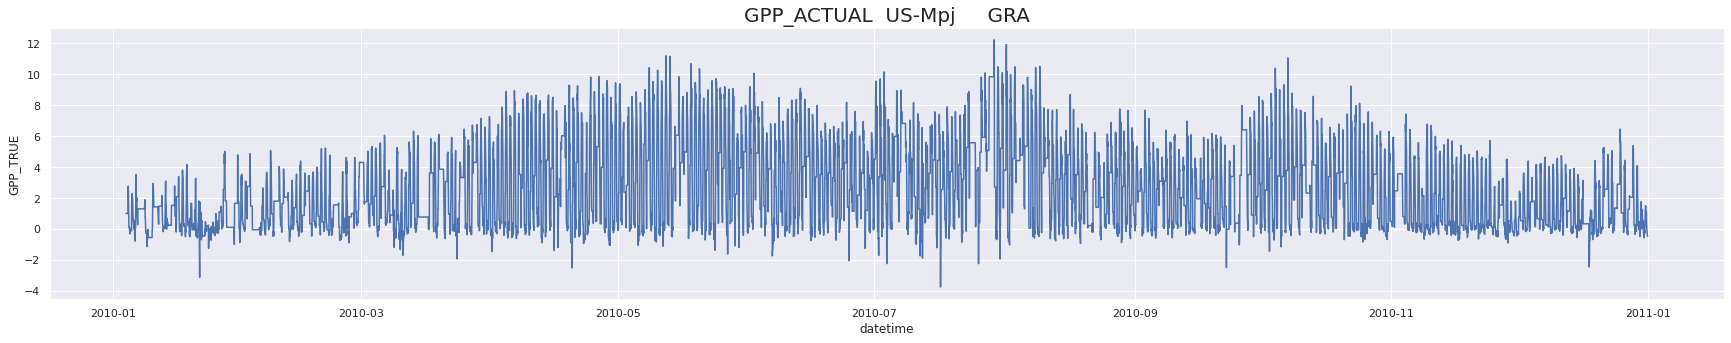

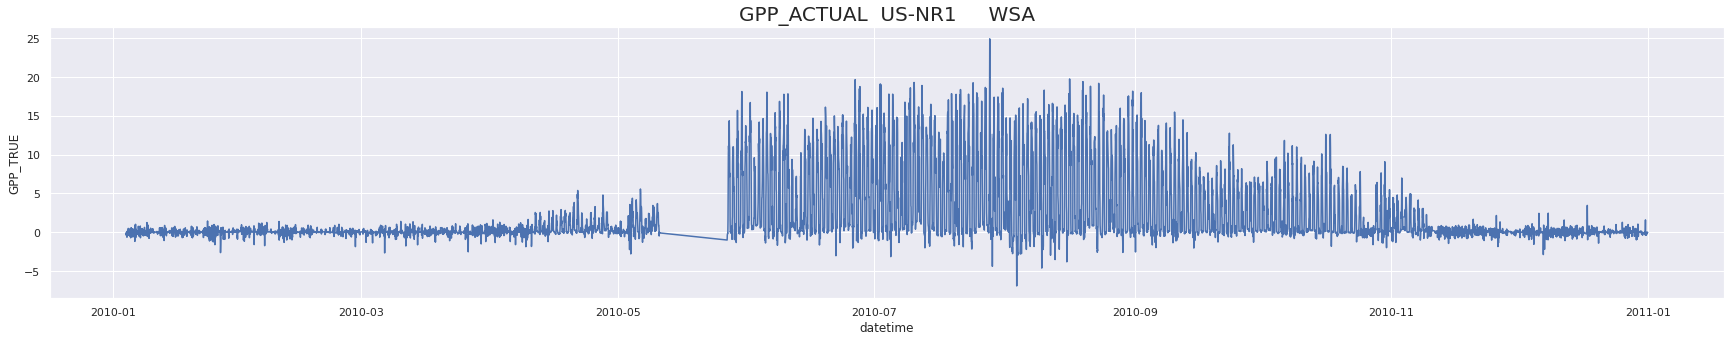

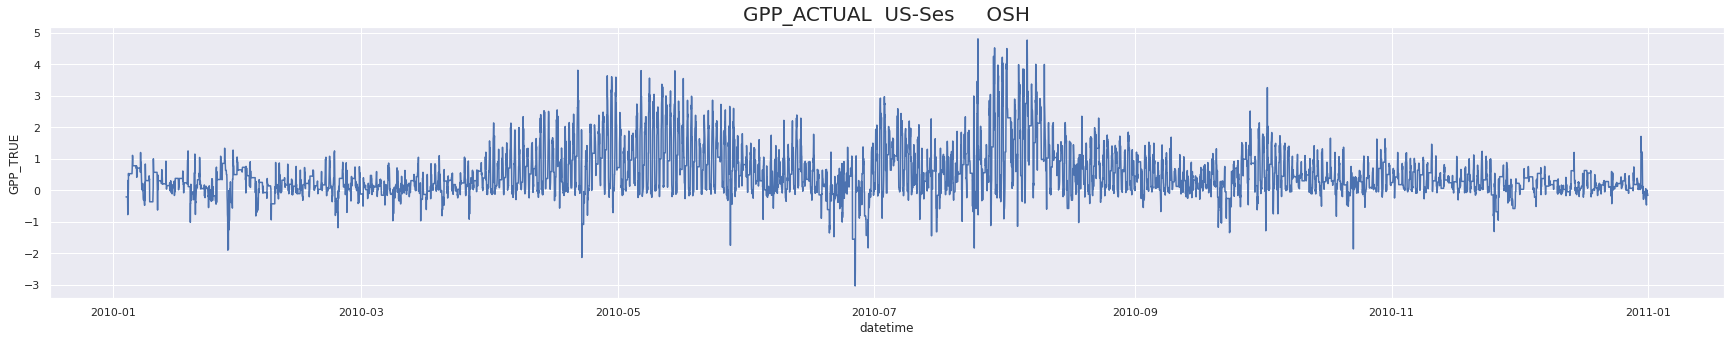

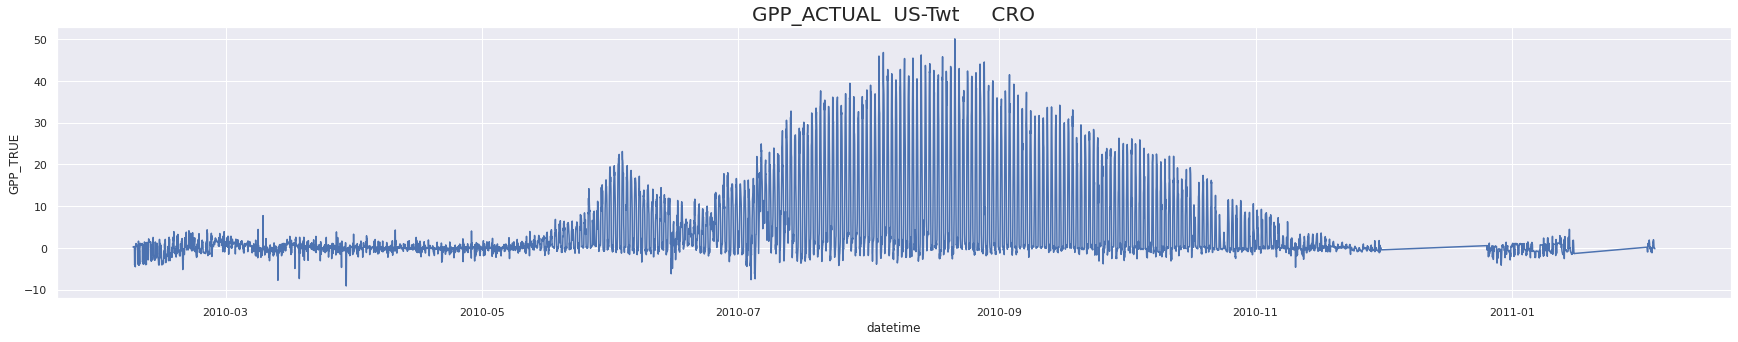

In [ ]:
# GPP Actual is 

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,5)})

for idx, i in enumerate(val_analysis_df['SITE_ID'].unique()):  
  plt.figure(idx)
  val_analysis_df_sub = val_analysis_df[val_analysis_df['SITE_ID'] == i]
  sns.lineplot(x="datetime", y="GPP_TRUE", #palette=['g'],
             data=val_analysis_df_sub).set_title("GPP_ACTUAL  " + i + "     " + val_analysis_df[val_analysis_df['SITE_ID']==i]['MODIS_IGBP'].unique()[0], fontsize=20)
  

## CDF

## CDF by sites

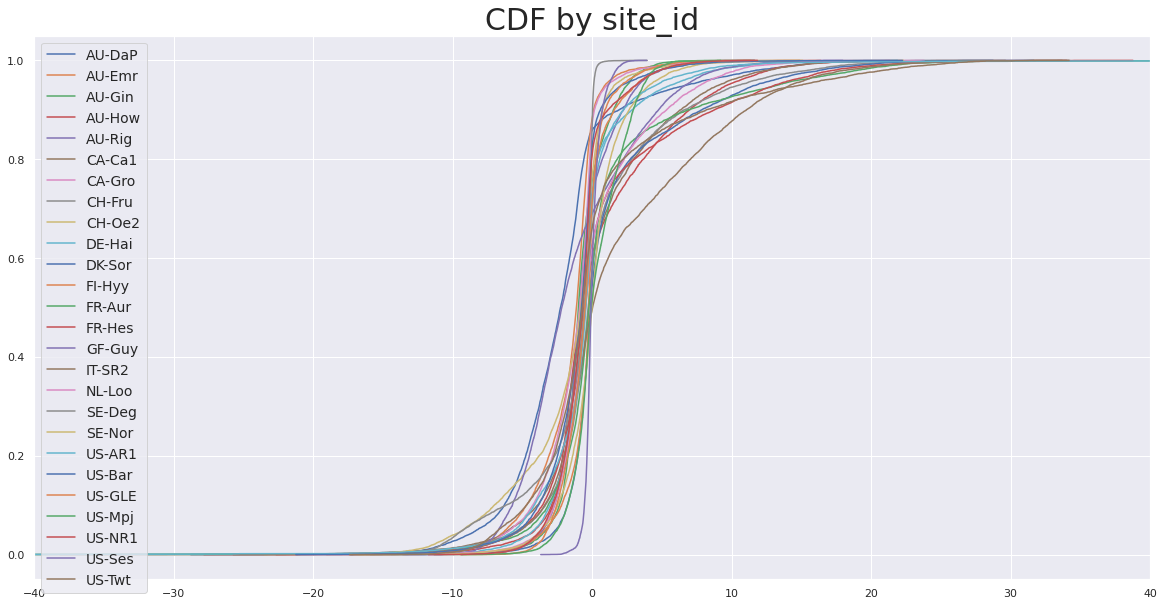

In [258]:
fig, axes = plt.subplots(figsize=(20,10))
# fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,20))
plt.xlim([-40, 40])
i = val_analysis_df["SITE_ID"].unique()


for i in val_analysis_df["SITE_ID"].unique():
  # getting data of the histogram
  count, bins_count = np.histogram(val_analysis_df[val_analysis_df["SITE_ID"]==i]["LOSS_Q_0.5"], 
                                  bins=val_analysis_df[val_analysis_df["SITE_ID"]==i]["LOSS_Q_0.5"].shape[0])
  # finding the PDF of the histogram using count values
  pdf = count / sum(count)
    
  # using numpy np.cumsum to calculate the CDF
  # We can also find using the PDF values by looping and adding
  cdf = np.cumsum(pdf)
  plt.plot(bins_count[1:], cdf, label=i)
  plt.legend(fontsize=14)
  plt.title("CDF by site_id", fontsize=30)

## CDF by MODIS_IGBP

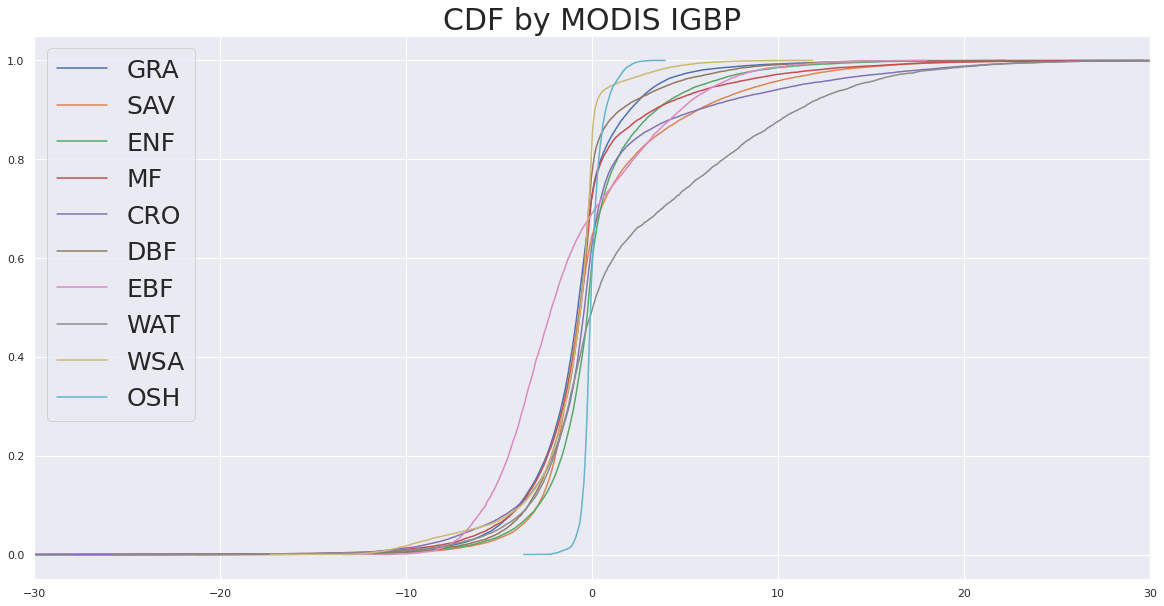

In [267]:
fig, axes = plt.subplots(figsize=(20,10))
# fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,20))
plt.xlim([-30, 30])
i = val_analysis_df["MODIS_IGBP"].unique()


for i in val_analysis_df["MODIS_IGBP"].unique():
  # getting data of the histogram
  count, bins_count = np.histogram(val_analysis_df[val_analysis_df["MODIS_IGBP"]==i]["LOSS_Q_0.5"], 
                                  bins=val_analysis_df[val_analysis_df["MODIS_IGBP"]==i]["LOSS_Q_0.5"].shape[0])
  # finding the PDF of the histogram using count values
  pdf = count / sum(count)
    
  # using numpy np.cumsum to calculate the CDF
  # We can also find using the PDF values by looping and adding
  cdf = np.cumsum(pdf)
  plt.plot(bins_count[1:], cdf, label=i)
  plt.legend(fontsize=25)
  plt.title("CDF by MODIS IGBP", fontsize=30)

## CDF by KOPPEN

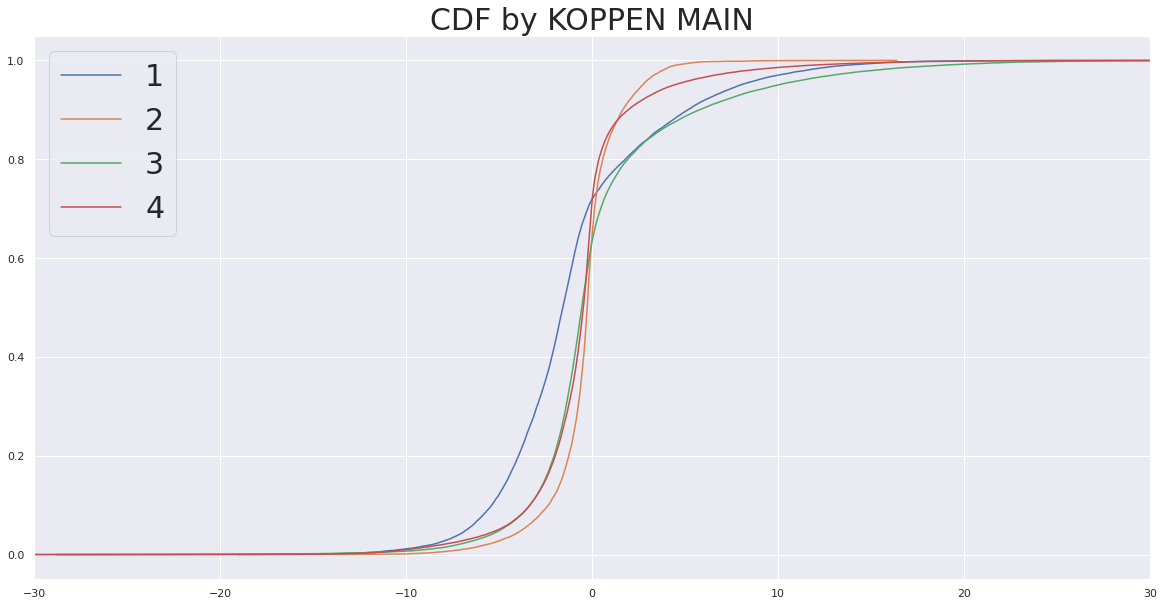

In [265]:
fig, axes = plt.subplots(figsize=(20,10))
# fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,20))
plt.xlim([-30, 30])
i = val_analysis_df["KOPPEN"].unique()


for i in val_analysis_df["KOPPEN"].unique():
  # getting data of the histogram
  count, bins_count = np.histogram(val_analysis_df[val_analysis_df["KOPPEN"]==i]["LOSS_Q_0.5"], 
                                  bins=val_analysis_df[val_analysis_df["KOPPEN"]==i]["LOSS_Q_0.5"].shape[0])
  # finding the PDF of the histogram using count values
  pdf = count / sum(count)
    
  # using numpy np.cumsum to calculate the CDF
  # We can also find using the PDF values by looping and adding
  cdf = np.cumsum(pdf)
  plt.plot(bins_count[1:], cdf, label=i)
  plt.legend(fontsize=30)
  plt.title("CDF by KOPPEN MAIN", fontsize=30)

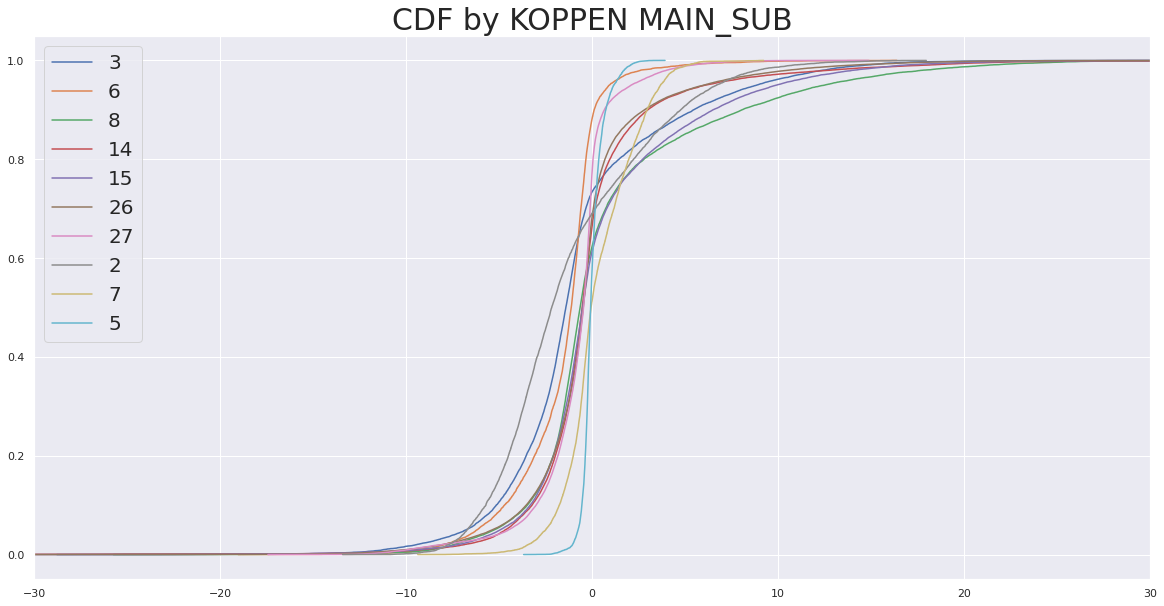

In [266]:
fig, axes = plt.subplots(figsize=(20,10))
# fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,20))
plt.xlim([-30, 30])
i = val_analysis_df["KOPPEN_SUB"].unique()


for i in val_analysis_df["KOPPEN_SUB"].unique():
  # getting data of the histogram
  count, bins_count = np.histogram(val_analysis_df[val_analysis_df["KOPPEN_SUB"]==i]["LOSS_Q_0.5"], 
                                  bins=val_analysis_df[val_analysis_df["KOPPEN_SUB"]==i]["LOSS_Q_0.5"].shape[0])
  # finding the PDF of the histogram using count values
  pdf = count / sum(count)
    
  # using numpy np.cumsum to calculate the CDF
  # We can also find using the PDF values by looping and adding
  cdf = np.cumsum(pdf)
  plt.plot(bins_count[1:], cdf, label=i)
  plt.legend(fontsize=30)
  plt.title("CDF by KOPPEN MAIN_SUB", fontsize=30)

# Actuals vs predictions by variables

- Checking how the model performs across different slices of the data allows us to detect weaknesses. 
- Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the `calculate_prediction_actual_by_variable(){` and `plot_prediction_actual_by_variable()` methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.

In [ ]:
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(val_x, val_raw_predictions)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);